In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry as sg
import math
import pandas as pd
import seaborn as sns
from IPython.display import Image
import os
import sys
sys.path.append('/home/pedro/route-quality/')
from route_quality.datamodel.routing import RoutePlan, Waypoint, Route
from route_quality.datamodel.geo import Geometry, GeoCoordinate
from route_quality.services.routers import DasRouter, GoogleRouter, RouteHarvester
from route_quality.generators.random import RandomRouteGenerator, berlin
import glob
from route_quality.metrics.geometry import GeometryComparator

def load_credentials(credentials_file):
    with open(credentials_file, 'r') as f:
        user, password = [l.rstrip('\n').split('=')[1] for l in f.readlines()]
    return user, password

def render_geometries(geometries, title='', ax=None, xlim=None, ylim=None):
    if not ax:
        ax = plt
    for geo in geometries:
        ax.scatter(*zip(*geo.to_lng_lat_tuples()), s=5)
        ax.set_title(title)
        if xlim:
            ax.set_xlim(xlim)
        if ylim:
            ax.set_ylim(ylim)
                   
def render_basic_scenarios():    
    f, ax = plt.subplots(2, 3)
    plt.gcf().set_size_inches(15, 7)
    render_geometries([test_identical_1, test_identical_2], title='identical routes', ax=ax[0][0])
    render_geometries([test_similar_1, test_similar_2], title='similar routes', ax=ax[0][1])
    render_geometries([test_different_1, test_different_2], title='different routes', ax=ax[0][2])
    render_geometries([test_disjoint_1, test_disjoint_2], title='disjoint routes', ax=ax[1][0])
    render_geometries([test_reverse_1, test_reverse_2], title='reverse', ax=ax[1][1])
    render_geometries([test_corners_1, test_corners_2], title='corner cutting', ax=ax[1][2], xlim=(-121.902545, -121.900871), ylim=(37.32944, 37.330303))
    plt.tight_layout()
    
def render_detours():    
    f, ax = plt.subplots(2, 3)
    plt.gcf().set_size_inches(15, 7)
    render_geometries([test_detour_small_1, test_detour_small_2], title='short detour', ax=ax[0][0])
    render_geometries([test_detour_small_very_short_1, test_detour_small_very_short_2], title='short detour (short route)', ax=ax[0][1])
    render_geometries([test_detour_big_very_short_1, test_detour_big_very_short_2], title='big detour (short route)', ax=ax[0][2])
    render_geometries([test_detour_big_1, test_detour_big_2], title='big detour', ax=ax[1][0])
    render_geometries([test_detour_small_very_long_1, test_detour_small_very_long_2], title='short detour (long route)', ax=ax[1][1])
    render_geometries([test_detour_big_very_long_1, test_detour_big_very_long_2], title='big detour (long route)', ax=ax[1][2])
    plt.tight_layout()
    
def render_shifts():    
    f, ax = plt.subplots(2, 4)
    plt.gcf().set_size_inches(15, 6)
    render_geometries([test_shifted_low_1, test_shifted_low_2], title='1 meter', ax=ax[0][0])
    render_geometries([test_shifted_medium_1, test_shifted_medium_2], title='10 meters', ax=ax[0][1])
    render_geometries([test_shifted_high_1, test_shifted_high_2], title='50 meters', ax=ax[0][2])
    render_geometries([test_shifted_very_high_1, test_shifted_very_high_2], title='200 meters', ax=ax[0][3])
    render_geometries([test_shifted_low_very_short_route_1, test_shifted_low_very_short_route_2], title='1 meter (very short route)', ax=ax[1][0])
    render_geometries([test_shifted_high_very_short_route_1, test_shifted_high_very_short_route_2], title='50 meter (very short)', ax=ax[1][1])
    render_geometries([test_shifted_low_very_long_route_1, test_shifted_low_very_long_route_2], title='1 meter (very long route)', ax=ax[1][2])
    render_geometries([test_shifted_high_very_long_route_1, test_shifted_high_very_long_route_2], title='50 meter (very long route)', ax=ax[1][3])
    plt.tight_layout()
    
def render_noisy():    
    f, ax = plt.subplots(2, 4)
    plt.gcf().set_size_inches(15, 6)
    render_geometries([test_noisy_low_1, test_noisy_low_2], title='mean=0m, std=1m', ax=ax[0][0])
    render_geometries([test_noisy_gps_1, test_noisy_gps_2], title='mean=0m, std=4.2m', ax=ax[0][1])
    render_geometries([test_noisy_high_1, test_noisy_high_2], title='mean=0m, std=150m', ax=ax[0][2])
    render_geometries([test_noisy_bias_1, test_noisy_bias_2], title='mean=30m, std=20m', ax=ax[0][3])
    render_geometries([test_noisy_gps_very_short_1, test_noisy_gps_very_short_2], title='mean=0m, std=4.2m (very short route)', ax=ax[1][0])
    render_geometries([test_noisy_high_very_short_1, test_noisy_high_very_short_2], title='mean=0m, std=100m (very short route)', ax=ax[1][1])
    render_geometries([test_noisy_gps_very_long_1, test_noisy_gps_very_long_2], title='mean=0m, std=4.2m (very long route)', ax=ax[1][2])
    render_geometries([test_noisy_high_very_long_1, test_noisy_high_very_long_2], title='mean=0m, std=100m (very long route)', ax=ax[1][3])
    plt.tight_layout()
    
def render_sparse():
    f, ax = plt.subplots(2, 4)
    plt.gcf().set_size_inches(15, 6)
    render_geometries([test_sparsified_low_1, test_sparsified_low_2], title='sampling_frequency=2', ax=ax[0][0])
    render_geometries([test_sparsified_medium_1, test_sparsified_medium_2], title='sampling_frequency=5', ax=ax[0][1])
    render_geometries([test_sparsified_high_1, test_sparsified_high_2], title='sampling_frequency=10', ax=ax[0][2])
    render_geometries([test_sparsified_very_high_1, test_sparsified_very_high_2], title='sampling_frequency=30', ax=ax[0][3])
    render_geometries([test_sparsified_low_very_short_1, test_sparsified_low_very_short_2], title='sampling_frequency=2 (very short)', ax=ax[1][0])
    render_geometries([test_sparsified_high_very_short_1, test_sparsified_high_very_short_2], title='sampling_frequency=10 (very short)', ax=ax[1][1])
    render_geometries([test_sparsified_low_very_long_1, test_sparsified_low_very_long_2], title='sampling_frequency=2 (very long)', ax=ax[1][2])
    render_geometries([test_sparsified_high_very_long_1, test_sparsified_high_very_long_2], title='sampling_frequency=10 (very long)', ax=ax[1][3])
    plt.tight_layout()
    
def render_start_end_mismatch():
    f, ax = plt.subplots(1, 3)
    plt.gcf().set_size_inches(13, 4)
    xlim=(13.498, 13.51)
    ylim=(52.53, 52.545)
    render_geometries([test_mismatch_small_1, test_mismatch_small_2], title=f'offset={math.hypot(*small_offset)}m', ax=ax[0], xlim=xlim, ylim=ylim)
    render_geometries([test_mismatch_medium_1, test_mismatch_medium_2], title=f'offset={math.hypot(*medium_offset)}m', ax=ax[1], xlim=xlim, ylim=ylim)
    render_geometries([test_mismatch_large_1, test_mismatch_large_2], title=f'offset={math.hypot(*large_offset)}m', ax=ax[2],xlim=xlim, ylim=ylim)
    plt.tight_layout()
    
def run_tests(tests, configs, save_debug_artifacts='debug'):
    results = {}
    for test in zip(tests[::2], tests[1::2]):
        test_name = os.path.basename(test[0]).split('.json')[0].rstrip('_1')
        geo1 = Geometry.from_geojson(test[0])
        geo2 = Geometry.from_geojson(test[1])
        results[test_name] = {experiment: GeometryComparator().compare(geo1, 
                                                                       geo2, 
                                                                       method['name'], 
                                                                       **method['params']) for experiment, method in configs.items()}        
        if save_debug_artifacts:
            f = plt.figure(figsize=(12, 7))
            plt.title(test_name)
            ax = f.add_subplot(111)            
            plt.plot(*zip(*geo1.to_linestring(convert_to_utm=True).coords), c='r')
            plt.plot(*zip(*geo2.to_linestring(convert_to_utm=True).coords), c='silver')
            x = 1.02
            y = 0.95
            for experiment, score in results[test_name].items():
                plt.text(s=f'{experiment}: {round(score, 3)}', x=x, y=y, transform=ax.transAxes)
                y -= 0.05
            plt.savefig(os.path.join(save_debug_artifacts, f'{str(test_name)}_debug.png'))
        
    return results

def plot_all(df):
    for case, values in df.iterrows():
        google_geo = Geometry.from_polyline(values['geometry_google'])
        das_geo = Geometry.from_polyline(values['geometry_das-traffic'])
        plt.plot(*zip(*google_geo.to_linestring(convert_to_utm=True).coords), c='r')
        plt.plot(*zip(*das_geo.to_linestring(convert_to_utm=True).coords), c='r')
    
def create_debug_artifacts(df, debug_folder='debug'):
    os.makedirs(debug_folder, exist_ok=True)
    metrics = {col.split('score_compare_')[1]: col for col in df.columns if 'score_compare' in col}
    for case, values in df.iterrows():        
        f = plt.figure(figsize=(12, 7))
        plt.title(case)
        ax = f.add_subplot(111)
        google_geo = Geometry.from_polyline(values['geometry_google'])
        das_geo = Geometry.from_polyline(values['geometry_das-traffic'])
        plt.plot(*zip(*google_geo.to_linestring(convert_to_utm=True).coords), c='r')
        plt.plot(*zip(*das_geo.to_linestring(convert_to_utm=True).coords), c='silver')
        x = 1.02
        y = 0.95
        for name, col in metrics.items():
            plt.text(s=f'{name}: {round(values[col], 3)}', x=x, y=y, transform=ax.transAxes)
            y -= 0.05
        plt.savefig(os.path.join(debug_folder, f'{str(case)}_debug.png'))

user, password = load_credentials('/home/pedro/.credentials/ldap.txt')

# fixtures
base_case = Geometry.from_polyline('mfj_IgexpAC|BQxP_D_@mDa@yCYEAAeA_AQ[bGEx@wHyAA?OCKCC?UECAMAKCkI}AoE{@{E{AYM_@~@O^Sd@GNo@fBWfAGVALKb@CZG^ALEZQ@SA[E[E[KOEc@Mw@]]Oc@UICQIGAKCGAq@IQAQ?K@a@DYFE@YJMHqCvAu@^_Af@GBMFKFOHOHc@R[JG@KDQBUBC?i@DK?]A]Ig@K]Mg@Wc@[GE[YYUi@g@wAcAUOqGmEw@UOMoCkBSSs@g@k@_@GE_@UGESMUQ??GEUOc@YsBuACAOKKG_BcA_@_@g@_@uA}@SS_AoAm@s@q@y@a@a@SGW?i@DG@]DCQIc@I[So@Wq@IQg@aAYg@}@{A[k@c@u@Yg@cBuCy@sAQY_@g@Y_@EIU]]k@c@i@]e@k@q@oCgDOQaCaDKMOOs@_AU]GIMOU]OS_@c@MQ_@c@k@u@_AgAsAeBi@w@Wc@KO[i@Wc@MWYe@iA{Cs@qBSi@_@eAu@_Bc@s@c@i@yJaKWYi@o@iCaDGIs@iAEGCCEEKKS]MQg@u@CEyA}AEEQSLa@?CV{@Ri@Z_AJ[Lk@\\}Al@sCp@uCH_@He@H]BKJg@v@_EVuADWD[De@Bc@@]@c@?Y?WAsBAcB?[CgE?o@Au@?M?K?YAs@?a@Ac@KuL?O?aA?s@?sA?M?iA?m@EaAC_@?MAUEoDGaA[yEAMKsAEs@IiAKeAM_AQcAEWCKEWGWS_Ao@yCEYa@mBOs@IYQ}@m@}CMk@UqAESG]AM[eBY_BMm@CMG[ACS_AKq@UmAWqACMCMWkACOGSGWGYAGI]Os@QaAsAuHc@_CIa@I_@cAyFo@_Em@wEk@yDk@eECOk@_FAMIk@COKw@q@aFQoASaBGc@Im@[}BKs@AE]aCWaBMm@y@kEwAeKcAoH{@kGAMM_AK{@u@kFk@eEM}@AOm@iEkAuIs@wEC]AKEe@C_@AIC]Cc@IgEU}IScI?Wi@qU?IAm@Ac@MoEMyE?K_@ePOwGAKAg@Aw@]wOKsE?OA{BC}FAeBGmFAIAk@]BYBG@E?I@k@DWDK@k@DiAJYBSAQ?m@Ee@IQGKAKAG?YAYAm@Da@H]N[Pc@VA@_@`@y@`AOXa@EgBa@]IwBq@TcL')
base_case_similar = Geometry.from_polyline('ofj_IgexpASpSAd@UCm@IiAK_Ec@_D_@?gAy@M{AYeB[iDo@mCxToP{C{ALkCVuAWkBQcASQG_CcA{@[eAKk@Fy@LOHkAn@aD|AkAj@cAh@k@T_@F_@Bk@@i@Em@Ke@Qa@Sm@a@mCcCoAy@sFoDgAy@c@[KCI@UOqA{@[[gAu@s@_@mAaAkDwB{@i@}AcACKCGSKyAaAuAaB{AsBOO]Q]Eo@Dc@JIg@m@wB_@cAYi@_A_B{A_CoD}FoByCsC{DwCuD}FqHg@u@_DyDoBeCg@w@k@aAw@}AQOyA{DaBmE_@aAs@oAw@_AmEkE}@{@gCiCkCgDcAuAa@y@eAqAaCuC`@qANc@^mApAoFx@sD|@iEdAoFRsALaBBmACgHUa[?_H?m@K_CEaCGmBk@wI[_EW{Ai@qCyAmH{AiHa@oBa@eCeAwFsBgKc@mBsBeLkDcSgCwQi@cFuAaK{AaL_@mCo@sDo@iDuAwJoC}RyBqPgCuQm@wEWeDYgLeCcfAa@}PS}IGaFCwHEiFCiBG{B[Bi@FcALmANcBHa@Aw@KaASi@A[@c@Fk@No@Zo@d@k@l@WZ[b@[CkA]g@IkCs@HuDJoF')
base_case_different = Geometry.from_polyline('mfj_IgexpAC|BQxP_D_@mDa@yCYEAAeA_AQgAUYGkEw@LkAt@gGR_B@IBUOMOKQOQKIGQOaHaFa@YSMSOSOMIaBmAOMYSU]Wy@KWCGAAKQUOOMaFqDOMm@c@oBuAMIKAMBODUPGEw@g@GGqEcDq@i@QMGEOIKG]UMIIEWQCCi@[uEgDOKuAcAoDkCKI]UEEUQSMGGq@e@[SmA{@IGOMEEsAaAQOQOBW?_@E[IOGIKCK?MDML[CSA[QIGk@_@WSu@i@OMUQ]U_CcBu@i@c@[GC}BeBeAw@oCoBiAy@qEaDQMMIgCiBUQi@_@[UOIQMGGOINw@PkA@CBOJm@BMb@eCRmA@Gt@oELu@RgA`@gCBMDYQMGE{@i@cFcDeAo@y@m@[WmBcB][EEa@]q@m@EESSQe@S]uB_DIIs@y@y@s@cCwBiAcAy@o@qAy@i@]a@Ug@Wm@WgAe@i@[IGGIEICEEKGSE[G[I[QWKGICG@Q@SLONKJWNEBI@A?EAAAA?oA]yHqCSIYEQEo@GyDQ[G{@EG?C?E?I??a@Ac@KuL?O?aA?s@?sA?M?iA?m@EaAC_@?MAUEoDGaA[yEAMKsAEs@IiAKeAM_AQcAEWCKEWGWS_Ao@yCEYa@mBOs@IYQ}@m@}CMk@UqAESG]AM[eBY_BMm@CMG[ACS_AKq@UmAWqACMCMWkACOGSGWGYAGI]Os@QaAsAuHc@_CIa@I_@cAyFo@_Em@wEk@yDk@eECOk@_FAMIk@COKw@q@aFQoASaBGc@Im@[}BKs@AE]aCWaBMm@y@kEwAeKcAoH{@kGAMM_AK{@u@kFk@eEM}@AOm@iEkAuIs@wEC]AKEe@C_@AIC]Cc@IgEU}IScI?Wi@qU?IAm@Ac@MoEMyE?K_@ePOwGAKAg@Aw@]wOKsE?OA{BC}FAeBGmFAIAk@]BYBG@E?I@k@DWDK@k@DiAJYBSAQ?m@Ee@IQGKAKAG?YAYAm@Da@H]N[Pc@VA@_@`@y@`AOXa@EgBa@]IwBq@TcL')

divergent_case_base = Geometry.from_polyline('eip_IofwpA?@VCQmFWyIAYCgACmAGq@EYMcAa@wAKs@Ok@I[CISs@CKCGYcAOi@[gACOm@kBAGCEK_@Si@}@eCQ_@iAoCCGMYQc@Ym@AEe@kAi@oACI[u@gBmE_B{Dg@oAc@cAQe@EMKSEM_@aAIWEKKQg@cAeAoBGOIMo@oAm@gAGI[g@c@m@SQCCk@s@OU]c@mA_BIKGGEGuBoC_@e@_AuAoA_BEGW[w@y@e@a@CCUQaCkB{@y@GESQa@]CCa@[aBgBaAaAsAgAcA{@IGUQYWsAaAiB}@QKOIwBgAwAs@o@[i@W_@SGCMGuFsCQKyAs@QKWKSKgCoAmCsAQKiCqAcAg@q@[iAi@GCk@YUKECKGo@YQIeCoAKGuBcAIEGCECkEwBo@YgBw@MGSIQS{BiAcAa@qAi@ICMIYQyCy@SE]KUIuA_@k@OKCeCy@u@WUIICKESIQGs@[CAoAc@iBm@')
divergent_case_alternative = Geometry.from_polyline('eip_IofwpA?@@N?HFxBDnA@^BnA?VA\\AFAr@Bh@?PVrIC\\@VLfFD|B[B[BuBRgBLK@UBMMC?AAKAe@FyBTC@E?IDKDA@K@]BUBUBA?C?EBMHUBK@mAL{CZQ@qBRUBmAFc@@}@F_BH[@qAF_AJ[D}D`@U@OBODA@UDA?]J{BRCA[EWHMJGDKPOPSVCD_@f@KXGLABe@j@uAhB_@f@g@n@kAbBKLs@`AUXkA|AKNMPc@f@EFSVEF??Y^ABEBGB?@]d@GFITY^U\\OPEDc@l@EBGBSVMPGRcDlEc@j@SVeArAABSVW\\eAxAwAjBsAjBc@l@YNCB]h@IXoA~A[Pa@h@EBCDIRITQVEFq@`AA@k@v@c@n@QXQZYn@KTUe@s@wAS_@MUa@y@[o@[k@IOUe@}@kBo@sAmAcCUe@_@q@uB_E@Y?WCWCSKOOGMDIHYg@sCyFWg@Ue@aAoBg@_AAGMSMUCGSg@ISOm@uBkL??k@cDuCcOe@iCKk@Ia@GY]qBAEEUNMhE_D|B_BjAy@f@]xB_BRIFCf@]XSXUXWRQBAtAcADC`@YbAs@^Y`CeBjCmBBCVOG]GUMs@UmAWsAc@gCG[s@wDIe@[cBSeAESGY?CMq@y@iEu@uDCQSeA]mBk@eDE]AECSOsAWeCIm@]}CGg@WyB[qCAe@@WHoBNgELaDLe@JkC?G@I@QEiABk@@MBa@VsCJoA\\iABS@MBYHk@J{ATsC@MFm@Di@n@iHVqCd@}FJoAZwD@KD[Fu@`@kEJsAL{A@KJs@D]BOUKECKGo@YQIeCoAKGuBcAIEGCECkEwBo@YgBw@MGSIQS{BiAcAa@qAi@ICMIYQyCy@SE]KUIuA_@k@OKCeCy@u@WUIICKESIQGs@[CAoAc@iBm@')

short_case = Geometry(base_case[20:50])
long_case = Geometry.from_polyline('sa|~His}nA?_ABoAJaIDgG?{@C_DIuEAe@OyEMmGAO?gBK_BA[C_AU_JOuD[eHKkBc@kK_@wH[qHQeDi@_M{@qPCa@GcAo@kLwA_XkAkSOeBeAmKWoCIaAI{@o@wHS_ECm@EcBi@aKG}@Co@k@{KAMEaAEo@Ew@o@uLi@_L?OGaACq@AKMqCMkCe@yIQuCAYAMAGYeFAOASAMCc@MmBIgBEs@UkEAMA]CWC[e@kIAMAMgAkPK{AAKCe@GcAw@wNE_AAy@Ao@@gAF{B@_@H_BPgBNaAX}AZmABOJ[f@oBBIJ_@H[UUQOWUcAcAk@o@IIUe@Sg@Og@CII_@SiAKm@_@qBIi@Kg@G]Ii@YaBCMEWKy@SmAQm@Q_@aA{BaAyBoCgGk@qAk@yA_BcEo@kA{@qAk@y@m@s@[Ua@Q_@Kw@CUBe@Je@Vy@n@o@h@m@d@yAhAgAp@_A\\iAVK@eADUAw@EuAMc@E{AMUIKEGAg@Y_@_@SSg@w@IMa@s@U_@_@m@CEe@y@u@qA{AmCo@sAg@oAIQSg@IUGONe@HOFSF[BU@SBW@YAa@?c@MoCCe@E_ACo@QoDEe@]CoA{@kA}@UQSSWYi@m@uA}AsA}AuEkFqB_Cy@_Au@}@wBcCaDoEcCeDeAuAc@k@eI_L_LuOoOmSqNeSqKuNmIcLy@gAsO_TwJgN{C_EeNmRw@cAaTcYgGoIcDoEqCuDqFqHg@q@iFiH}B_D_EkF}B}CaSuUoY{\\cE{E{CuDqCqDgSsXSWuKeO{EwGOS}EuGkHwJ}EuGgFiHsAgBo@}@_@w@iD}EkHsKiBiCuAiBq@cA]g@Q[Sc@O[KWM_@I]Ka@G_@Ie@Ga@Ee@Ei@Ck@Co@Cq@E}AAeAE}CCiAGiAKiBIu@Ky@Qy@Sw@Mc@Qe@Yo@k@q@YWYMQG[ES?UBUBSHSDQDUFS@S?M?QCUG[MWMeDkEWYc@a@e@a@c@[WO[MWI[GYCc@GkA?kAEs@Gu@Me@Mi@Uy@c@{JaGmDoB]UiDmBi@Uq@W{@Q}@OwB]eBSiCMaCBs@HoAVgA`@kAr@k@h@o@r@sAvBm@z@k@p@UVk@^i@\\c@RmBt@_KnDoFdB_EpAoBb@qARq@Ju@F}@FeABY?q@CqAKsAWqAY{@UiC{@yB{@gD}AsC{AiCcBm@c@oB}A}@}@]a@eAoAo@aAy@aB[u@a@y@Sg@Uk@Uo@[cA_@uAUeAQaAO}@[uBQ}AQuBGs@GqAIuBGoDEgDKcGOsEGkAEoAS}Cc@kH{@}KKqA}@sL{AqSgC_]sCo_@gA{NsA{QKqAUcBYsCUqBc@eDe@}Ci@cDy@_EkAqFCMk@gCoAiEmAaE_BkEWq@k@qAa@iAOa@GUEMc@{A{@iCISAEEIEMCIMWYq@EKM[GKKYQ]iDgIQa@KUGOIQe@gAqEoKgD}Hc@iAM[k@sAEKISUc@KU]y@c@cAa@_AWm@o@wAs@eBGOKUMYgAiCCGuAcDQ_@Ui@KUIS{AkDO]c@eAEKM]O[{@oBOW_@{@Wq@GMO_@M[IWi@qAGOgAeC{@sB_A}BEKISKWiCgGyBiFq@}A]w@i@wAIMCKQ_@IUw@iBe@gAuBeFGMEKKWqA_DmEgKMYM[E]E_@GiB?SA[Ag@A[]cLAk@@g@FqBDy@RkGPuEBq@@g@@[@QBc@JyD@]@QBg@Bu@@[V}GPeF@Q@]Bq@@c@?Sp@sRFqA@[?Q@UHsBFgBDwA@[H}B@S@W@a@WOCCYQSOYUsCiBMGyAaAIEGEmD{BOIECSMOI_Aa@WSOM]Wg@c@GEUQSO{@o@WUKIe@c@SQGGeAcAg@g@gAiAcAgAQQq@s@_AoAKQ}@wAQ[k@qAa@}@qAyC}@wBO[Se@EKKYm@qAQ_@GMM[Qc@??KUc@_A_@y@]q@IOEGa@o@[k@EEMUKSOUEGcAaB]m@kAiBmAqBMSa@o@sCqEq@gAMSGI{@uAGOGQEUA[Ce@?g@?KAMAIEIDKDSBQBM?]AYAc@QgCAUGaA?CAq@?o@AoAGy@O_ACSY_B_@yBq@iEAKMs@WqBGa@Mu@Gc@a@oCQu@Qm@K[Qo@Oc@I[G[o@{CMs@Wq@CUCIm@uDEWe@kCScAM{@EUMu@AMCI@i@?UAUAuAM{GAm@SmCm@}EUoBIg@OuAw@yGSi@Qe@_@u@mDmHcCaFu@}AKOk@}@]g@sBuC_@g@aB}B]g@MOEGq@{@c@a@s@i@Sg@Ya@qB{BmBmBWCcFcFuDqDQQgApEM\\Yb@WRa@HSAu@S}I{JiHgIeG_HkX{Zq@u@aNuOeBsAoBaByBuA{BgA{Q{GuDqAuHsC{HoCgImCyA[yCe@}EO}DJyDf@cDx@kC`AeEvBcBtAqCbCoAnAi@R_FjEkB`BKR_CgFmAiB}@{AkGkJe@w@e@s@QYwAwByA{BaAwAmEgGyHsKiG_JkHkJuGiIqCkDs@cAe@_AmAqC_AuBw@sAuA_BgAiAuAwAaA{@oAy@qAy@}@k@_AcAY]_BwBq@}@yCsD}BiCsA_BIKmAwA_AgACEwCqDkAwAqCkD_FwFwBmCqDgEoCeDc@k@mLmNo@w@}@eA_BsBOOsEuFSSgAsA_@a@USgC{Bk@k@{AgByG_ImBq@kDu@UEwGwAkB_@qAY_TwDw@Im@e@cDoDCCKMKKkLuLaCeC')

detour_case_base = Geometry.from_polyline('cbr_ImsxoATmBFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@^oDr@yGB[l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iDZsA')
detour_case_small = Geometry.from_polyline('cbr_ImsxoATmBFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@~B|@`@{D??t@mH_Cy@l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iDZsA')
detour_case_big = Geometry.from_polyline('cbr_ImsxoATmBFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@fBp@??VJxCfAbDpA~DzAjDnAlDjAx@Z??nAf@v@wH??`@oDcBm@??g@SoDsAiDiA}DcBeDeAyCmA_A[??_A]l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iDZsA')
detour_case_very_long_base = Geometry.from_polyline('ifs_IcqeoAMuCOsCGYEcCAw@AkAC}@?g@M}IIsEHqDAkBEyDAqBCmCKyHO{LGuE?a@KuF?QCgAAm@Aq@?a@CwB?]K{JIiHEmBCgBA}@AY?[AOIgFIqF?UAu@CsCCkBMyGCuBEwCOuKKgGKyHE}DCsBMuKGyDYuBEsC?OAUA[?[EuBKaGCoBA_BCwAC_CAk@CsCCiBCmBCuBKaI?[BeAFeA@KRkBHo@X_CD[\\qCP}AV_Cf@eEz@eHLeAD[@KPwA@MHq@Hm@Hk@D]ReAJg@XgAV}@Tq@`C{GRg@dCsGfBkEFMDMN_@t@gB|EoLRo@FMDML[vA{EfAsEb@qB^eBBKF_@Jg@^oCVgCRoCJcCDiA@kBAyA?I?UEy@C]QiBGk@Oy@o@{CcAyCU_Ak@}Ak@}BQq@W{AKo@My@AOEWIy@Gy@KgBIeCAiDDwCT{DtAmN?A@IBYBYtAgP@E@K@SRwB@IDc@NkBRuBRcC`@oE\\wD~@wJ^_DFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@^oDr@yGB[l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iD`AmEhBqILo@Pu@j@oCb@iBNo@Py@BMJa@Jg@Lk@Jc@Nw@TaAF[h@gCVkADSXoADSXuAFU@IR}@Ha@XoAXkAh@cCNw@XkAp@aDt@aD`@qBFSBKDUFUFW|@mE~@eEJw@LaAR_CJ_B@GBe@BWBOFe@Hs@Jo@F]Nq@@KDOJYDEFGDCFCJANDHFHFTFJBH?NANCHEJGJIFKHMFMFSDUBKHc@BQFYBMDKDMHQ@EDGDGHOZc@j@y@z@wAZg@vGmKP[DGT]\\k@x@}BL[~@gCf@{AL]BGNa@x@aC@CTq@Xw@L[b@mAZ{@DOfAwC@ENWPa@Vk@Pk@HUFQL]Tg@J]Pe@Rk@t@wBDKBINa@?IDSDi@@EDw@Bu@LqCHcB@[JiCDy@@S@Q@_@@_@A]Au@IeAEo@AMI_AEs@Ca@?WAi@?U?M?YBk@Hu@D_@BM@IBMF]Ha@DUp@oERmAJo@Ji@f@aDHo@v@mGBKFg@Fk@DWLkAHm@l@iELw@`@mCBQPcABMHg@RyAF]\\{BPiA\\{B^cCVaBBKD[F]Da@VyBx@mFHg@z@mFXmBRsANcABKF_@DWBIHi@n@sDn@{CHa@hAmGNu@PHDBF@t@XBW')
detour_case_very_long_small = Geometry.from_polyline('ifs_IcqeoAMuCOsCGYEcCAw@AkAC}@?g@M}IIsEHqDAkBEyDAqBCmCKyHO{LGuE?a@KuF?QCgAAm@Aq@?a@CwB?]K{JIiHEmBCgBA}@AY?[AOIgFIqF?UAu@CsCCkBMyGCuBEwCOuKKgGKyHE}DCsBMuKGyDYuBEsC?OAUA[?[EuBKaGCoBA_BCwAC_CAk@CsCCiBCmBCuBKaI?[BeAFeA@KRkBHo@X_CD[\\qCP}AV_Cf@eEz@eHLeAD[@KPwA@MHq@Hm@Hk@D]ReAJg@XgAV}@Tq@`C{GRg@dCsGfBkEFMDMN_@t@gB|EoLRo@FMDML[vA{EfAsEb@qB^eBBKF_@Jg@^oCVgCRoCJcCDiA@kBAyA?I?UEy@C]QiBGk@Oy@o@{CcAyCU_Ak@}Ak@}BQq@W{AKo@My@AOEWIy@Gy@KgBIeCAiDDwCT{DtAmN?A@IBYBYtAgP@E@K@SRwB@IDc@NkBRuBRcC`@oE\\wD~@wJ^_DFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@~B|@f@{E??n@mG_Cy@l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iD`AmEhBqILo@Pu@j@oCb@iBNo@Py@BMJa@Jg@Lk@Jc@Nw@TaAF[h@gCVkADSXoADSXuAFU@IR}@Ha@XoAXkAh@cCNw@XkAp@aDt@aD`@qBFSBKDUFUFW|@mE~@eEJw@LaAR_CJ_B@GBe@BWBOFe@Hs@Jo@F]Nq@@KDOJYDEFGDCFCJANDHFHFTFJBH?NANCHEJGJIFKHMFMFSDUBKHc@BQFYBMDKDMHQ@EDGDGHOZc@j@y@z@wAZg@vGmKP[DGT]\\k@x@}BL[~@gCf@{AL]BGNa@x@aC@CTq@Xw@L[b@mAZ{@DOfAwC@ENWPa@Vk@Pk@HUFQL]Tg@J]Pe@Rk@t@wBDKBINa@?IDSDi@@EDw@Bu@LqCHcB@[JiCDy@@S@Q@_@@_@A]Au@IeAEo@AMI_AEs@Ca@?WAi@?U?M?YBk@Hu@D_@BM@IBMF]Ha@DUp@oERmAJo@Ji@f@aDHo@v@mGBKFg@Fk@DWLkAHm@l@iELw@`@mCBQPcABMHg@RyAF]\\{BPiA\\{B^cCVaBBKD[F]Da@VyBx@mFHg@z@mFXmBRsANcABKF_@DWBIHi@n@sDn@{CHa@hAmGNu@PHDBF@t@XBW')
detour_case_very_long_big = Geometry.from_polyline('ifs_IcqeoAMuCOsCGYEcCAw@AkAC}@?g@M}IIsEHqDAkBEyDAqBCmCKyHO{LGuE?a@KuF?QCgAAm@Aq@?a@CwB?]K{JIiHEmBCgBA}@AY?[AOIgFIqF?UAu@CsCCkBMyGCuBEwCOuKKgGKyHE}DCsBMuKGyDYuBEsC?OAUA[?[EuBKaGCoBA_BCwAC_CAk@CsCCiBCmBCuBKaI?[BeAFeA@KRkBHo@X_CD[\\qCP}AV_Cf@eEz@eHLeAD[@KPwA@MHq@Hm@Hk@D]ReAJg@XgAV}@Tq@`C{GRg@dCsGfBkEFMDMN_@t@gB|EoLRo@FMDML[vA{EfAsEb@qB^eBBKF_@Jg@^oCVgCRoCJcCDiA@kBAyA?I?UEy@C]QiBGk@Oy@o@{CcAyCU_Ak@}Ak@}BQq@W{AKo@My@AOEWIy@Gy@KgBIeCAiDDwCT{DtAmN?A@IBYBYtAgP@E@K@SRwB@IDc@NkBRuBRcC`@oE\\wD~@wJ^_DFg@b@}CD[FYn@gEH_@RkADWRiAfAoFf@mC`@cC@GF_@ZcCLiANoAZcC@KFa@TcBP}@XyA\\wA@GLk@Jm@\\gBVuATuAj@sDl@eEn@gEHm@Fm@LoANuATeCTqBl@eGb@_EJaAFi@BY@K@Ir@gH`@eE\\cD@MBSHq@B[f@oE|AcOHw@fBp@??VJxCfAbDpA~DzAjDnAlDjAx@Z??nAf@v@wH??`@oDcBm@??g@SoDsAiDiA}DcBeDeAyCmA_A[??_A]l@eG^mDFk@J}@Hw@|@gJr@}GD[P}Ax@yHNuADs@A{@CkAEmAAQAg@Cs@MoEAo@Eo@IkDAe@ASA}ACq@EsBEgAEo@UuAIcDCw@?OAYAg@?KGyBEkBWwKEeB@e@I}CAUE{ACw@[gNEeBA]?MA[EyAA]S_JIiDA}@?M?g@Dc@Ja@\\}At@iD`AmEhBqILo@Pu@j@oCb@iBNo@Py@BMJa@Jg@Lk@Jc@Nw@TaAF[h@gCVkADSXoADSXuAFU@IR}@Ha@XoAXkAh@cCNw@XkAp@aDt@aD`@qBFSBKDUFUFW|@mE~@eEJw@LaAR_CJ_B@GBe@BWBOFe@Hs@Jo@F]Nq@@KDOJYDEFGDCFCJANDHFHFTFJBH?NANCHEJGJIFKHMFMFSDUBKHc@BQFYBMDKDMHQ@EDGDGHOZc@j@y@z@wAZg@vGmKP[DGT]\\k@x@}BL[~@gCf@{AL]BGNa@x@aC@CTq@Xw@L[b@mAZ{@DOfAwC@ENWPa@Vk@Pk@HUFQL]Tg@J]Pe@Rk@t@wBDKBINa@?IDSDi@@EDw@Bu@LqCHcB@[JiCDy@@S@Q@_@@_@A]Au@IeAEo@AMI_AEs@Ca@?WAi@?U?M?YBk@Hu@D_@BM@IBMF]Ha@DUp@oERmAJo@Ji@f@aDHo@v@mGBKFg@Fk@DWLkAHm@l@iELw@`@mCBQPcABMHg@RyAF]\\{BPiA\\{B^cCVaBBKD[F]Da@VyBx@mFHg@z@mFXmBRsANcABKF_@DWBIHi@n@sDn@{CHa@hAmGNu@PHDBF@t@XBW')

#test cases
test_identical_1 = test_identical_2 = base_case
test_similar_1, test_similar_2 = base_case, base_case_similar
test_different_1, test_different_2 = divergent_case_base, divergent_case_alternative
test_disjoint_1, test_disjoint_2 = base_case, divergent_case_base
test_reverse_1, test_reverse_2 = base_case, Geometry(base_case[::-1])
test_corners_1, test_corners_2 = Geometry.from_geojson('data/train_station_trace.geojson'), Geometry.from_geojson('data/train_station_match.geojson')
test_detour_small_1, test_detour_small_2 = detour_case_base, detour_case_small
test_detour_small_very_short_1, test_detour_small_very_short_2 = Geometry(detour_case_base[55:-60]), Geometry(detour_case_small[55:-60])
test_detour_big_very_short_1, test_detour_big_very_short_2 = Geometry(detour_case_base[55:-60]), Geometry(detour_case_big[55:-60])
test_detour_big_1, test_detour_big_2 = detour_case_base, detour_case_big
test_detour_small_very_long_1, test_detour_small_very_long_2 = detour_case_very_long_base, detour_case_very_long_small
test_detour_big_very_long_1, test_detour_big_very_long_2 = detour_case_very_long_base, detour_case_very_long_big
test_shifted_low_1, test_shifted_low_2 = base_case, base_case.shift(lat_offset=1, lng_offset=1)
test_shifted_medium_1, test_shifted_medium_2 = base_case, base_case.shift(lat_offset=10, lng_offset=10)
test_shifted_high_1, test_shifted_high_2 = base_case, base_case.shift(lat_offset=50, lng_offset=50)
test_shifted_very_high_1, test_shifted_very_high_2 = base_case, base_case.shift(lat_offset=200, lng_offset=200)
test_shifted_low_very_short_route_1, test_shifted_low_very_short_route_2 = short_case, short_case.shift(lat_offset=1, lng_offset=1)
test_shifted_high_very_short_route_1, test_shifted_high_very_short_route_2 = short_case, short_case.shift(lat_offset=50, lng_offset=50)
test_shifted_low_very_long_route_1, test_shifted_low_very_long_route_2 = long_case, long_case.shift(lat_offset=1, lng_offset=1)
test_shifted_high_very_long_route_1, test_shifted_high_very_long_route_2 = long_case, long_case.shift(lat_offset=50, lng_offset=50)
test_noisy_low_1, test_noisy_low_2 = base_case, base_case.add_noise(loc=0, scale=1, seed=0)
test_noisy_gps_1, test_noisy_gps_2  = base_case, base_case.add_noise(loc=0, scale=4.2, seed=0)
test_noisy_high_1, test_noisy_high_2 = base_case, base_case.add_noise(loc=0, scale=100, seed=0)
test_noisy_bias_1, test_noisy_bias_2 = base_case, base_case.add_noise(loc=50, scale=30, seed=0)
test_noisy_gps_very_short_1, test_noisy_gps_very_short_2 = short_case, short_case.add_noise(loc=0, scale=4.2, seed=0)
test_noisy_high_very_short_1, test_noisy_high_very_short_2 = short_case, short_case.add_noise(loc=0, scale=100, seed=0)
test_noisy_gps_very_long_1, test_noisy_gps_very_long_2 = long_case, long_case.add_noise(loc=0, scale=4.2, seed=0)
test_noisy_high_very_long_1, test_noisy_high_very_long_2 = long_case, long_case.add_noise(loc=0, scale=100, seed=0)
test_sparsified_low_1, test_sparsified_low_2 = base_case, base_case.subsample(2)
test_sparsified_medium_1, test_sparsified_medium_2 = base_case, base_case.subsample(5)
test_sparsified_high_1, test_sparsified_high_2 = base_case, base_case.subsample(10)
test_sparsified_very_high_1, test_sparsified_very_high_2 = base_case, base_case.subsample(30)
test_sparsified_low_very_short_1, test_sparsified_low_very_short_2 = short_case, short_case.subsample(2)
test_sparsified_high_very_short_1, test_sparsified_high_very_short_2 = short_case, short_case.subsample(10)
test_sparsified_low_very_long_1, test_sparsified_low_very_long_2 = long_case, long_case.subsample(2)
test_sparsified_high_very_long_1, test_sparsified_high_very_long_2 = long_case, long_case.subsample(10)
small_offset = [1] * 2
medium_offset = [40] * 2
large_offset = [400] * 2
test_mismatch_small_1 = base_case
small_offset_start = base_case.coords[0].add_offset(*small_offset)
small_offset_end = base_case.coords[-1].add_offset(*small_offset)
test_mismatch_small_2 = Geometry([Waypoint(small_offset_start.lat, small_offset_start.lng)] + 
                                 base_case.coords[1:-1] +
                                 [Waypoint(small_offset_end.lat, small_offset_end.lng)])
test_mismatch_medium_1 = base_case
medium_offset_start = base_case.coords[0].add_offset(*medium_offset)
medium_offset_end = base_case.coords[-1].add_offset(*medium_offset)
test_mismatch_medium_2 = Geometry([Waypoint(medium_offset_start.lat, medium_offset_start.lng)] + 
                                 base_case[1:-1] +
                                 [Waypoint(medium_offset_end.lat, medium_offset_end.lng)])
test_mismatch_large_1 = base_case
large_offset_start = base_case.coords[0].add_offset(*large_offset)
large_offset_end = base_case.coords[-1].add_offset(*large_offset)
test_mismatch_large_2 = Geometry([Waypoint(large_offset_start.lat, large_offset_start.lng)] + 
                                 base_case.coords[1:-1] +
                                 [Waypoint(large_offset_end.lat, large_offset_end.lng)])

   
tests = ['_'.join(m.split('_')[:-1]) for m in locals() if 'test_' in m]

for test in tests:
    geo_1, geo_2 = locals()[f'{test}_1'], locals()[f'{test}_2']
    geo_1.to_geojson(write_to=f'data/{test}_1.json')
    geo_2.to_geojson(write_to=f'data/{test}_2.json')

# Geometric comparison

* Mytaxi, Daimler: How similar are our routes vs. Google?

-Need reliable way to measure this!

## Methodology

* Review state-of-the-art
* Create synthetic test cases (controlled outcome)
* Test algorithms for:
    1. Meaningfulness
    2. Performance

### Synthetic test cases
* Emulate common challenging scenarios
    * Detours
    * Very short/long route sensitivity
    * Noise (trace vs match)
    * Shifts (different maps)
    * Sparseness (different sampling)    
* Control the desired outcome
* Total of 39 synthetic tests

#### Scenarios: basic

Test common and basic scenarios.

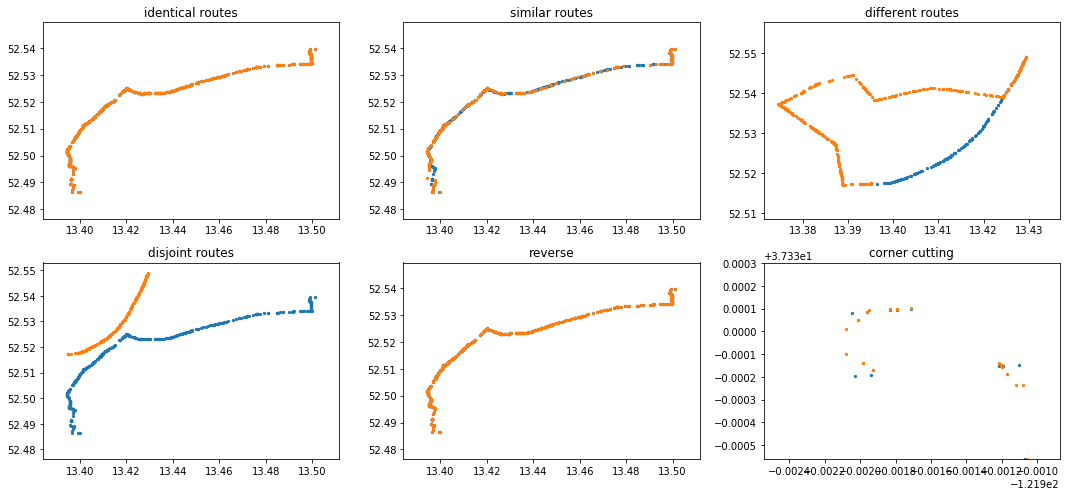

In [2]:
render_basic_scenarios()

#### Scenarios: detours

Test sensitivity to detour severity

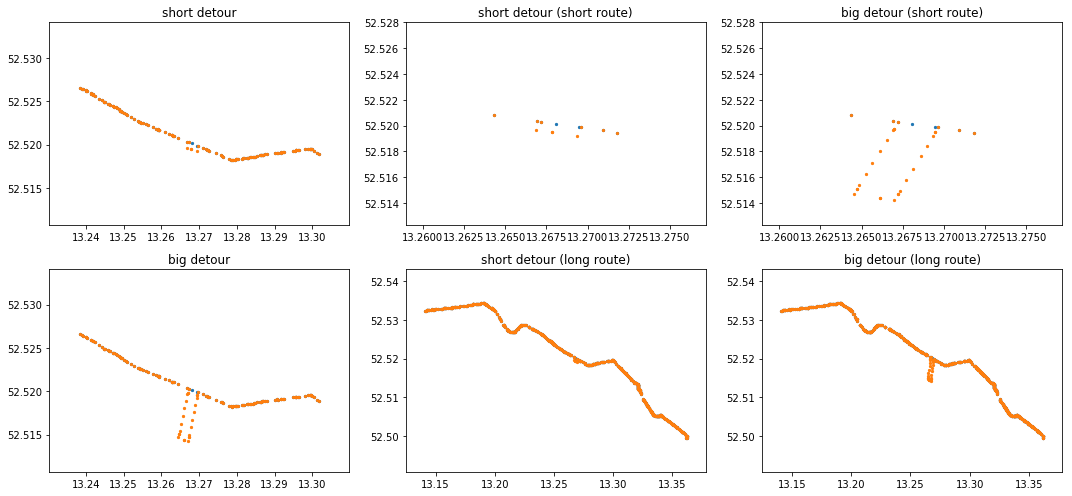

In [3]:
render_detours()

#### Scenarios: shifts

Test resiliance to shifted maps.

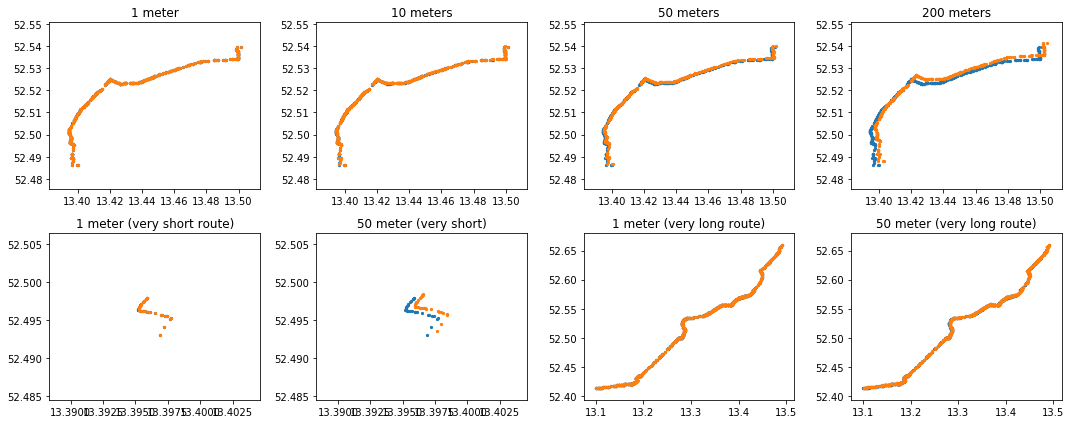

In [4]:
render_shifts()

#### Scenarios: noise

Test resiliance to noisy data (e.g. suitability as match success classifier)

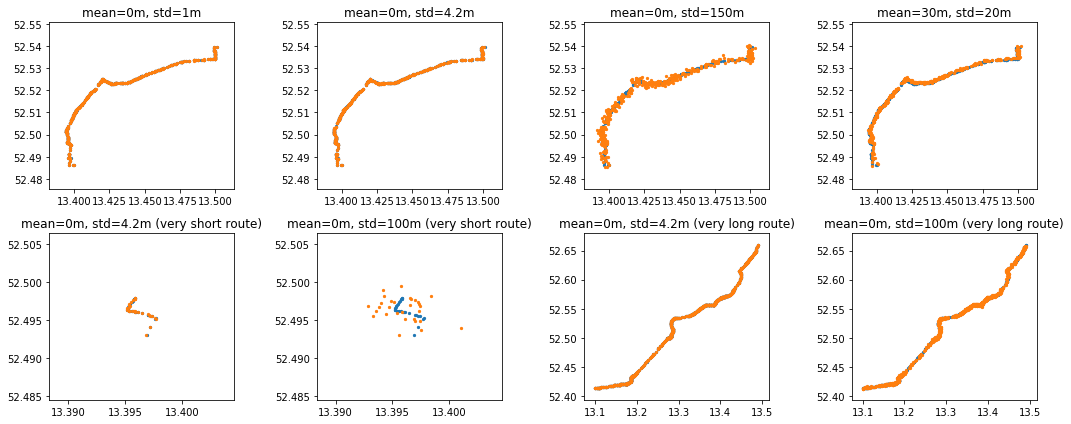

In [5]:
render_noisy()

#### Scenarios: subsampling

Test resiliance to subsampled routes

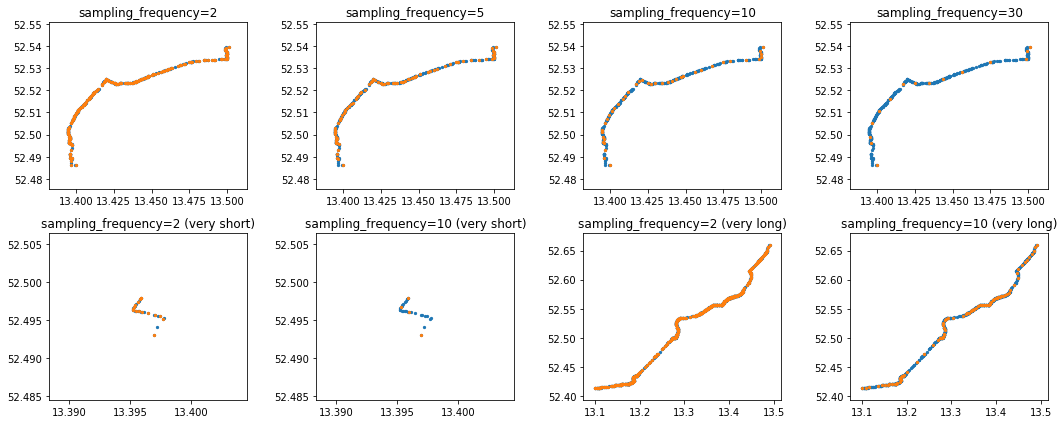

In [6]:
render_sparse()

#### Scenario: start/end point mismatch

Test resiliance to start/end point mismatch

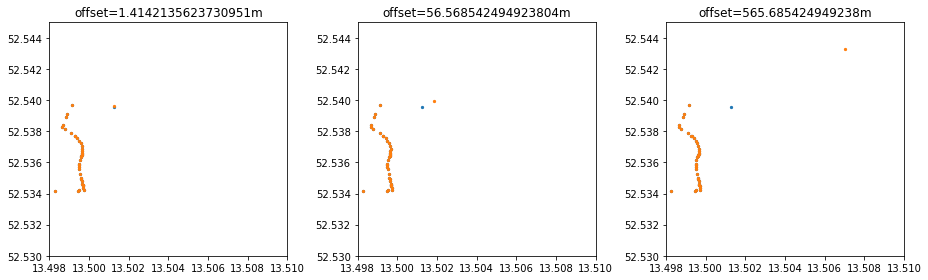

In [7]:
render_start_end_mismatch()

## Algorithms

Approaches:

| approach | "detour" sensitivity | "bias" sensitivity | range | speed | examples |
|------|------|------|------|------|------|
|  distance | high | low | 0-inf | slow/fast | Hausdorff, Frechet, centroids |
|  area | low | high | 0-inf | fast | AUC |
|  correlation | medium | medium | 0-100% | slow/fast | AUC normalized, CIR, CPR |
|  hybrid | high | high | 0-inf | slow | BOC |

* __detour sensitivity__: whether it captures occasional, well pronnounced differences
* __bias sensitivity__: whether it captures systemic, small differences

### Hausdorff distance

Maximum of minimum distance possible between any two pairs of points of the geometry.

https://en.wikipedia.org/wiki/Hausdorff_distance

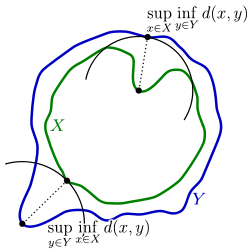

In [8]:
Image('_img/hausdorff.png', embed=True)

### Frechet distance

The Fréchet distance is a measure of similarity between curves that takes into account the location and ordering of the points along the curves.

https://en.wikipedia.org/wiki/Fréchet_distance

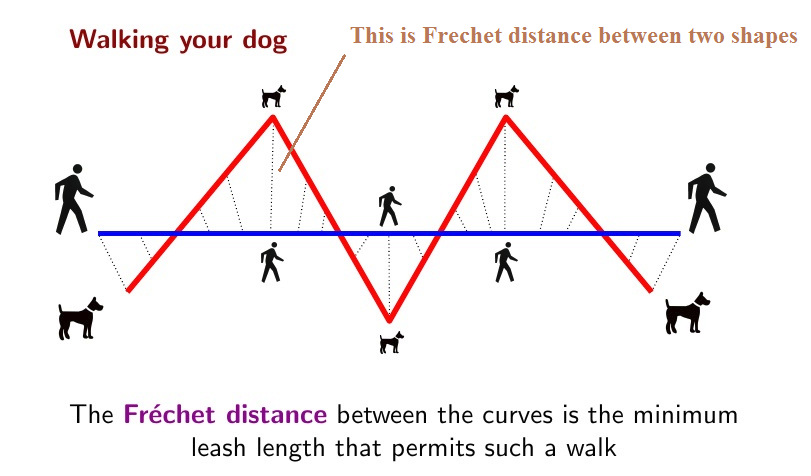

In [9]:
Image('_img/frechet.png', embed=True, width=500)

### Dynamic Time Warping

Compares phased-in geometry/sequence distance.

https://en.wikipedia.org/wiki/Dynamic_time_warping

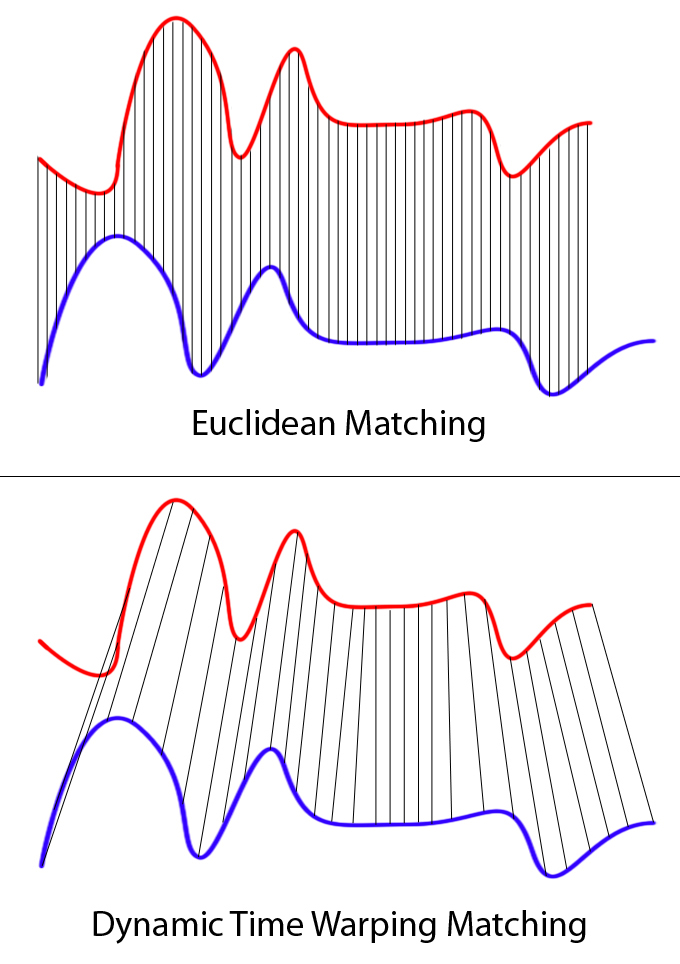

In [10]:
Image('_img/dtw.png', embed=True, width=300)

### Centroid distance

Calculates distance between geometry centroids/centers-of-mass

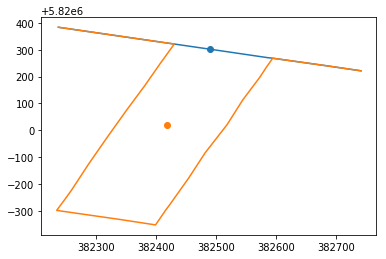

In [11]:
l1 = test_detour_big_very_short_1.to_linestring(convert_to_utm=True)
l2 = test_detour_big_very_short_2.to_linestring(convert_to_utm=True)
plt.plot(*zip(*l1.coords))
plt.plot(*zip(*l2.coords))
plt.scatter(l1.centroid.x, l1.centroid.y)
plt.scatter(l2.centroid.x, l2.centroid.y)

### AUC

Calculates area defined between the two geometries/curves.

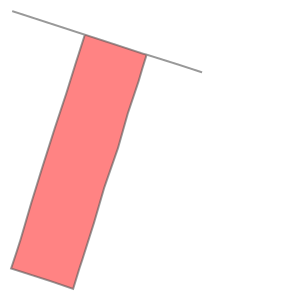

In [12]:
utm_linestring_1 = test_detour_big_very_short_1.to_linestring(convert_to_utm=True)
utm_linestring_2 = test_detour_big_very_short_2.to_linestring(convert_to_utm=True)
sg.Polygon(list(utm_linestring_1.coords) + list(utm_linestring_2.coords)[::-1])

### AUC normalized

Calculates area defined between the two geometries/curves and normalizes it by envelope containing both geometries.

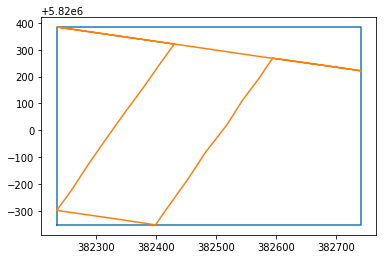

In [2]:
utm_linestring_1 = test_detour_big_very_short_1.to_linestring(convert_to_utm=True)
utm_linestring_2 = test_detour_big_very_short_2.to_linestring(convert_to_utm=True)
polygon = sg.Polygon(list(utm_linestring_1.coords) + list(utm_linestring_2.coords)[::-1])
plt.plot(*zip(*list(polygon.envelope.boundary.coords)))
plt.plot(*zip(*list(polygon.boundary.coords)))

### BOCS (Bias-Outlier Composite Score)

Geometric mean of max distance and total AUC.

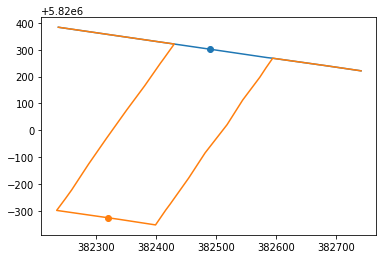

In [3]:
l1 = test_detour_big_very_short_1.to_linestring(convert_to_utm=True)
l2 = test_detour_big_very_short_2.to_linestring(convert_to_utm=True)
plt.plot(*zip(*l1.coords))
plt.plot(*zip(*l2.coords))
plt.scatter(l1.centroid.x, l1.centroid.y)
plt.scatter(l2.coords[13][0] + 85, l2.coords[13][1] - 28)

### PMR (Point Match Ratio)

% of points close enough to other geometry

'All points:'

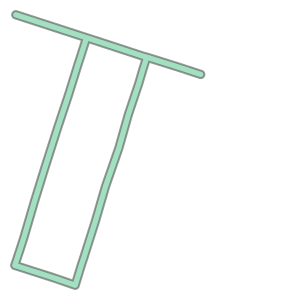

'Point matches:'

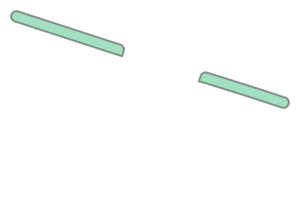

In [7]:
corridor_1 = utm_linestring_1.buffer(10)
corridor_2 = utm_linestring_2.buffer(10)

display('All points:')
display(corridor_1.union(corridor_2))
display('Point matches:')
display(corridor_1.intersection(corridor_2))

### Levenshtein (edit) distance

Minimum number of edits required to transform encoded polyline of one to the other.

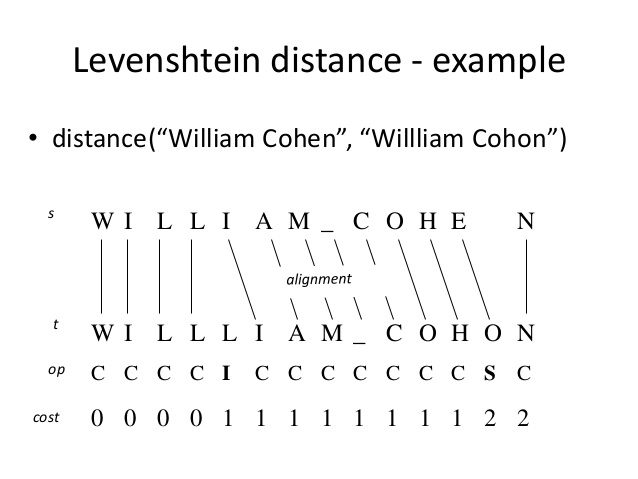

In [8]:
Image('_img/levensthein.png', embed=True, width=400)

## Results

### Synthetic test results

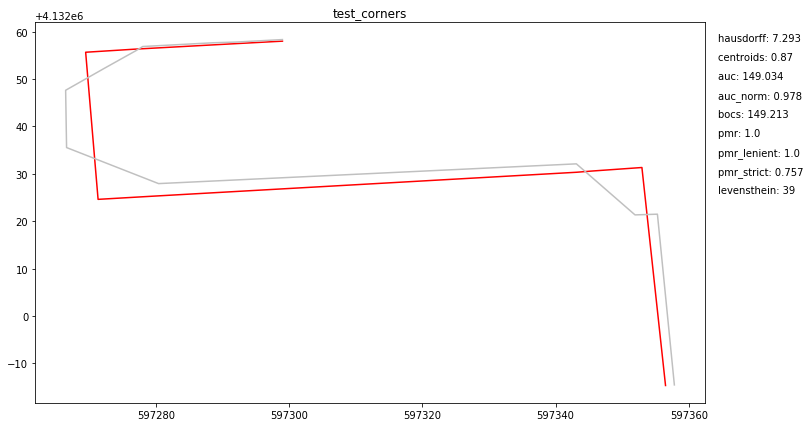

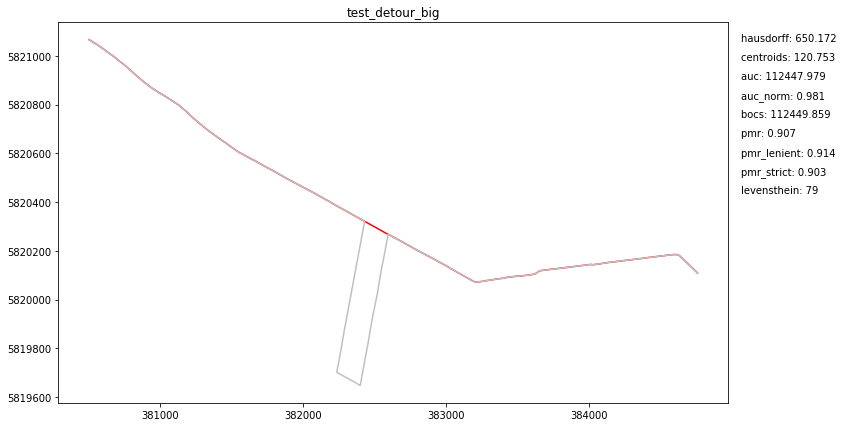

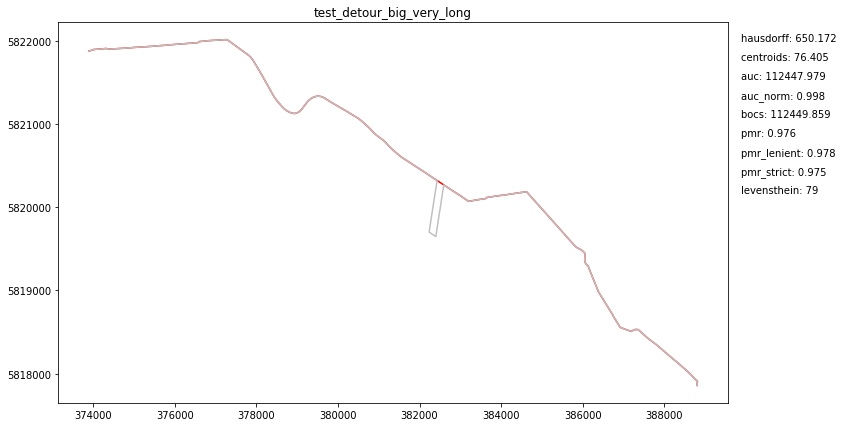

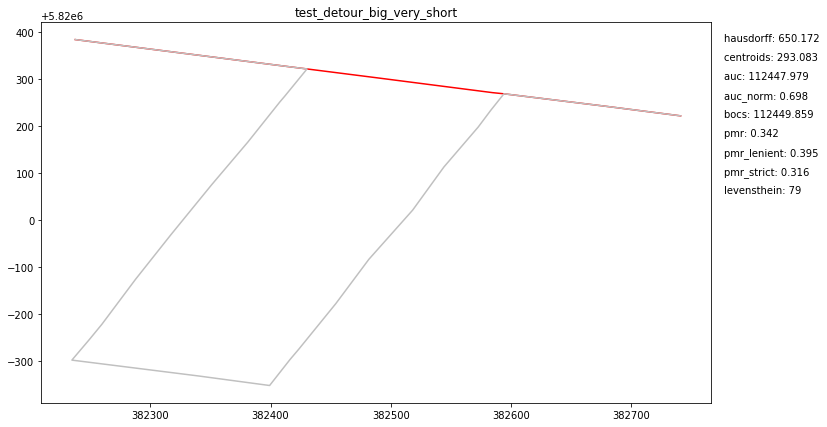

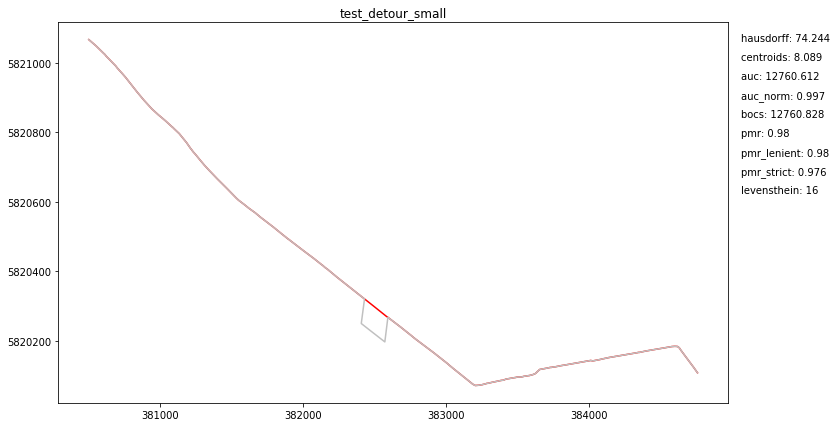

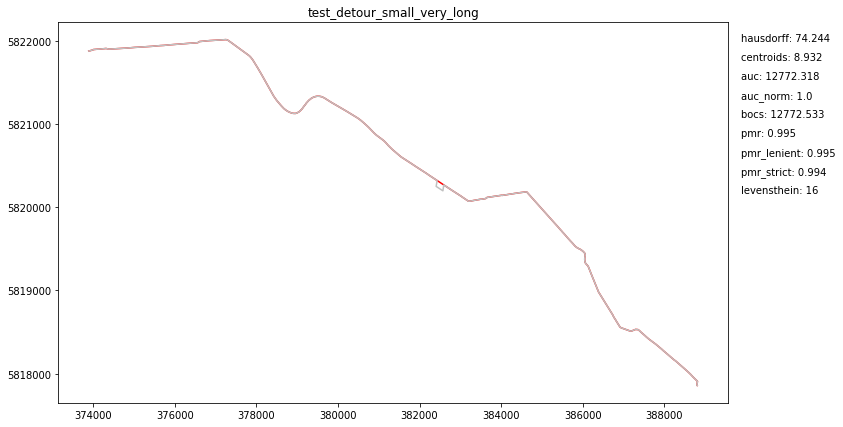

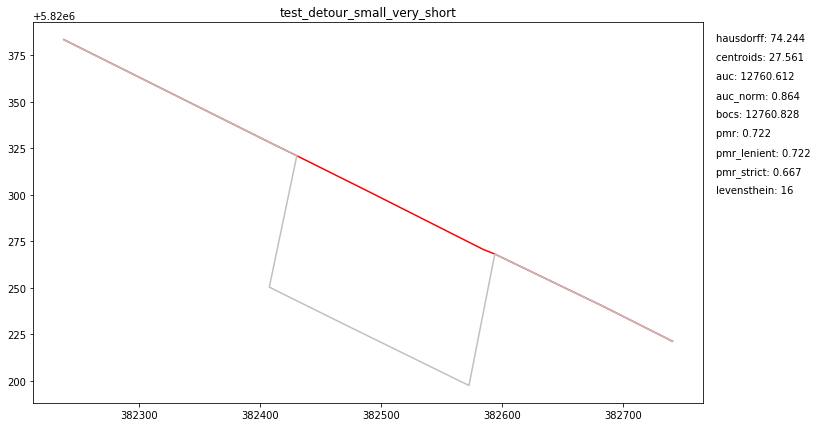

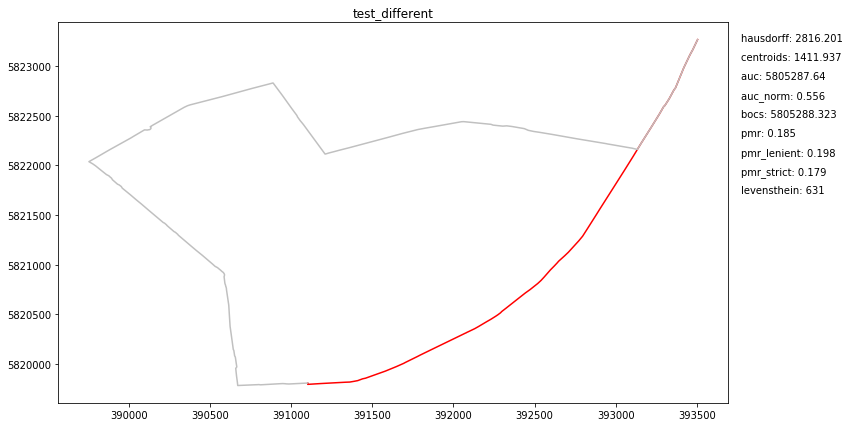

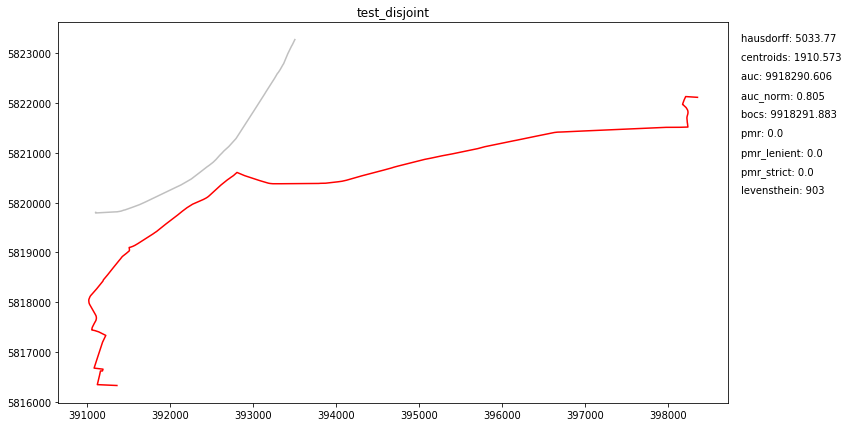

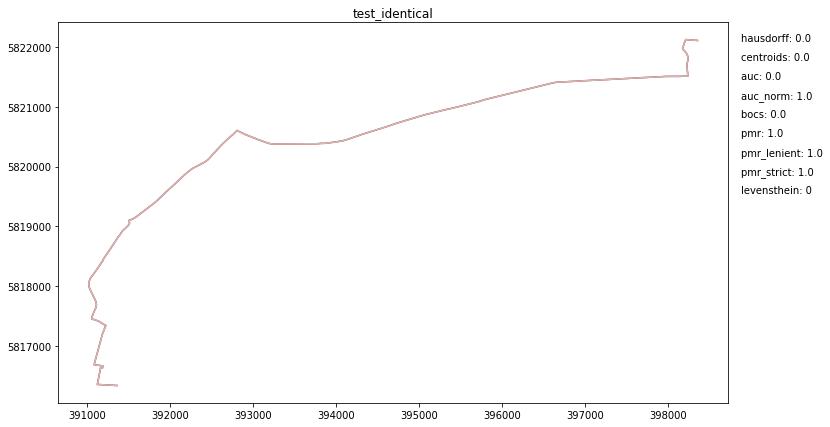

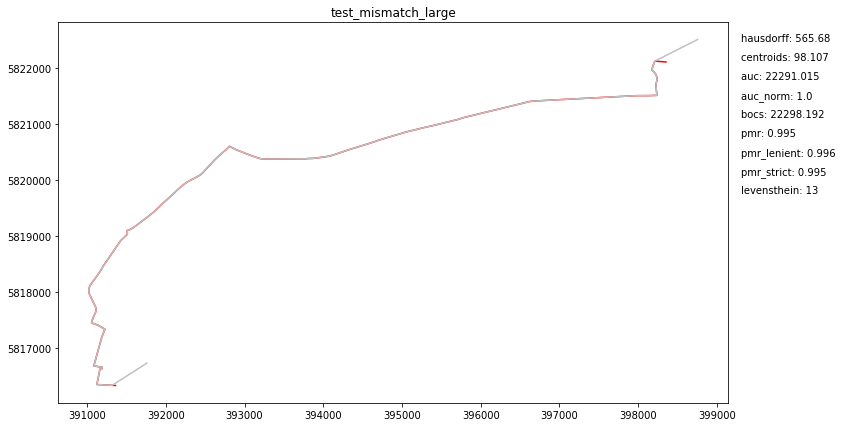

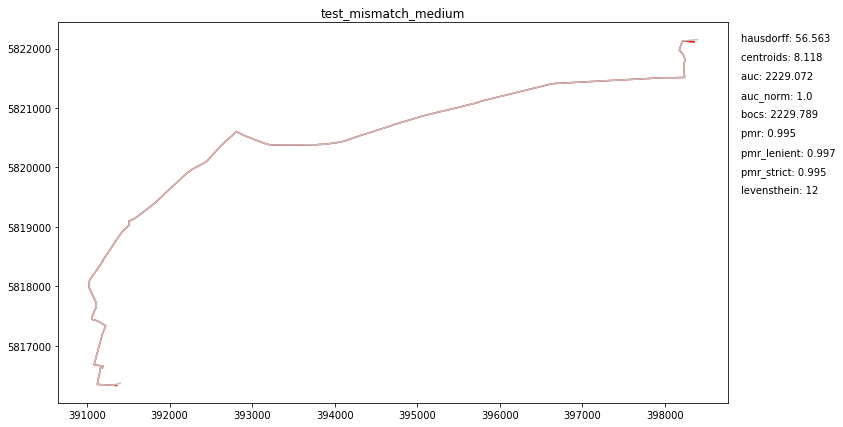

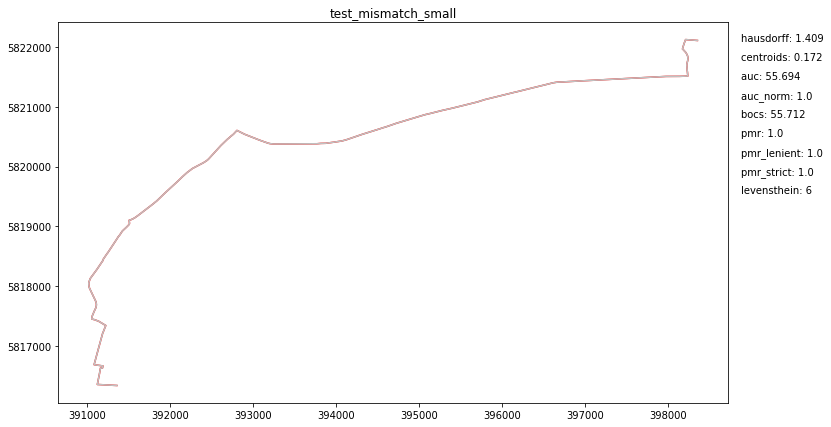

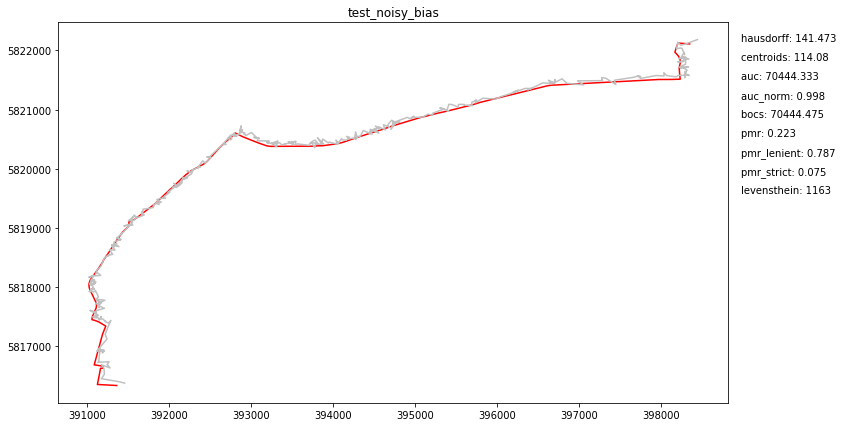

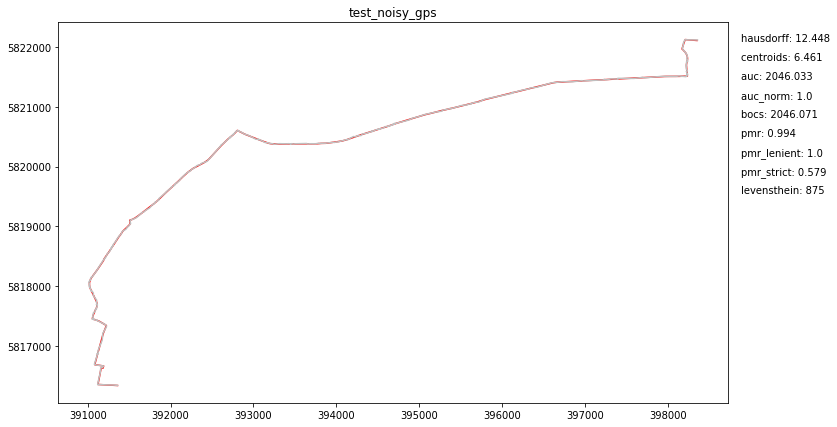

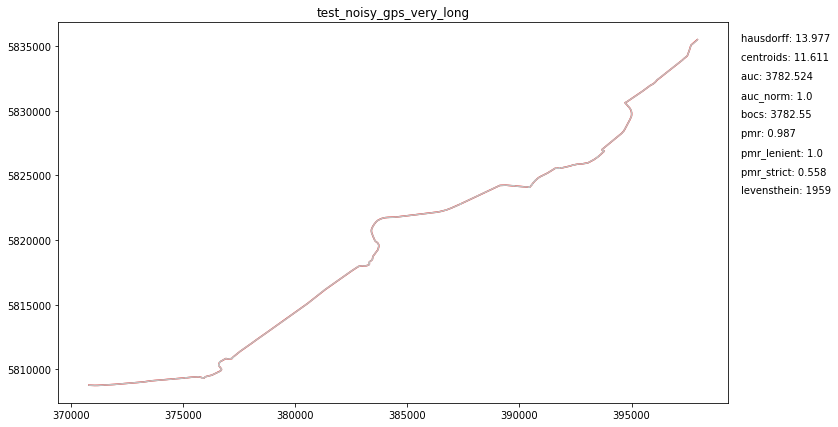

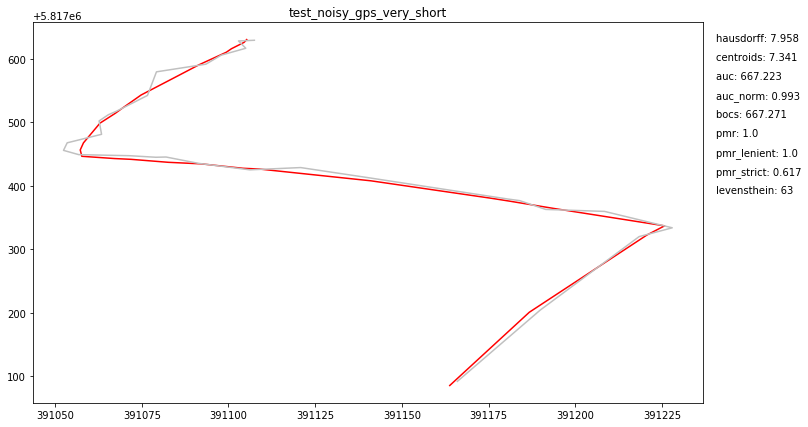

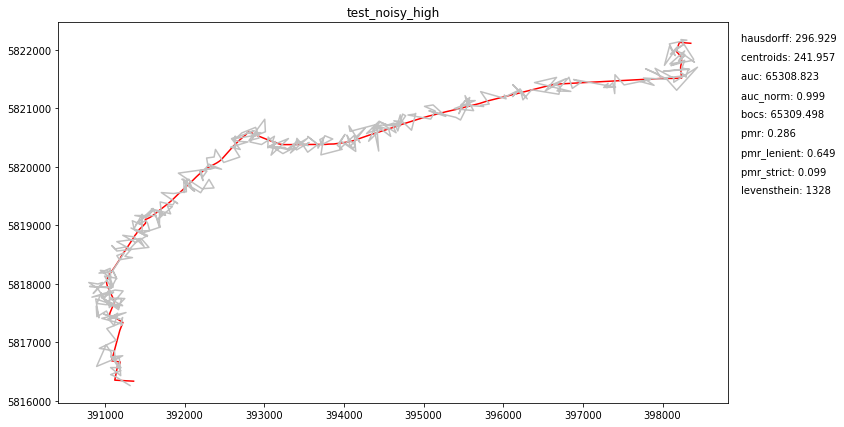

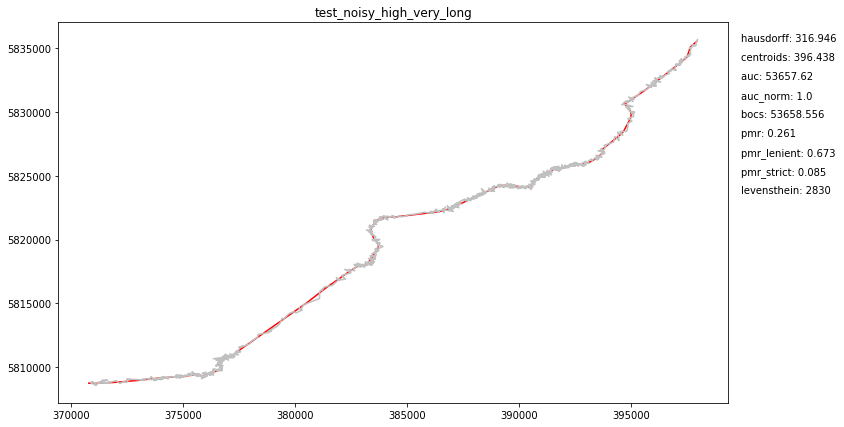

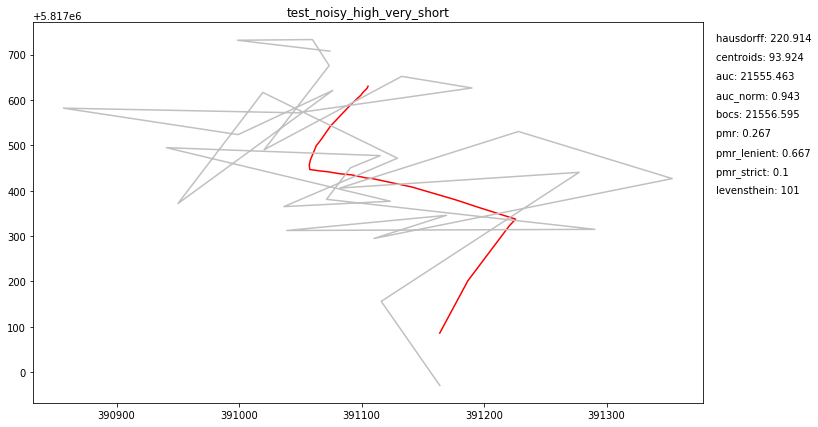

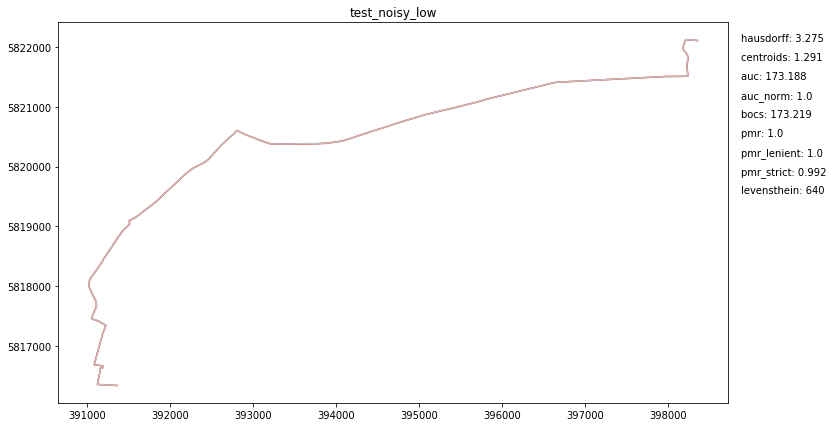

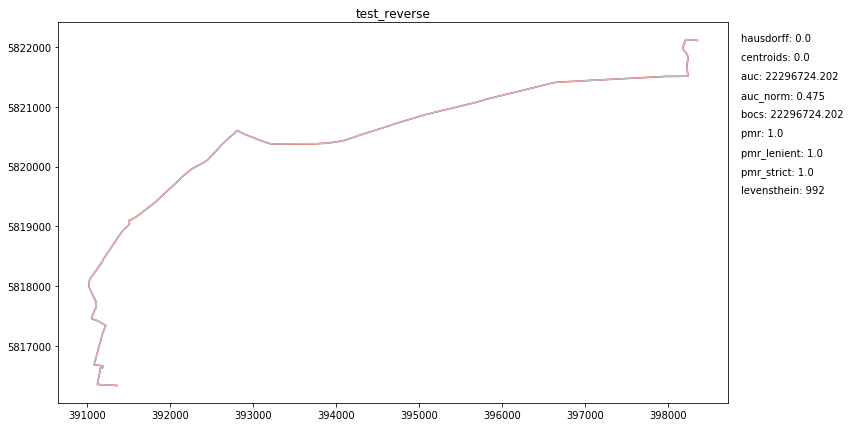

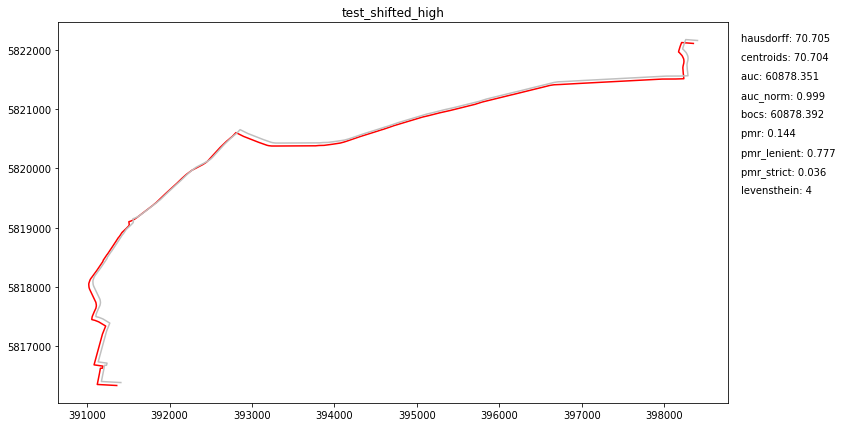

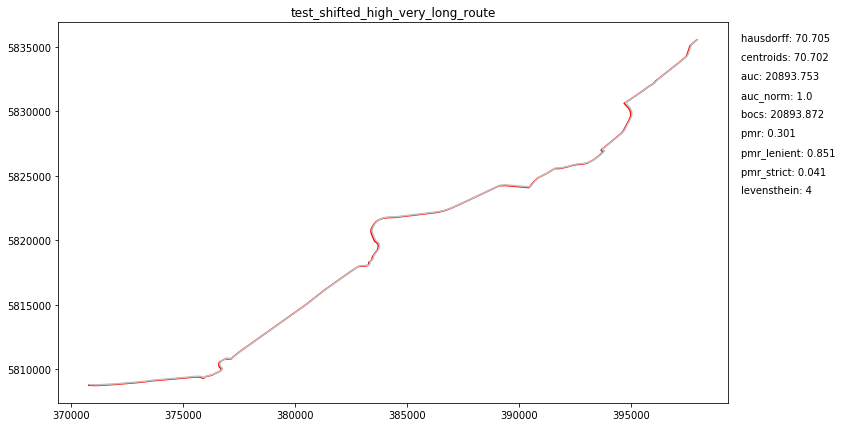

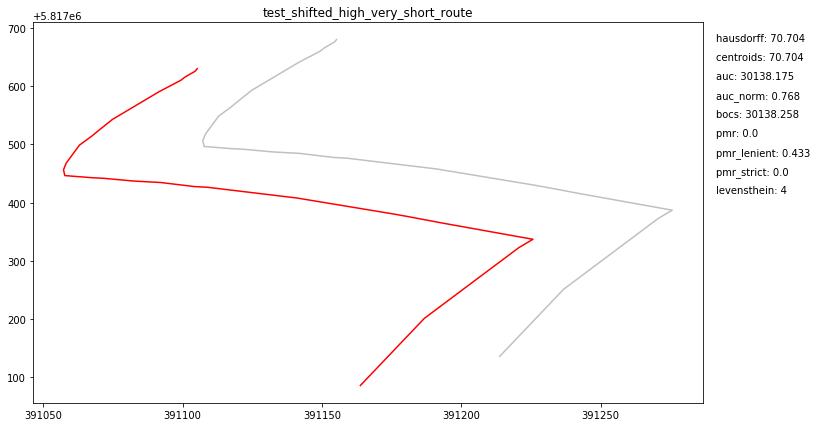

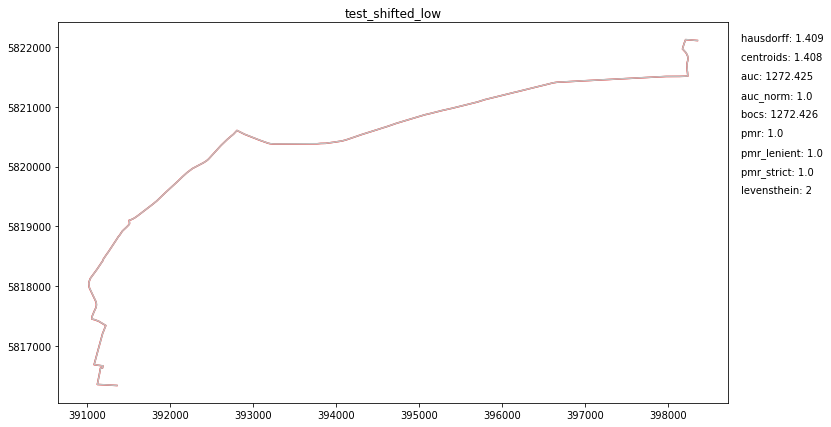

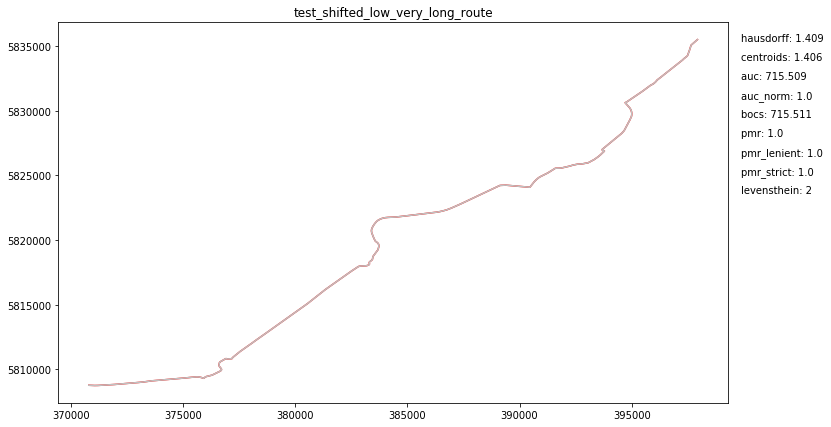

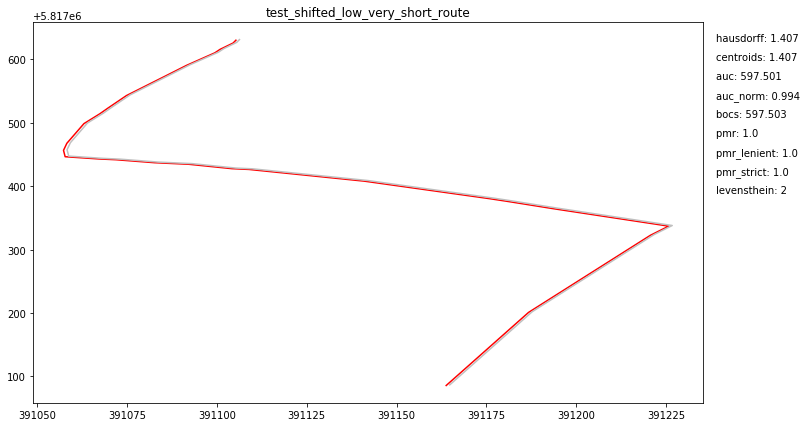

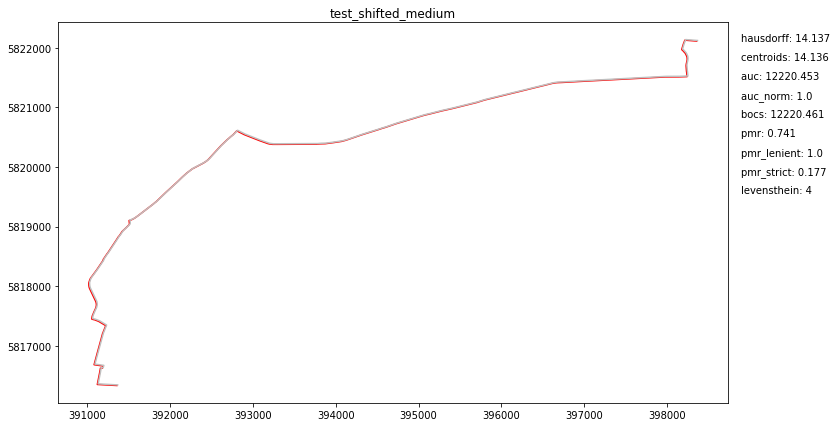

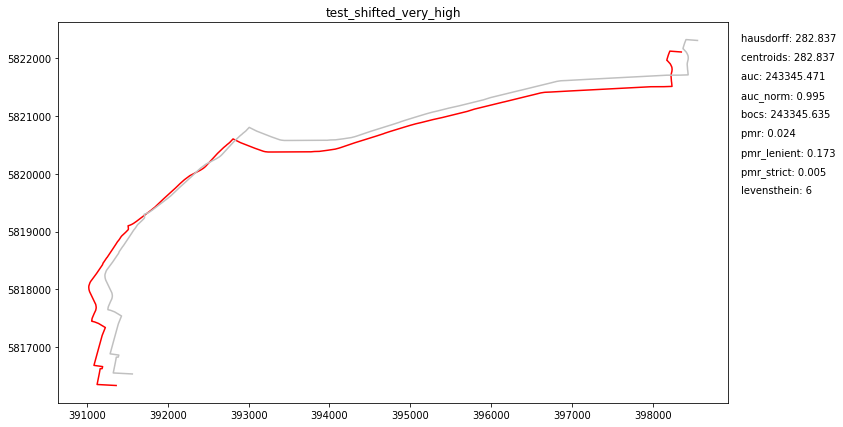

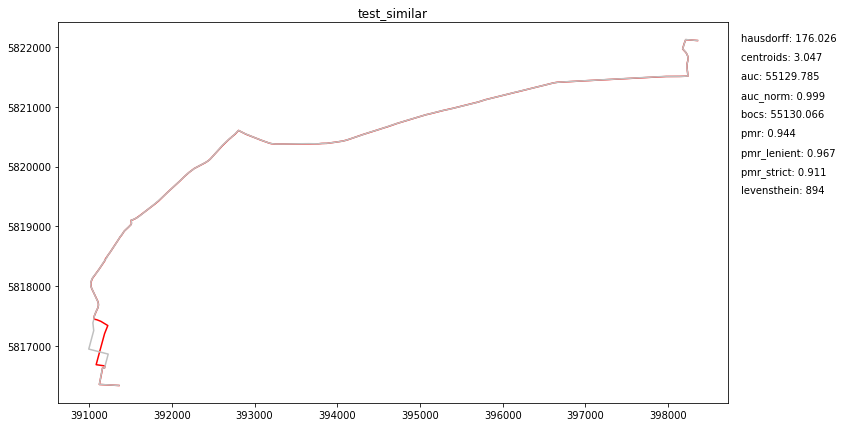

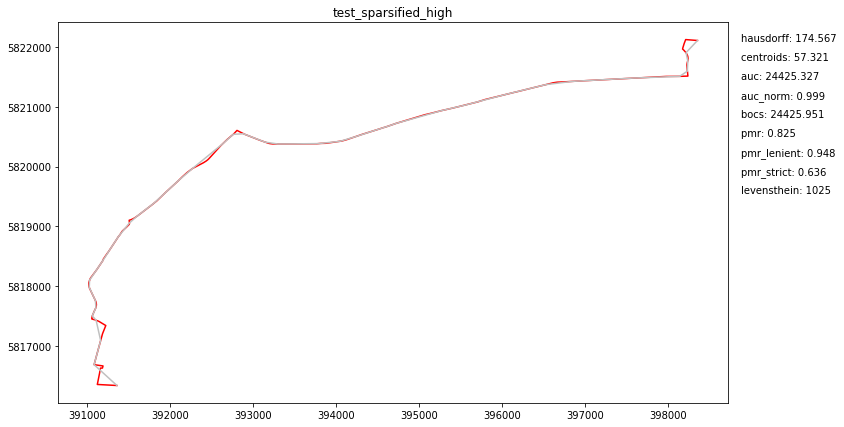

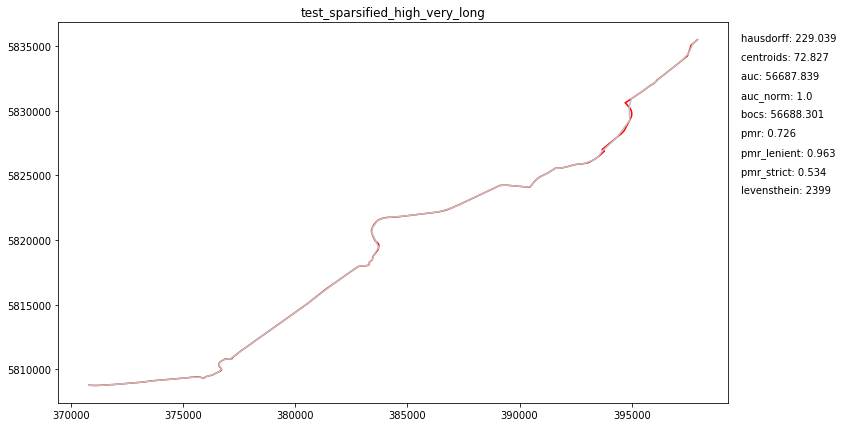

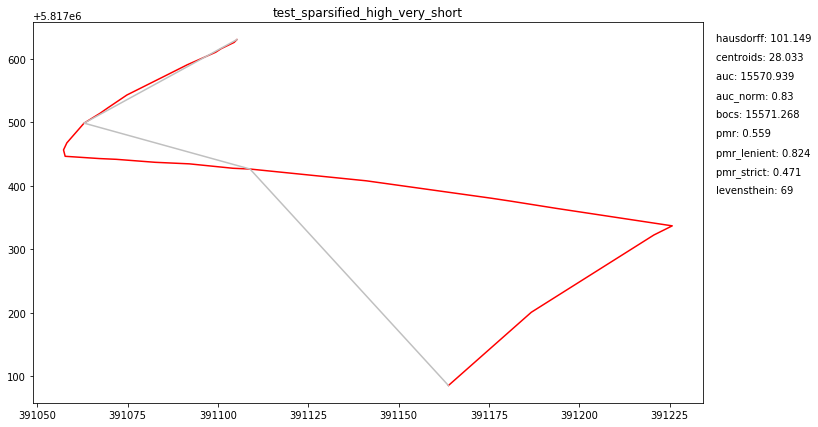

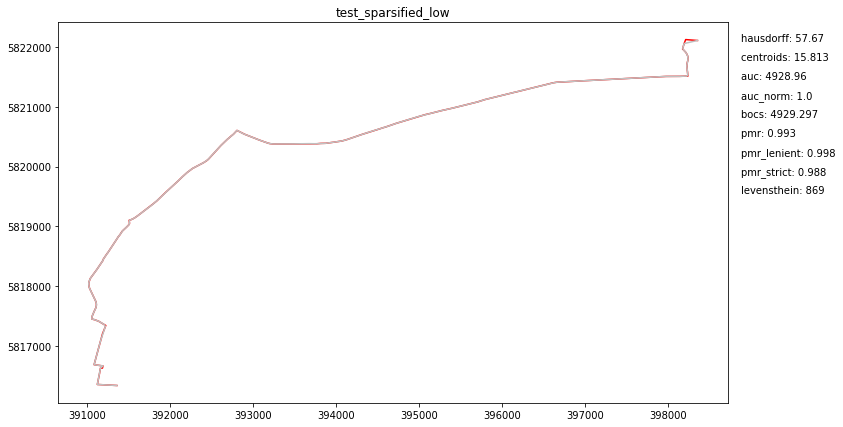

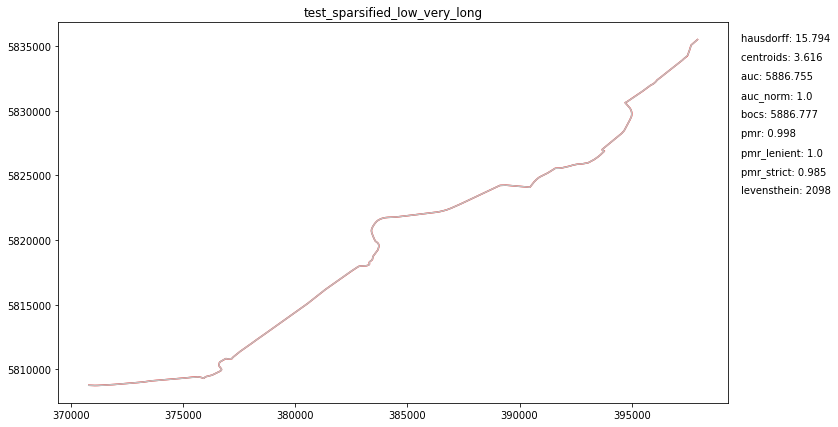

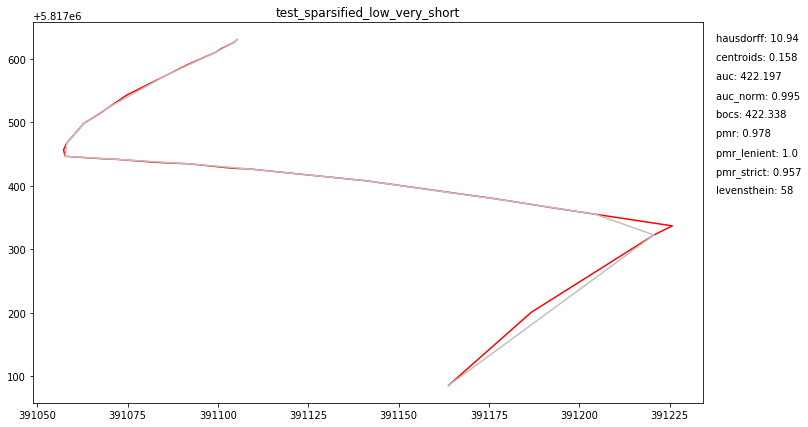

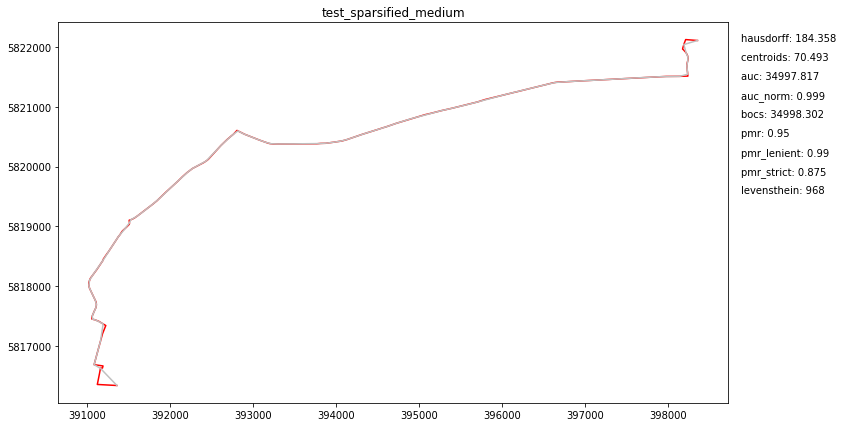

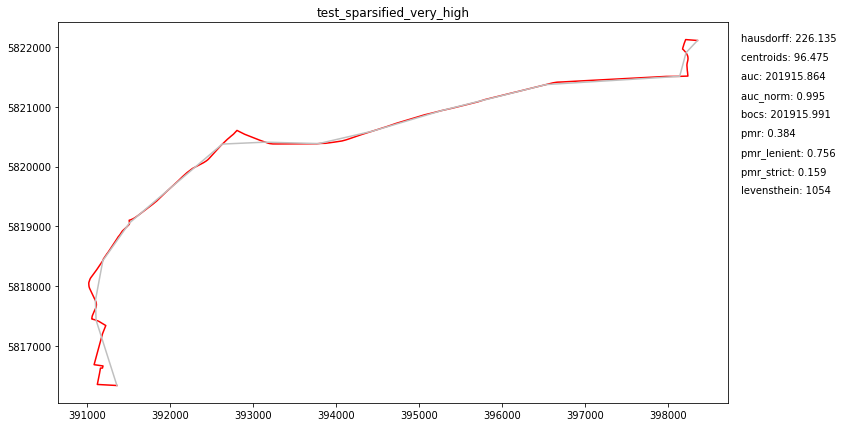

In [10]:
configs = {
    'hausdorff': {'name': 'hausdorff', 'params': {}},    
    # TOO SLOW 'frechet': {'name': 'frechet', 'params': {}}, 
    # TOO SLOW 'dtw': {'name': 'dtw', 'params': {}},
    'centroids': {'name': 'centroids', 'params': {}},
    'auc': {'name': 'auc', 'params': {}},
    'auc_norm': {'name': 'auc', 'params': {'normalized': True}},
    'bocs': {'name': 'bocs', 'params': {}},
    'pmr': {'name': 'pmr', 'params': {}},
    'pmr_lenient': {'name': 'pmr', 'params': {'buffer': 50}},
    'pmr_strict': {'name': 'pmr', 'params': {'buffer': 3}},
    'levensthein': {'name': 'levenshtein', 'params': {}},
}

tests = sorted(glob.glob('data/*.json'))
results = run_tests(tests, configs)
df = pd.DataFrame(results).transpose()

### Analysis

* Hausdorff
    * Quite reliable for most cases
    * Too sensitive to severe outliers (start/end mismatches, bad GPS fixes)
* Frechet:
    * Way too slow
* DTW:
    * Way too slow
* Centroids:
    * Way too sensitive to scaling (very long routes will dilute severe differences)
* AUC:
    * Way too sensitive to scaling (very long routes will dilute severe differences)
* AUC normalized:
    * Way too sensitive to shape of inscribing rectangle
* BOCS:
    * Very hard to interpret
* PMR:
    * Very interpretable
    * Does not code severity of differences too well
    * Sensitive to geometry sampling
* Levenshtein:
    * Difficult to interpret
    * Too sensitive to geometry representation

__Score correlation__:

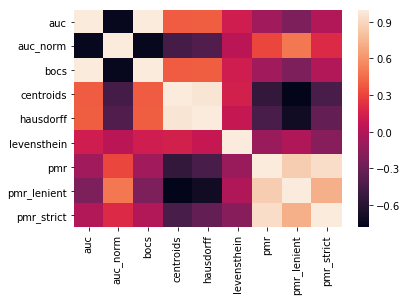

In [11]:
sns.heatmap(df.corr())

### Accuracy in real world cases

100 tests, Berlin coverage map, eliminating algos all but Hausdorff and PMR:

In [4]:
user, password = load_credentials('/home/pedro/.credentials/ldap.txt')

n = 100
route_plans = map(lambda i: RandomRouteGenerator().generate_route(berlin, identifier=i), range(n))

das = DasRouter(user=user, password=password)
das_traffic = DasRouter(user=user, password=password, traffic=True)
google = GoogleRouter()
providers = [das_traffic, google]

comparators = [GeometryComparator.compare_hausdorff, GeometryComparator.compare_pmr]

results = RouteHarvester().batch_calculate_routes(providers, 
                                                  route_plans, 
                                                  comparators=comparators, 
                                                  write_geojson='results')

results.write_to_csv('results/routes_comparison.csv')

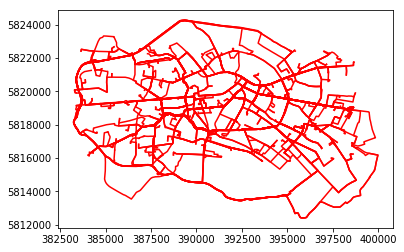

In [5]:
results_df = pd.read_csv('results/routes_comparison.csv')
plot_all(results_df)

__Results__:

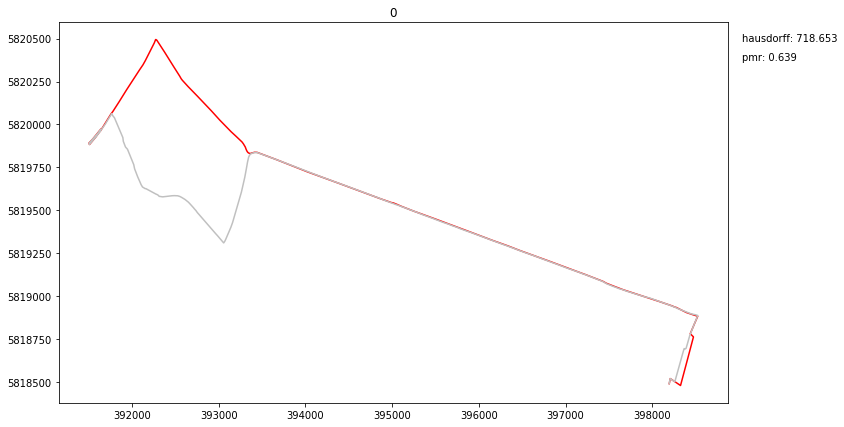

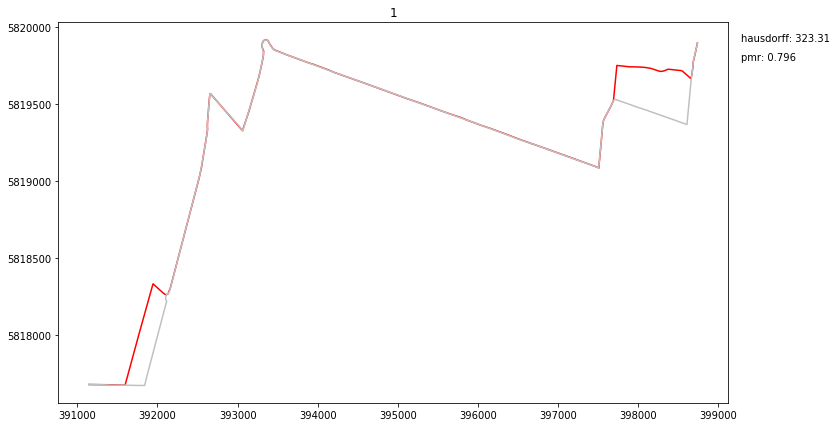

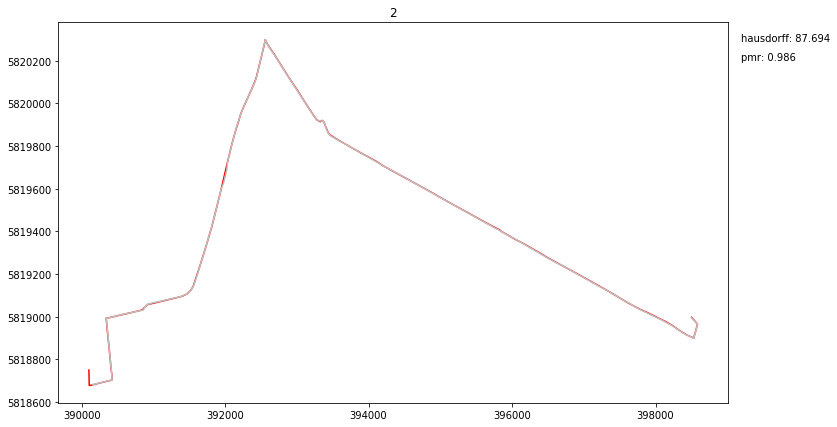

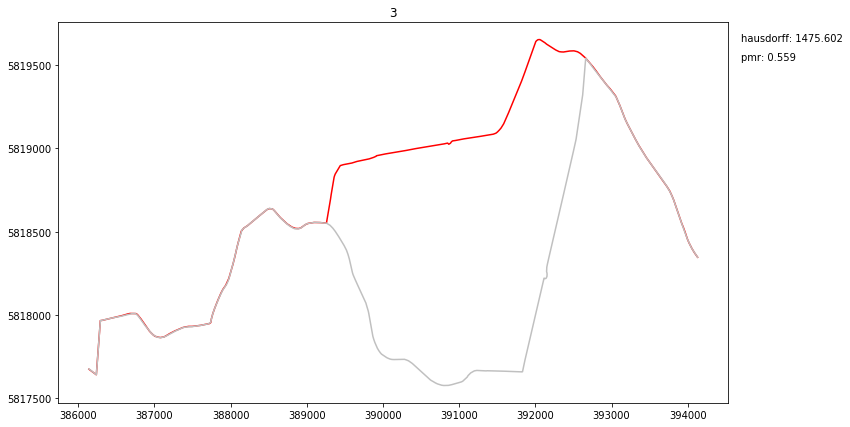

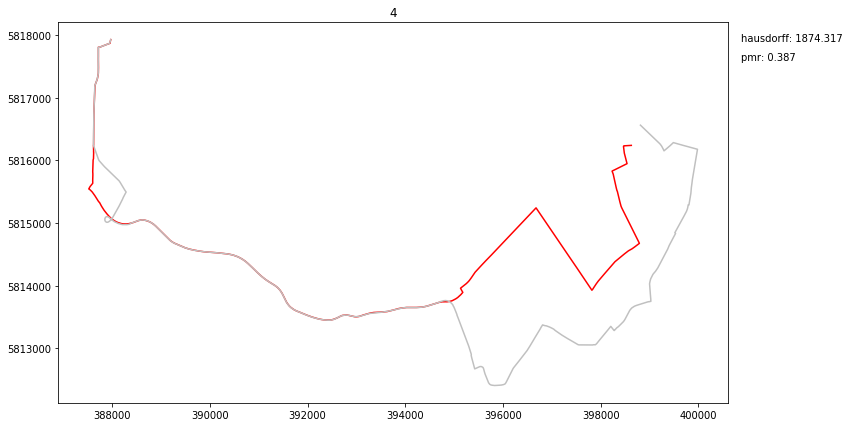

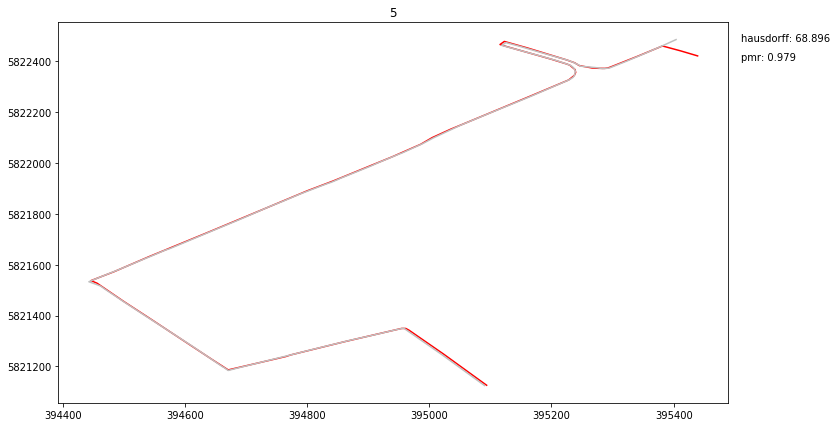

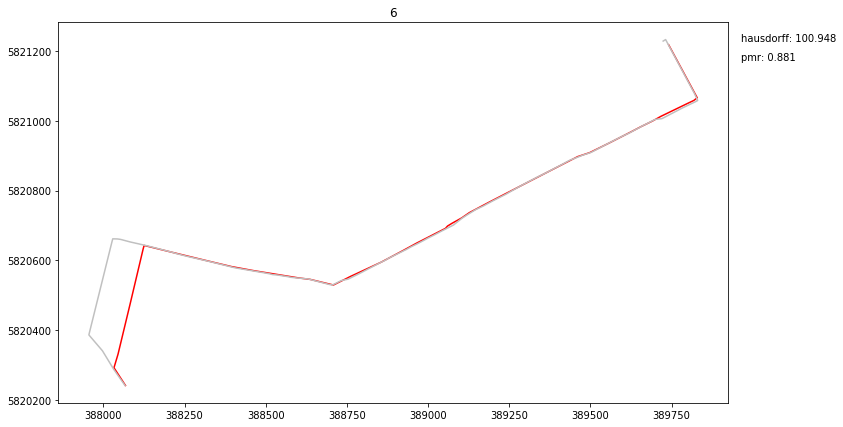

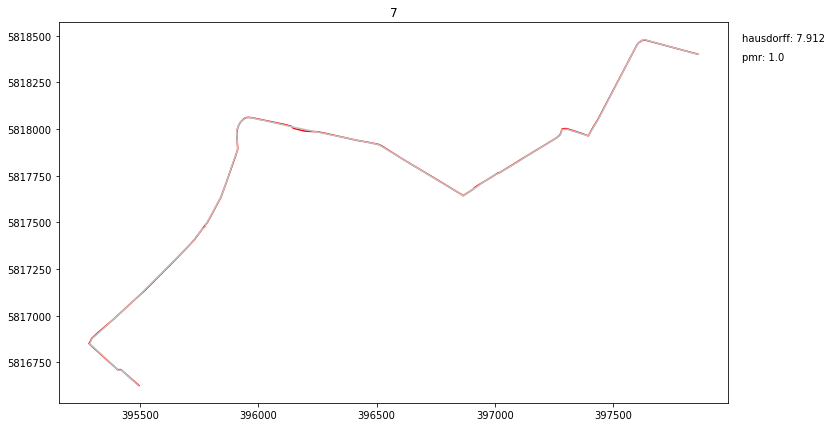

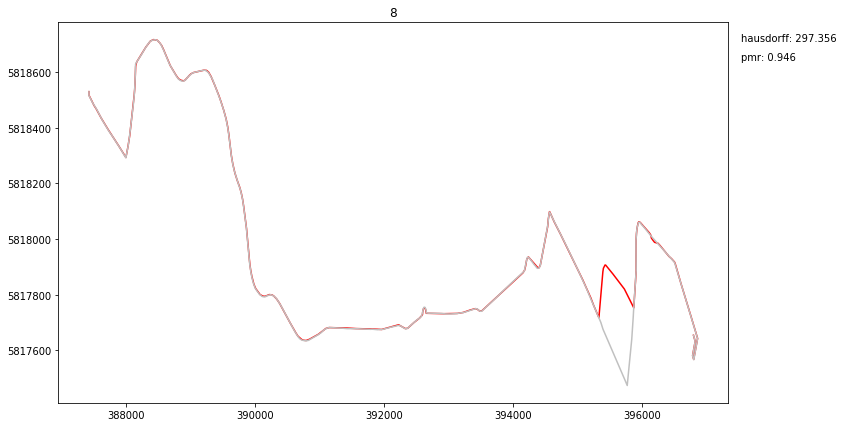

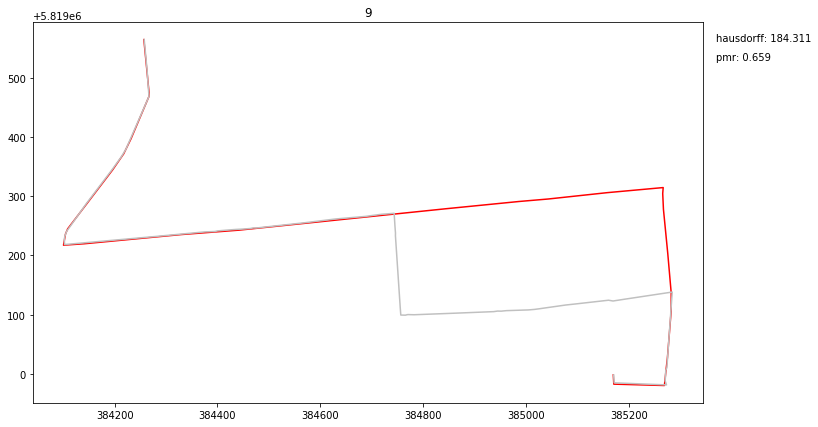

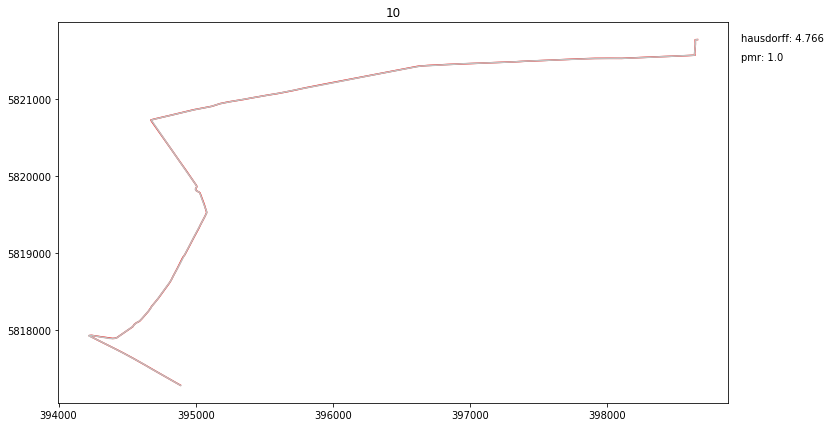

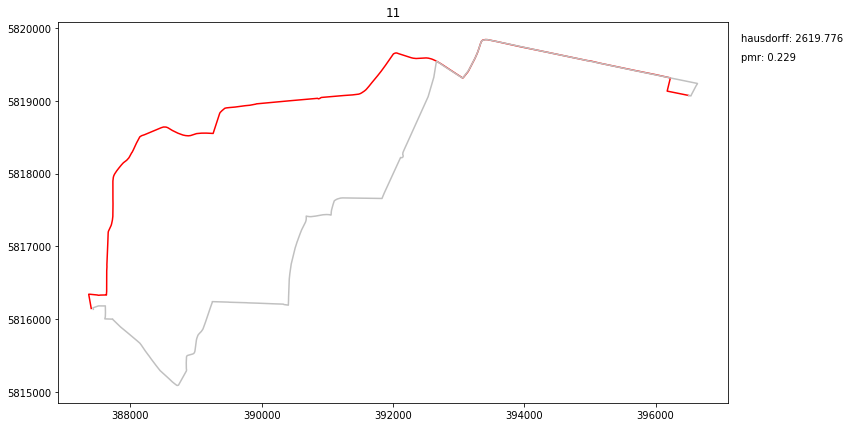

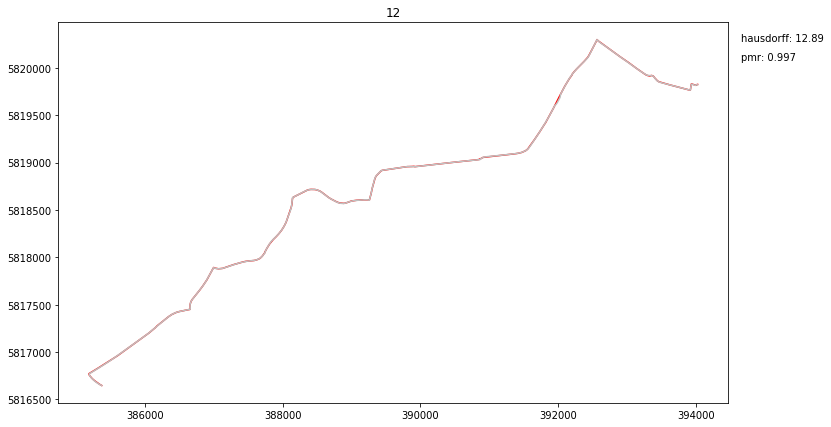

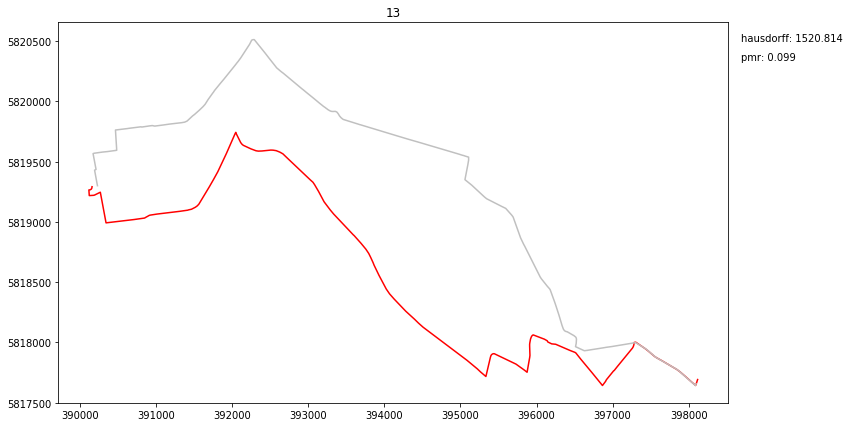

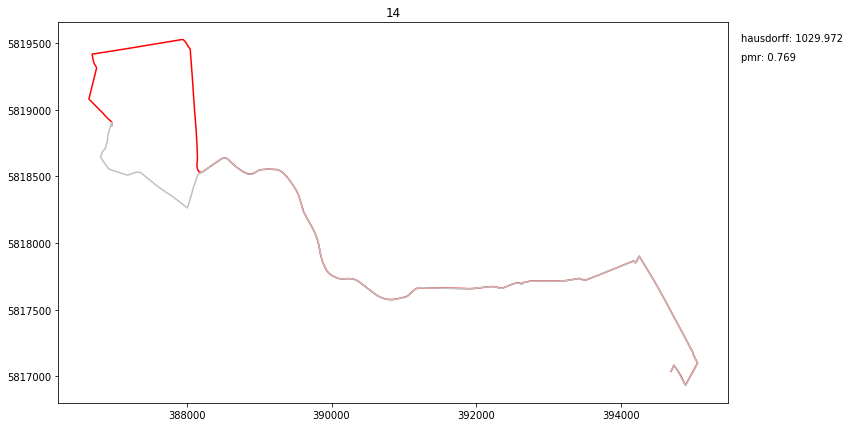

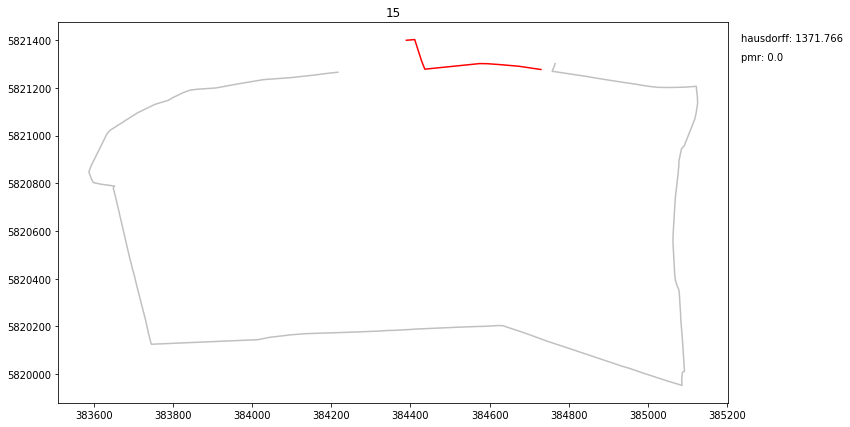

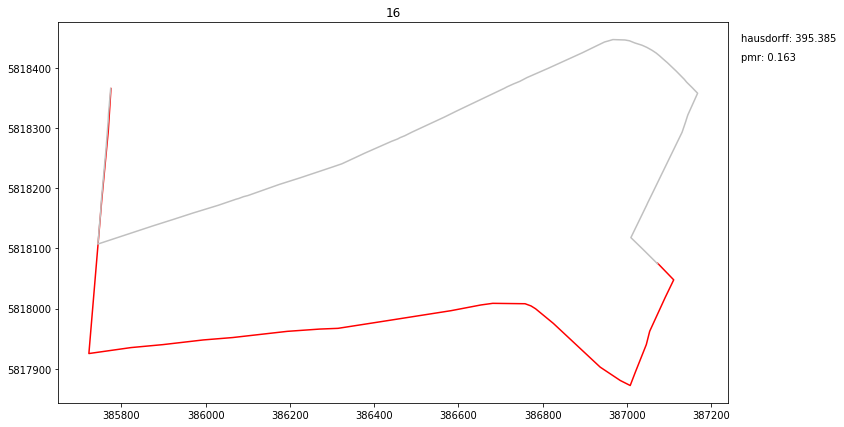

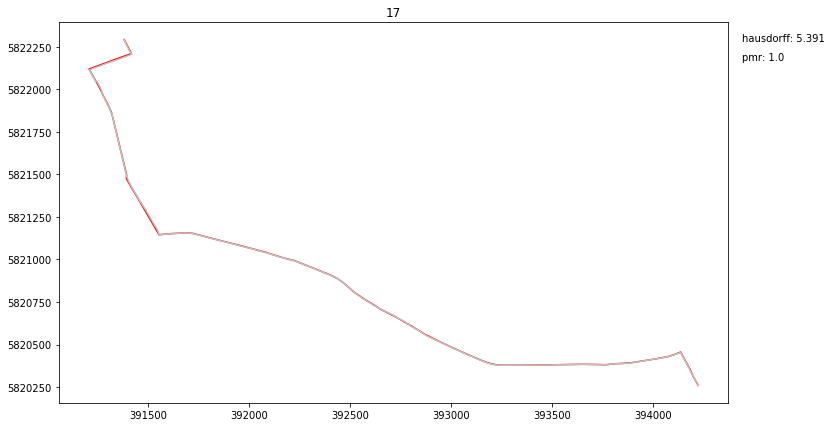

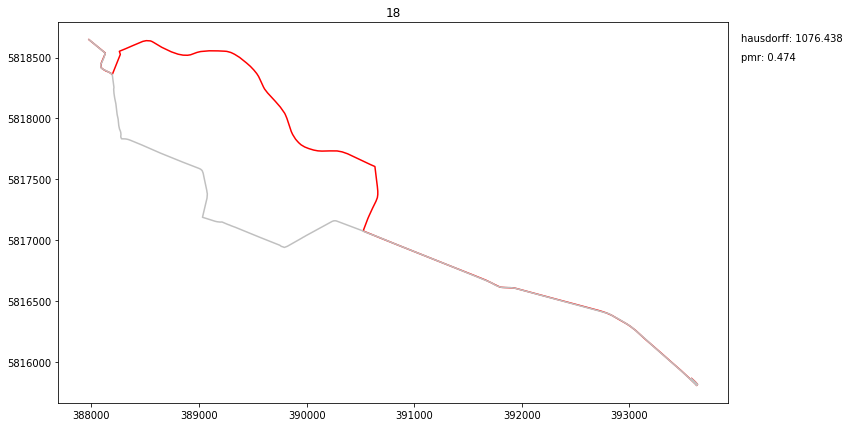

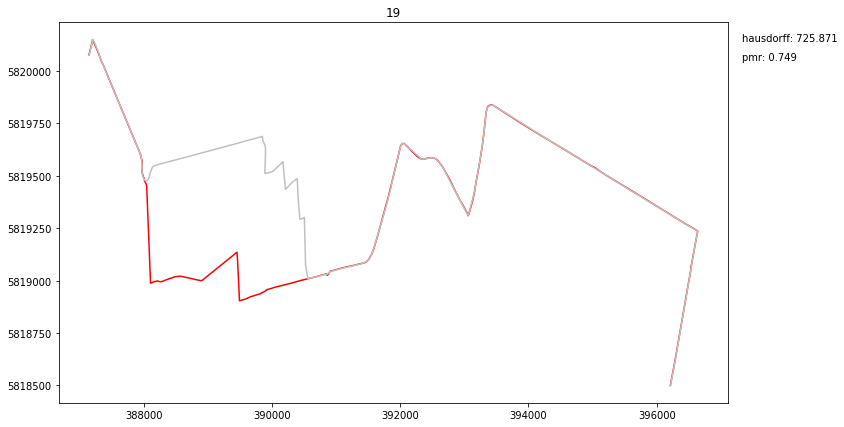

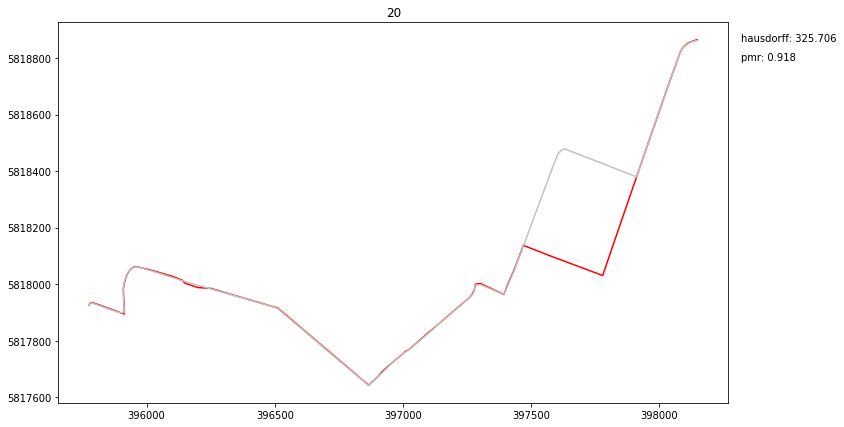

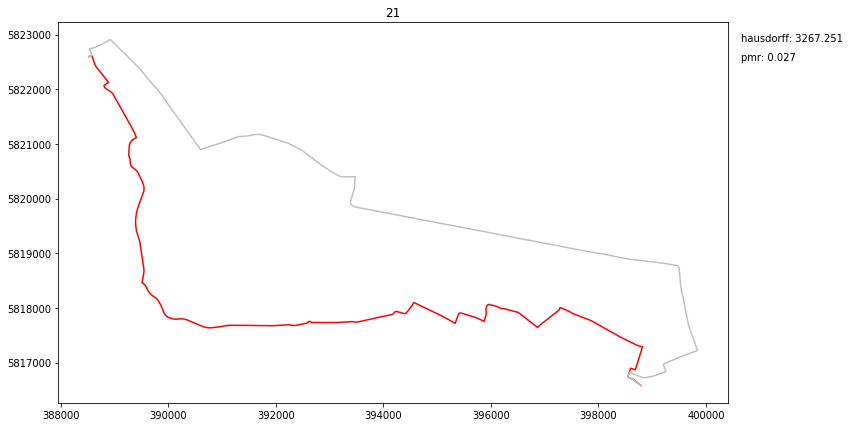

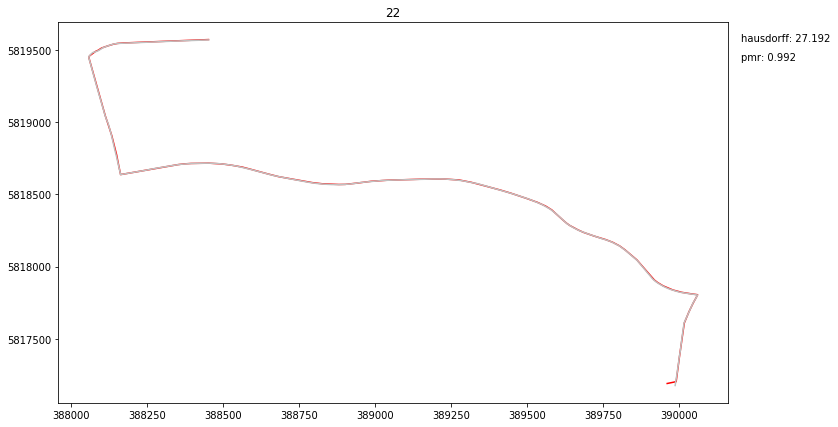

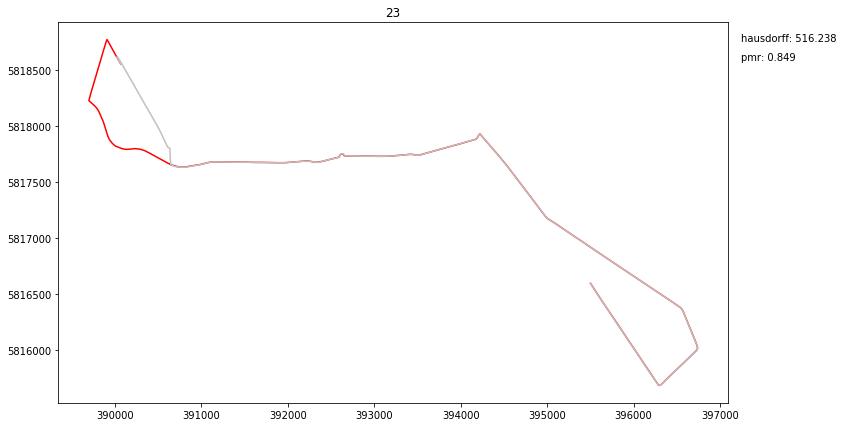

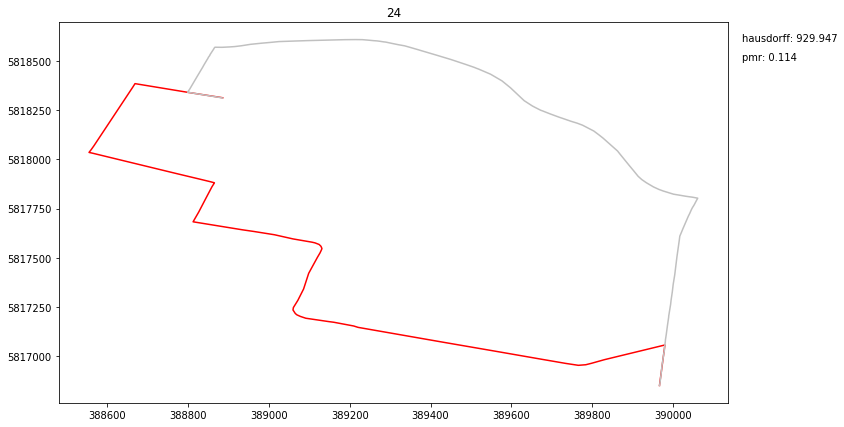

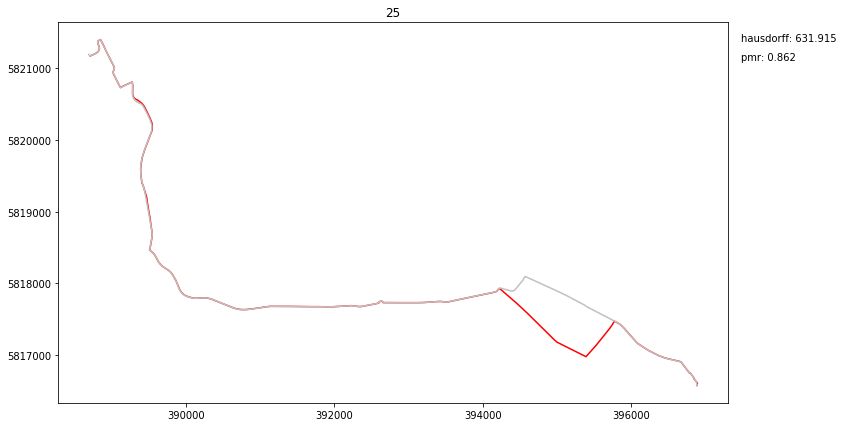

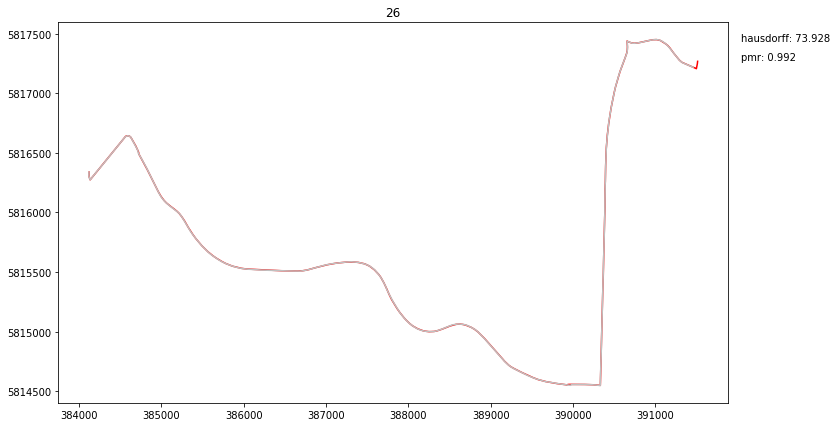

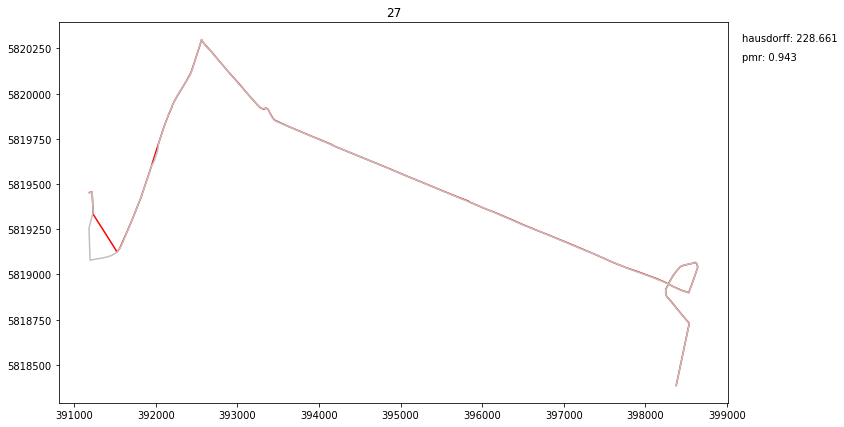

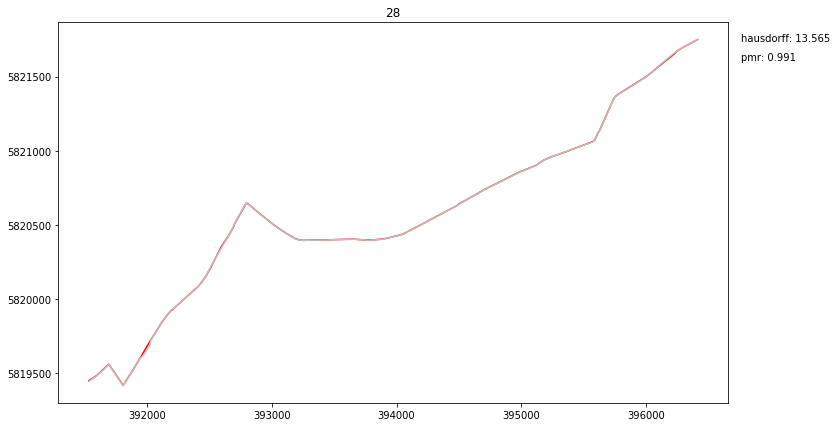

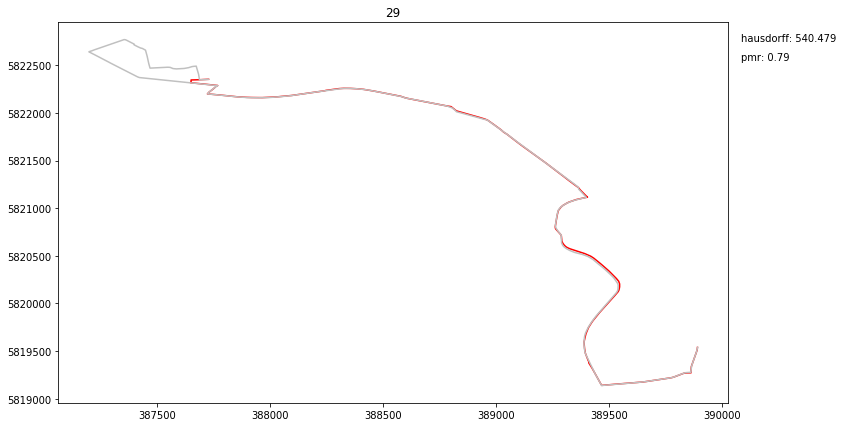

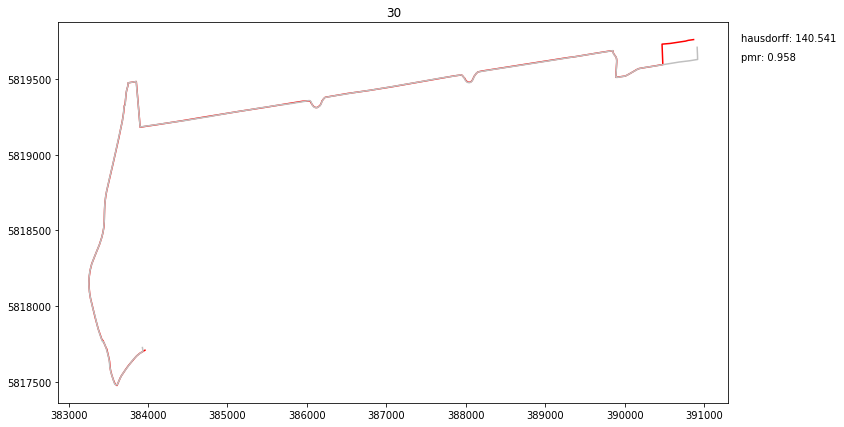

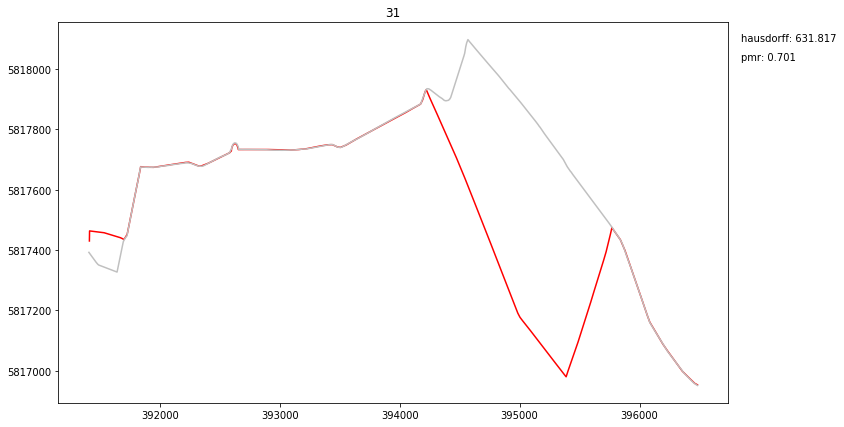

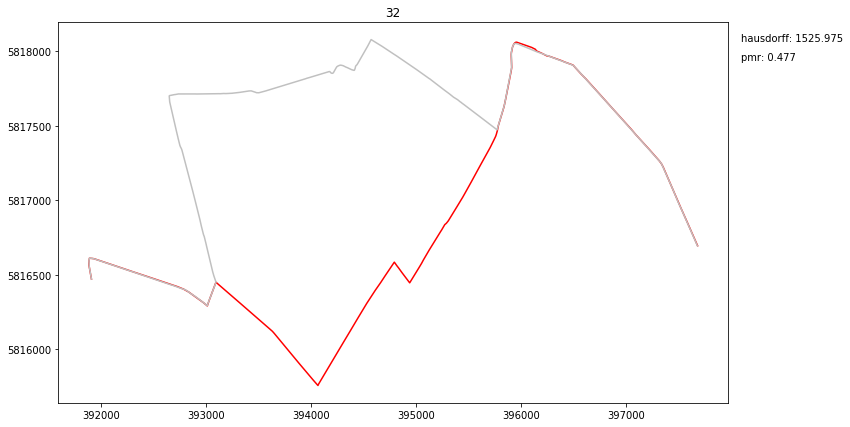

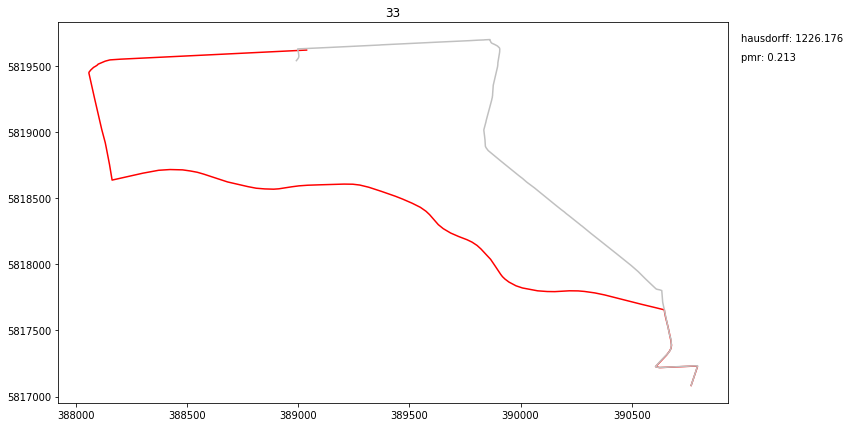

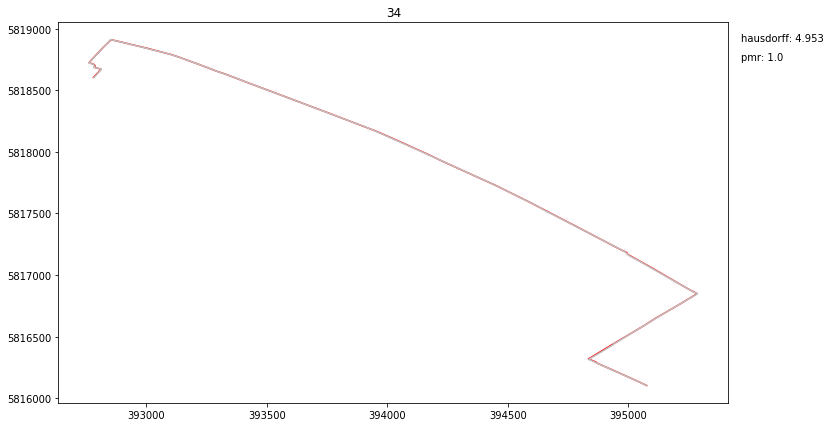

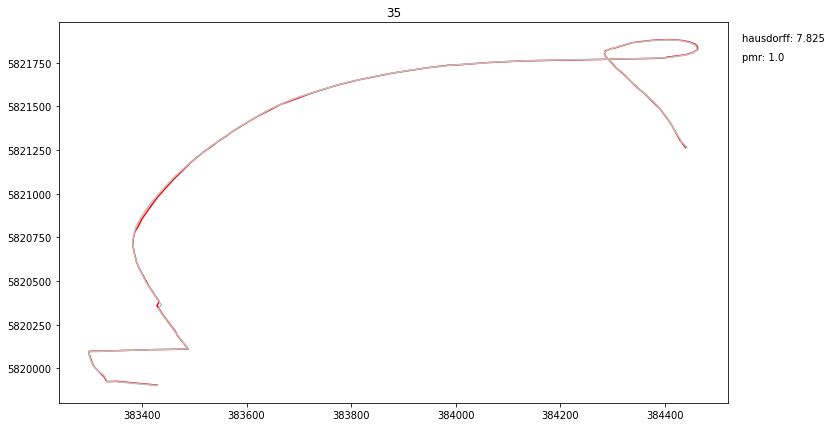

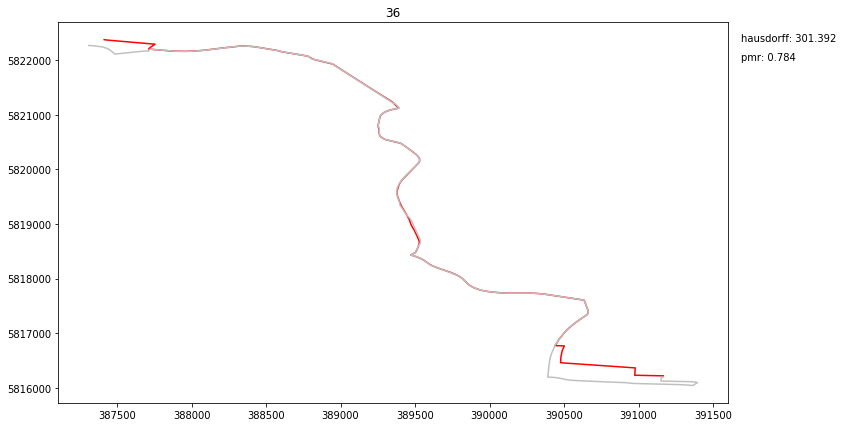

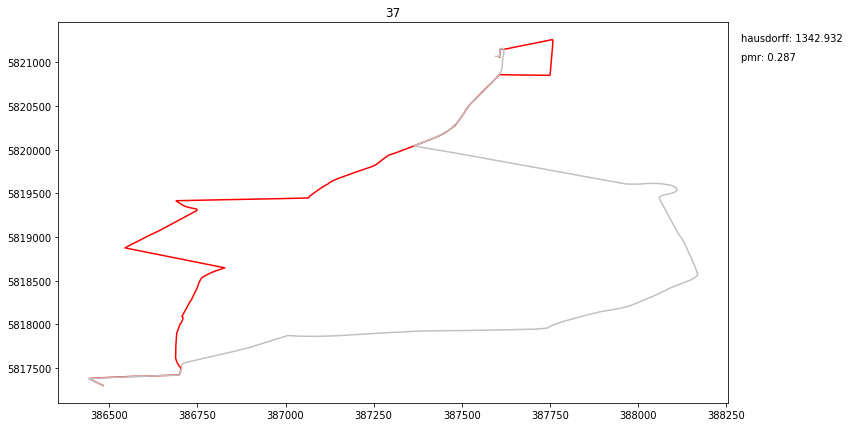

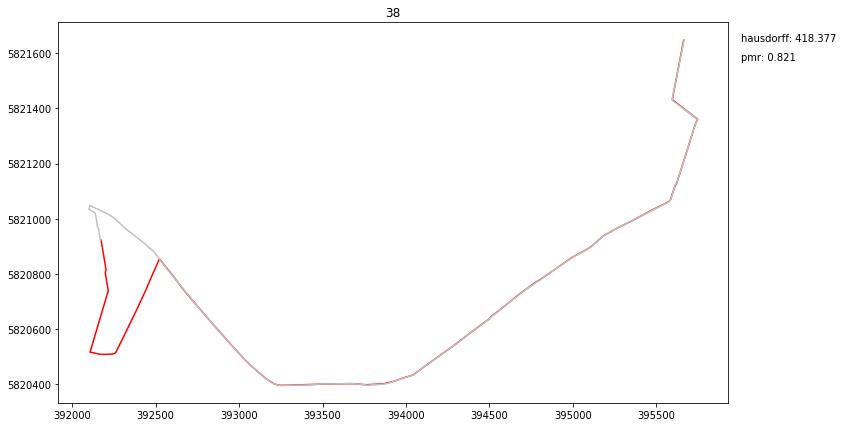

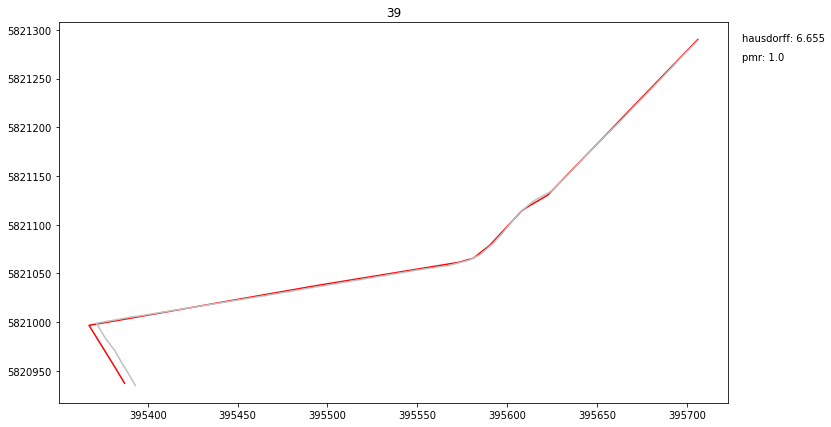

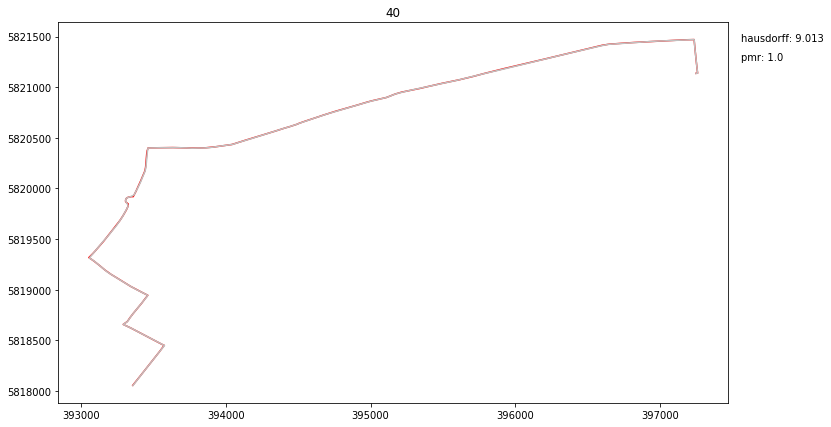

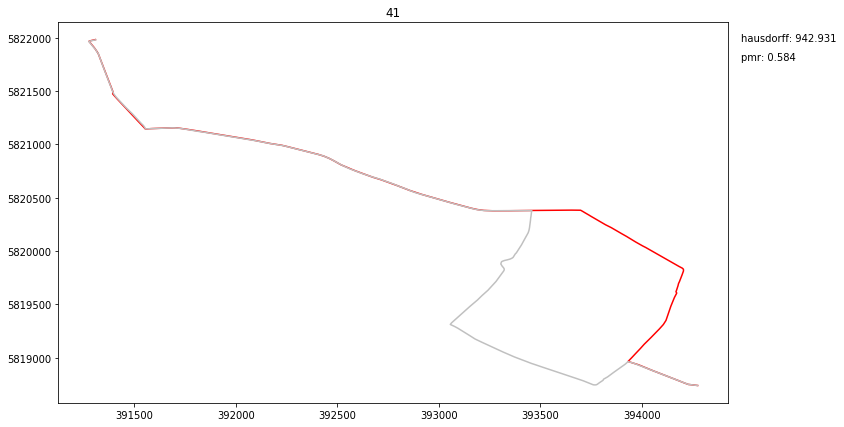

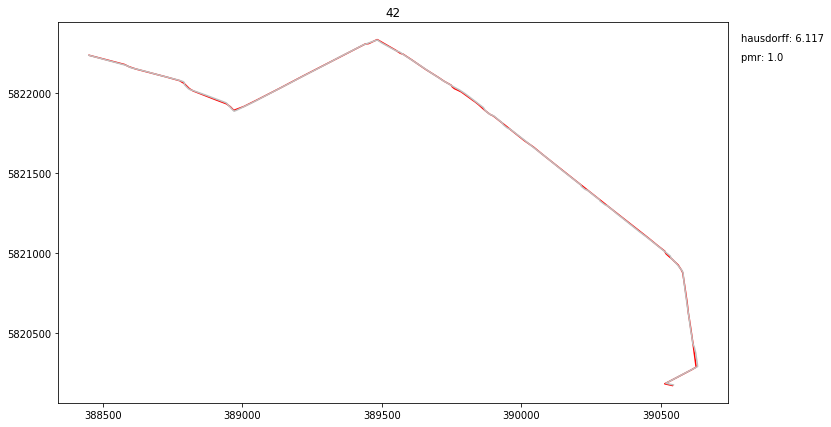

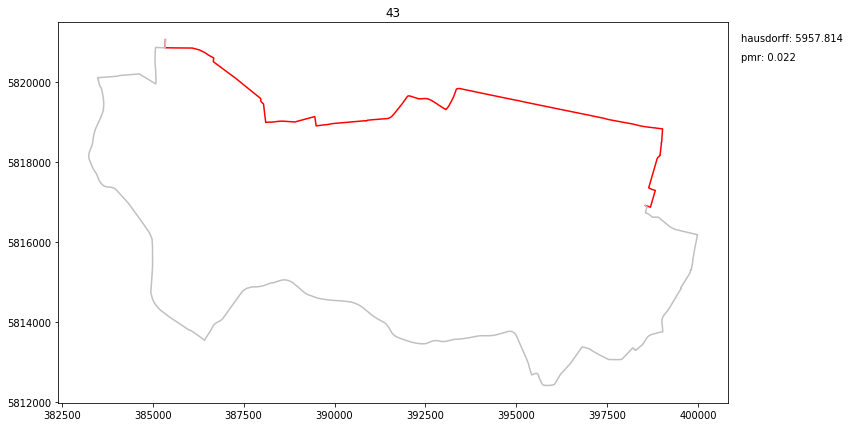

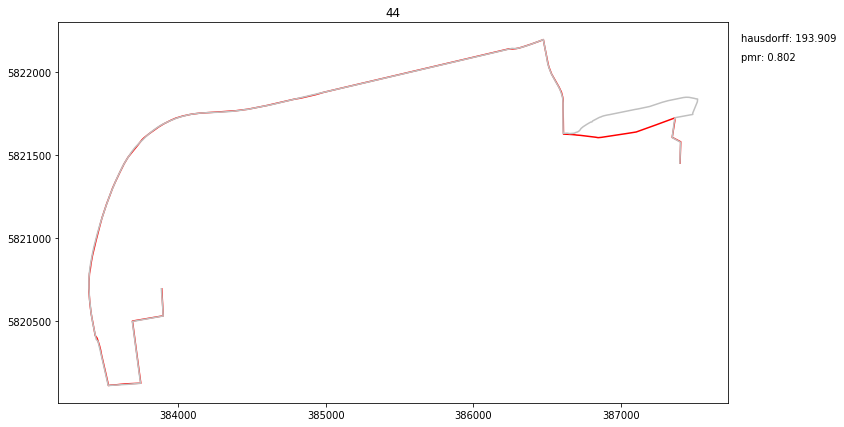

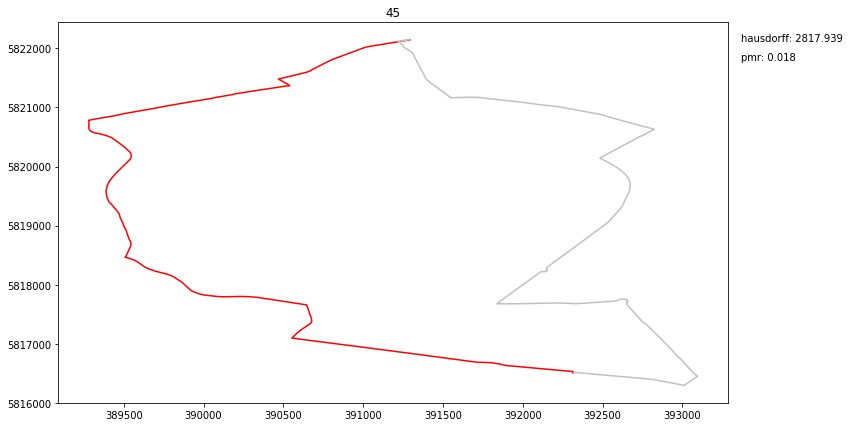

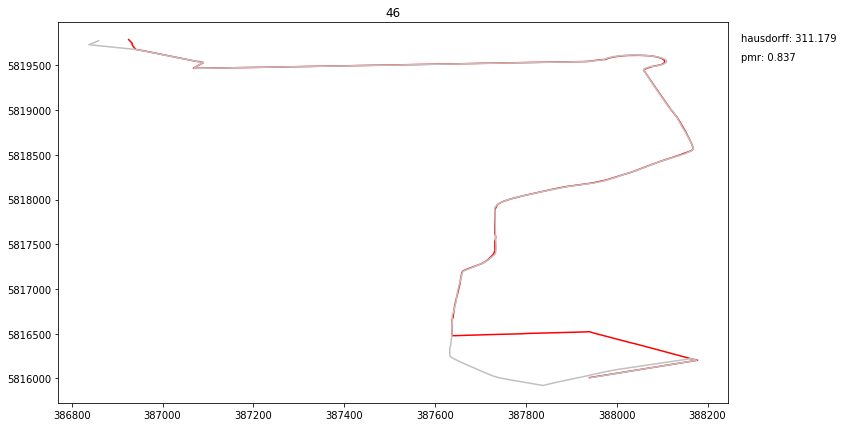

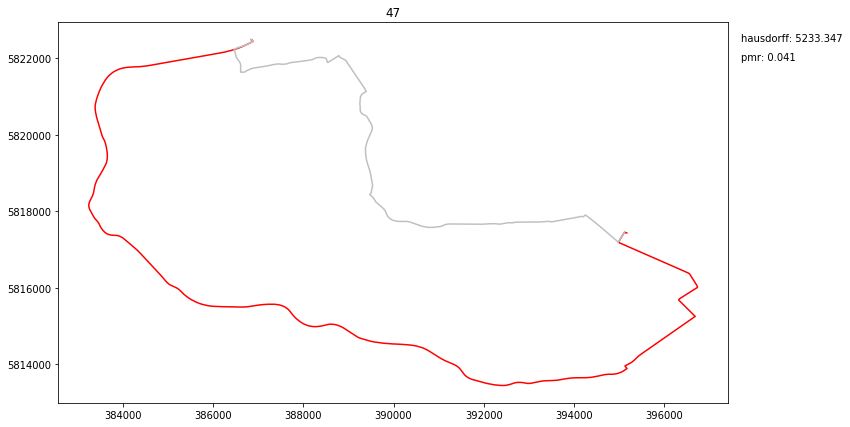

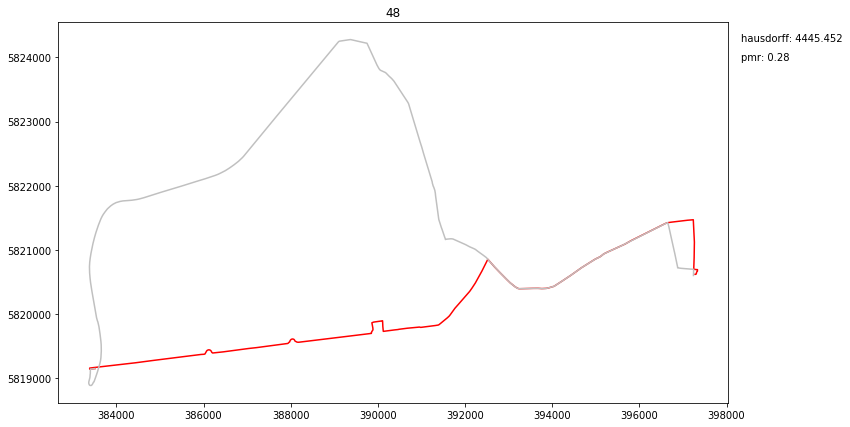

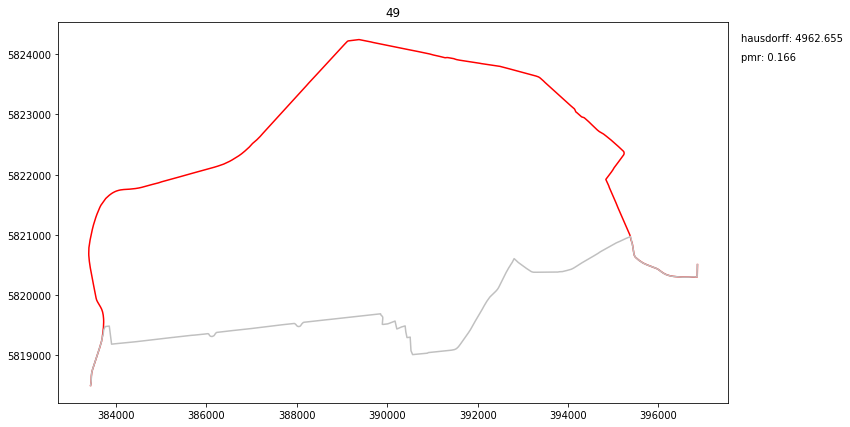

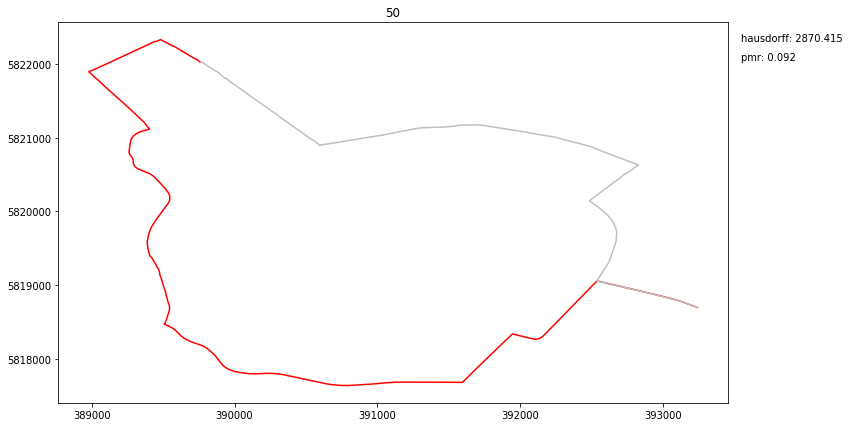

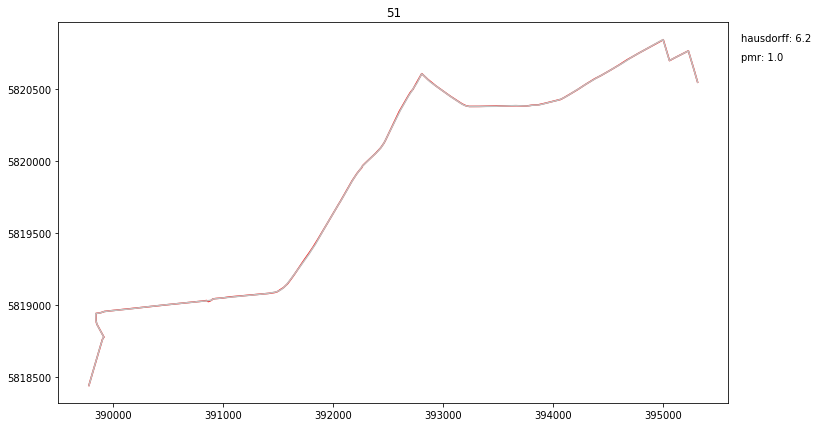

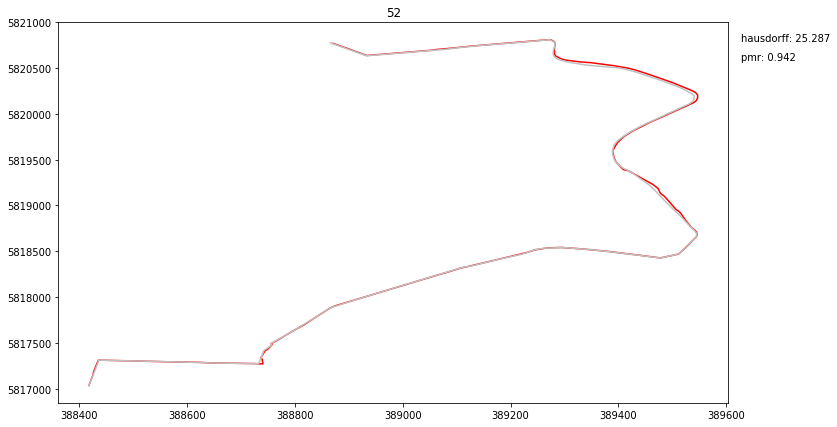

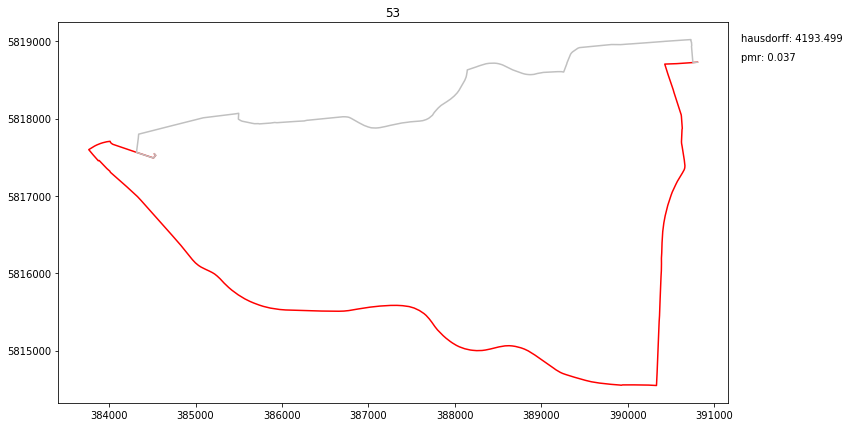

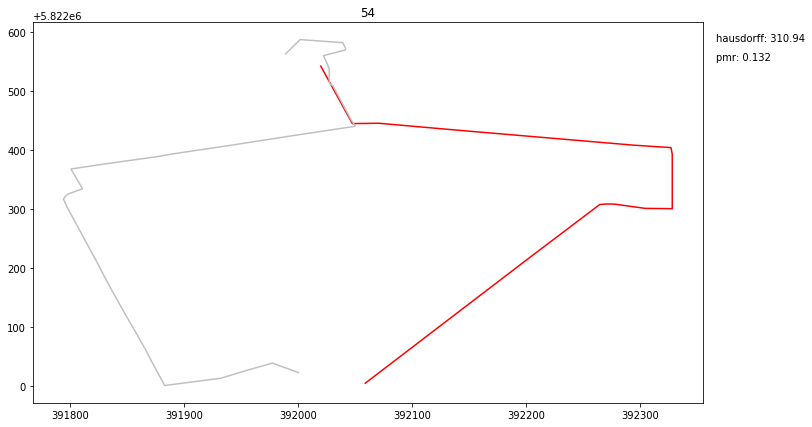

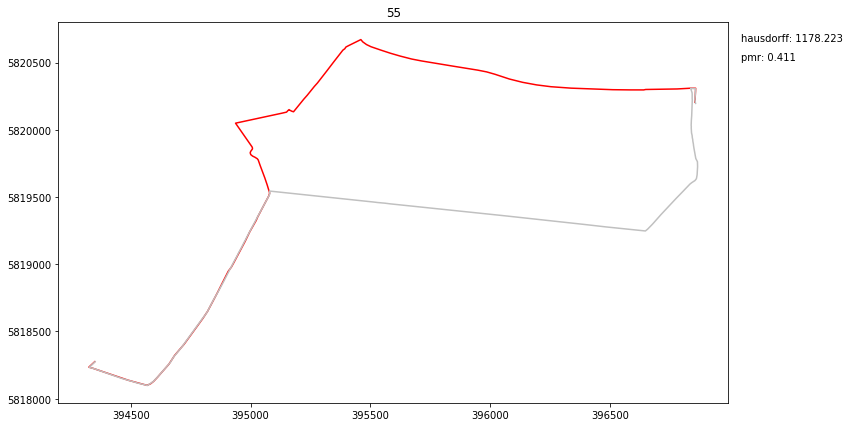

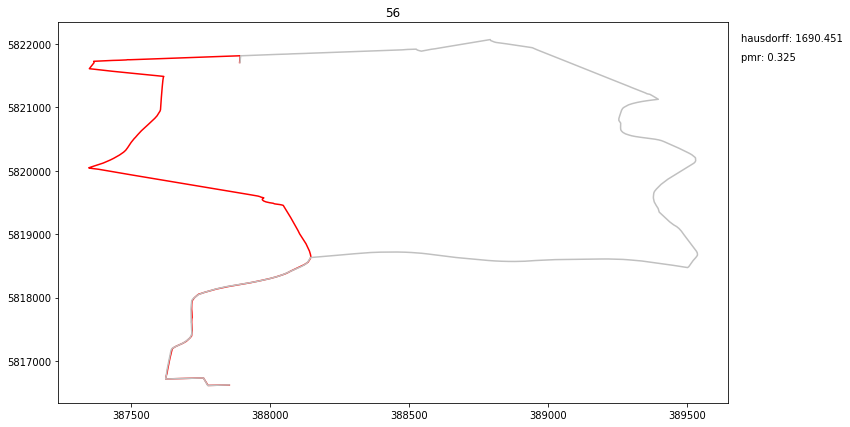

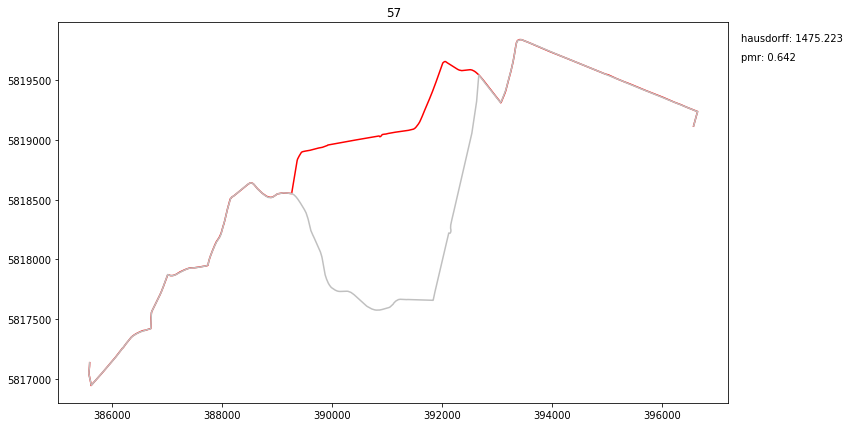

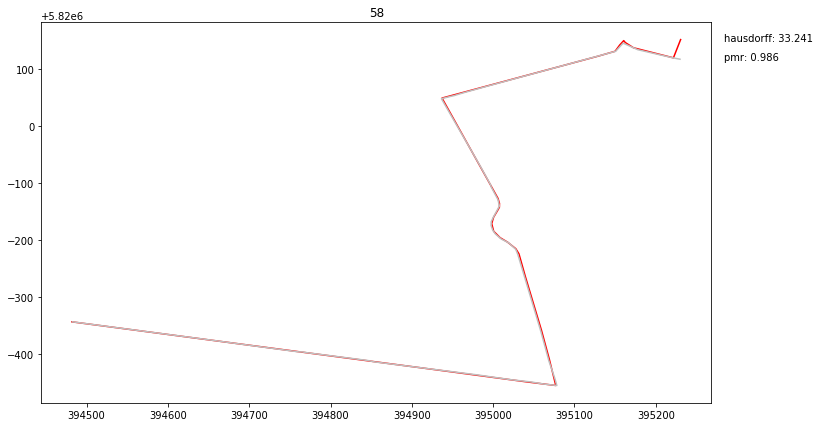

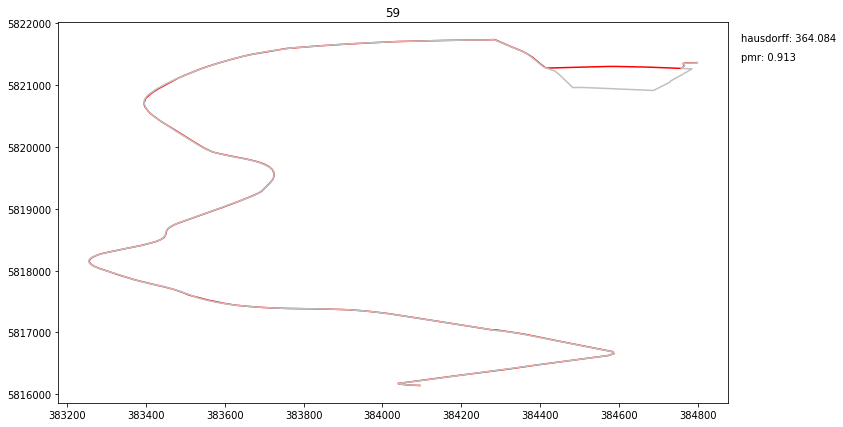

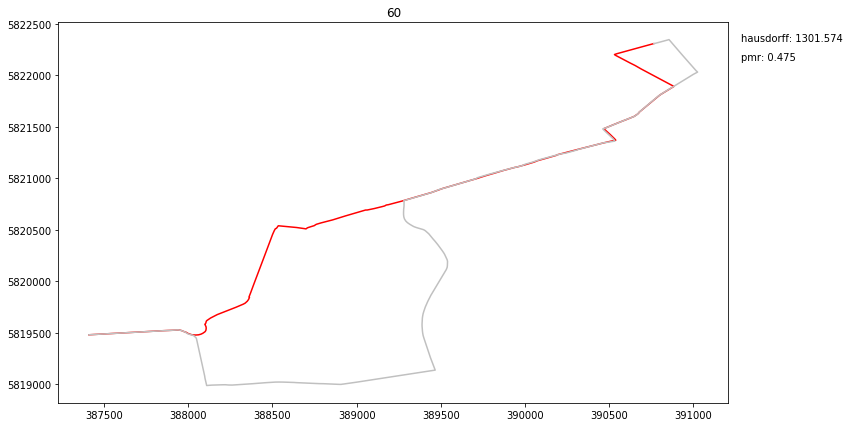

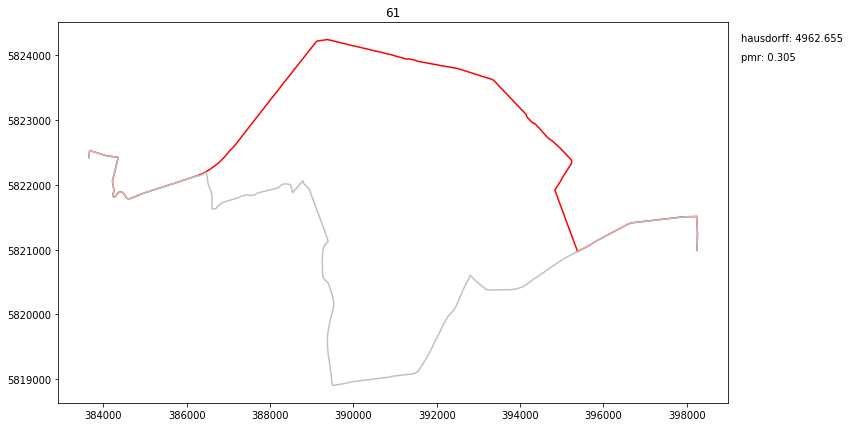

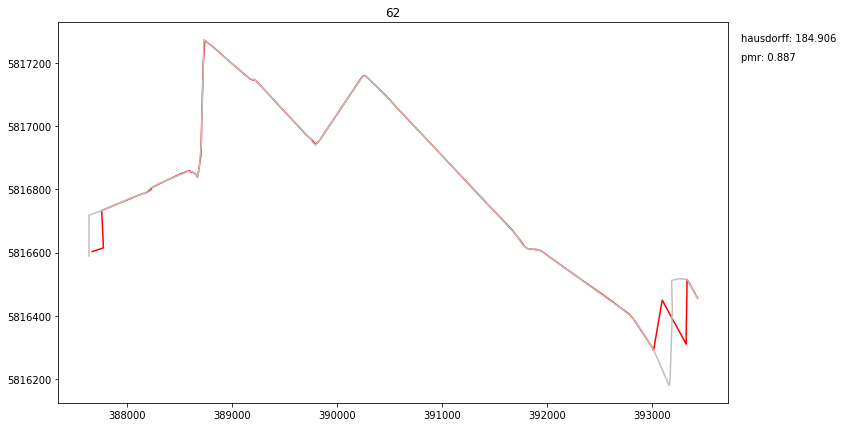

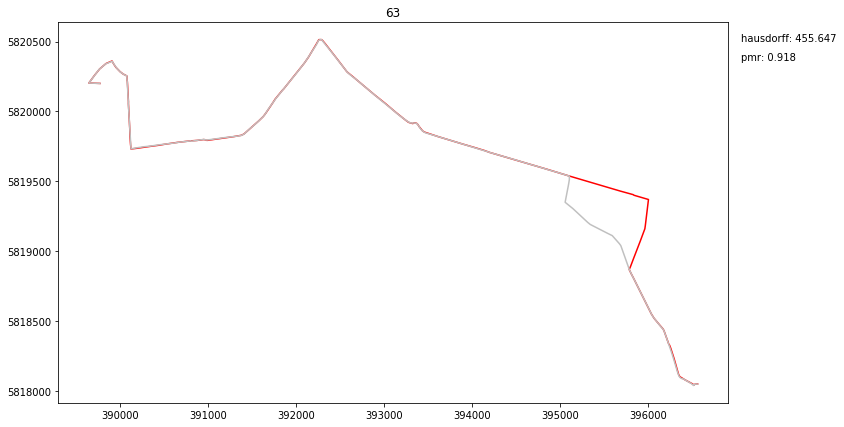

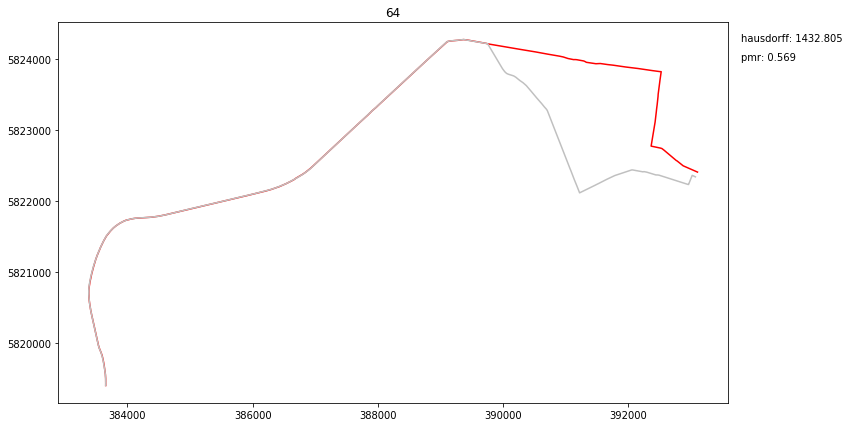

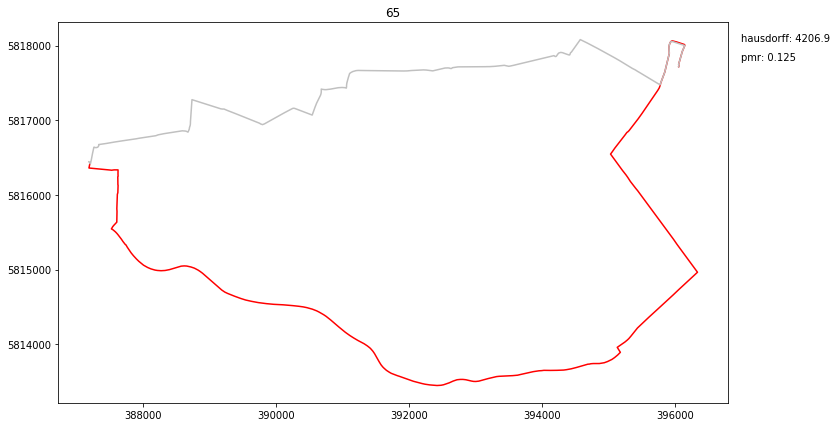

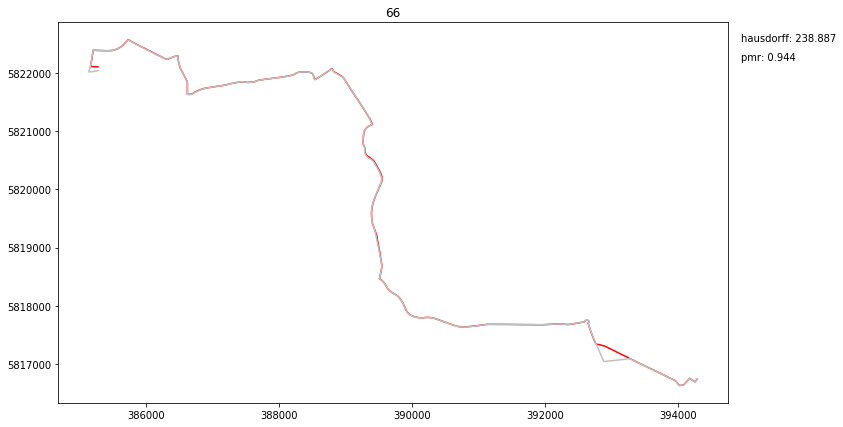

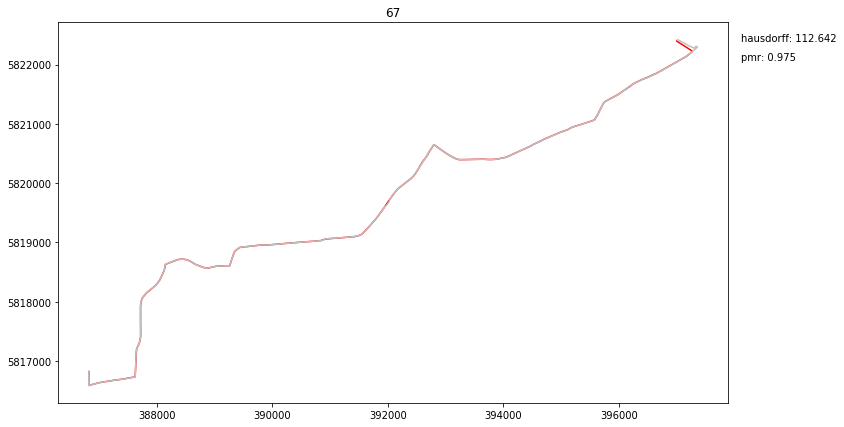

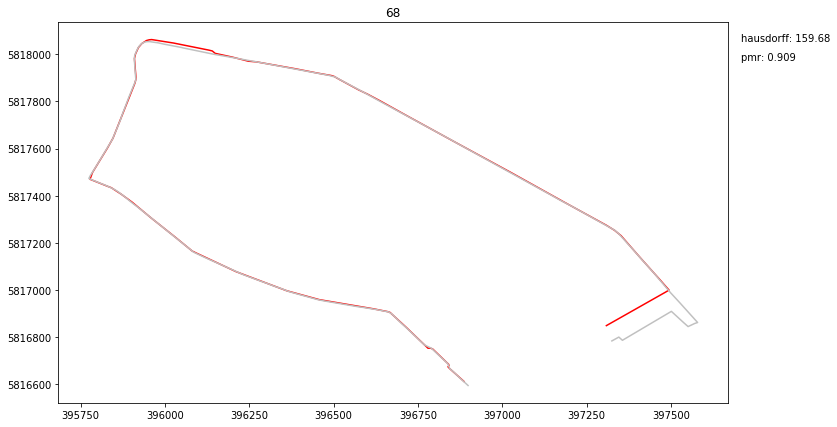

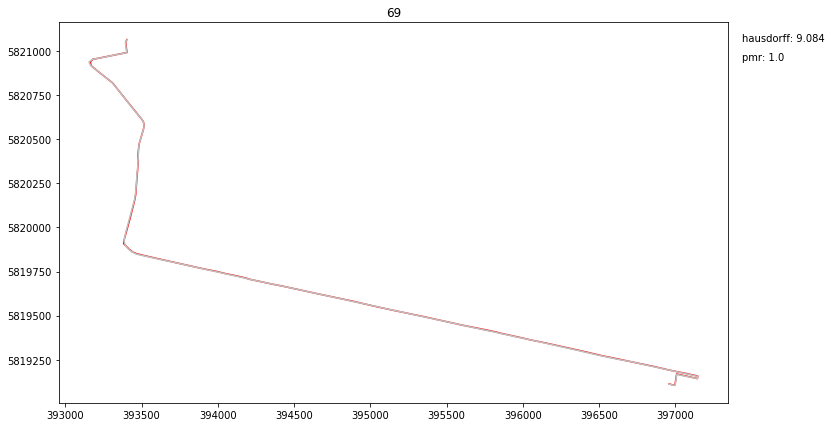

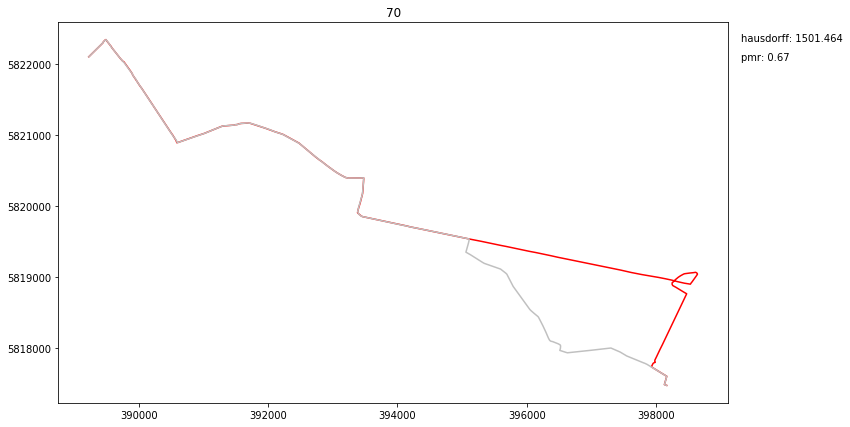

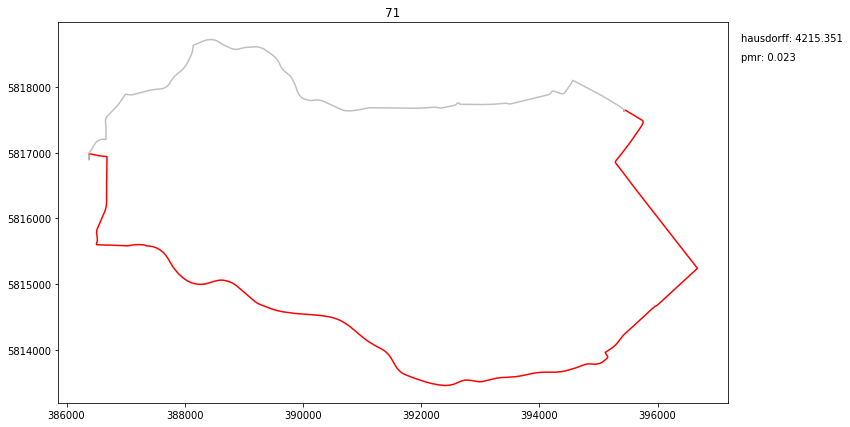

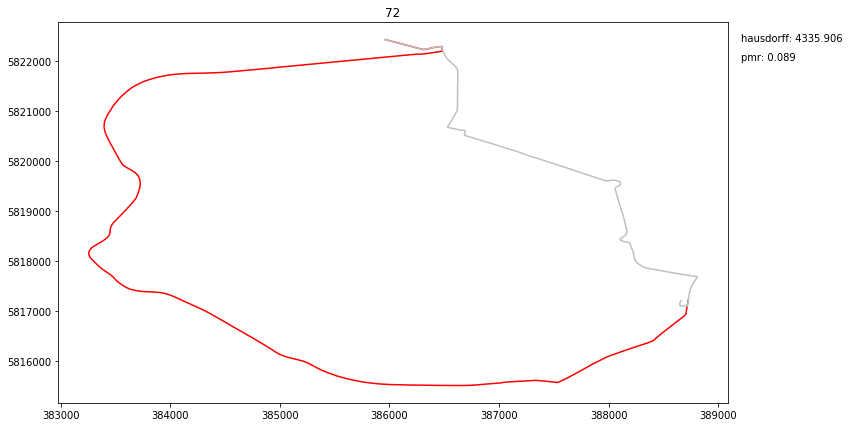

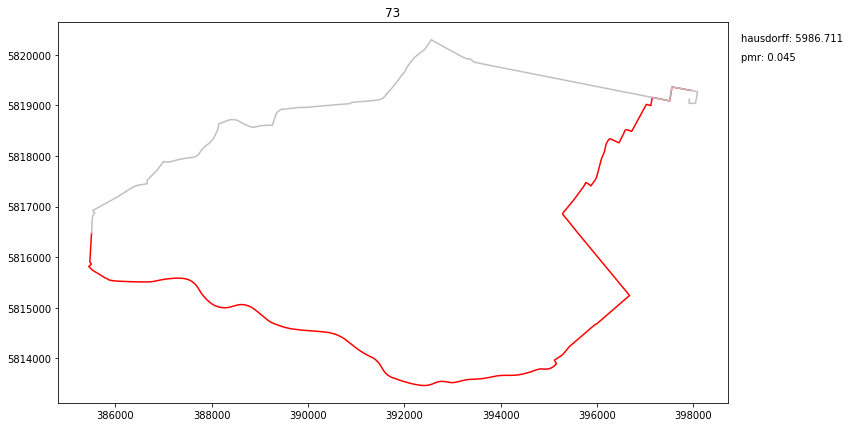

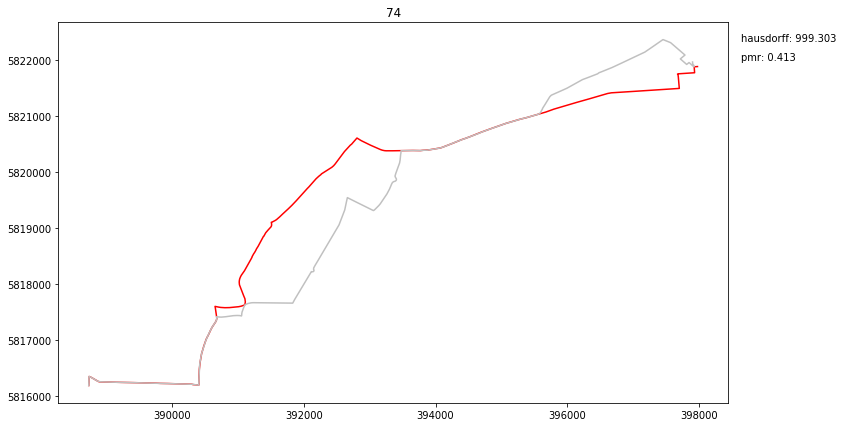

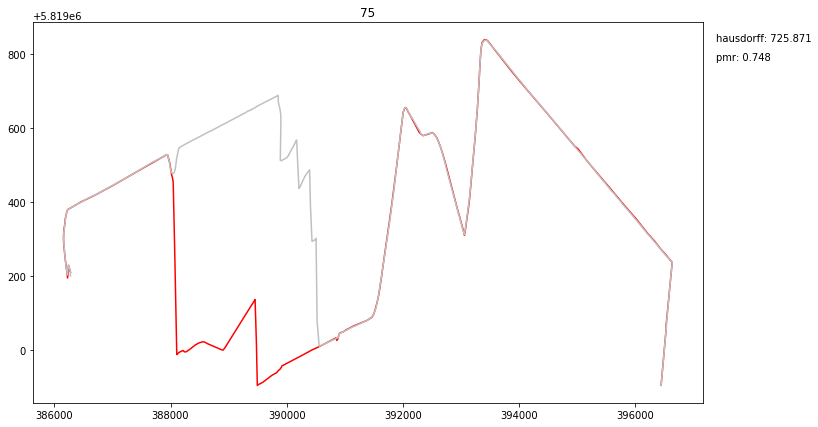

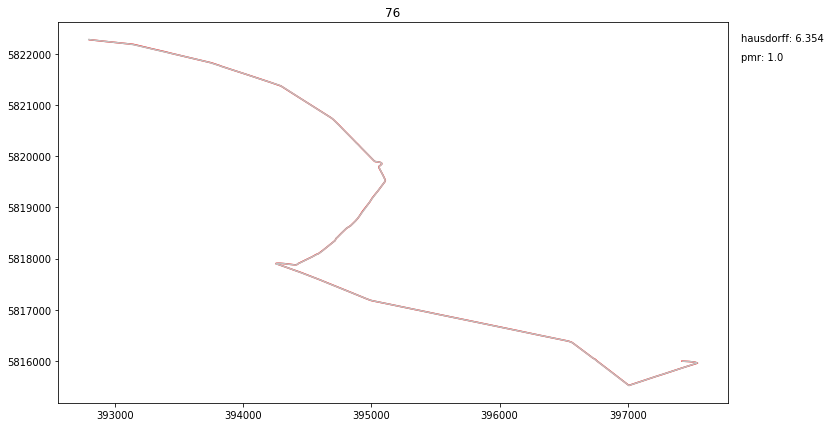

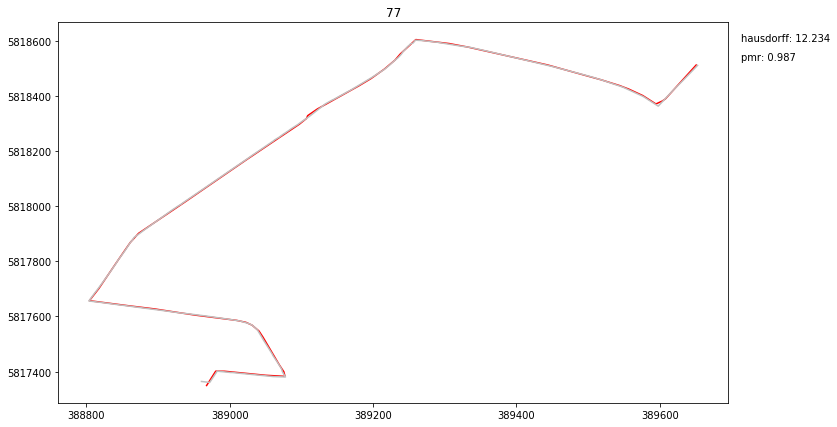

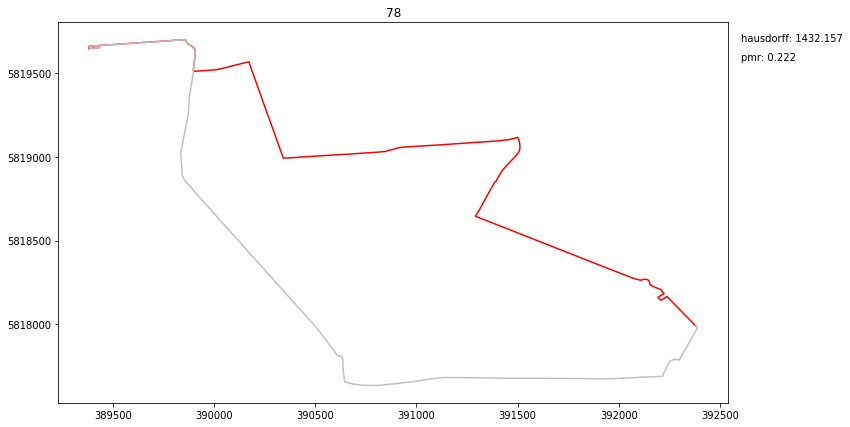

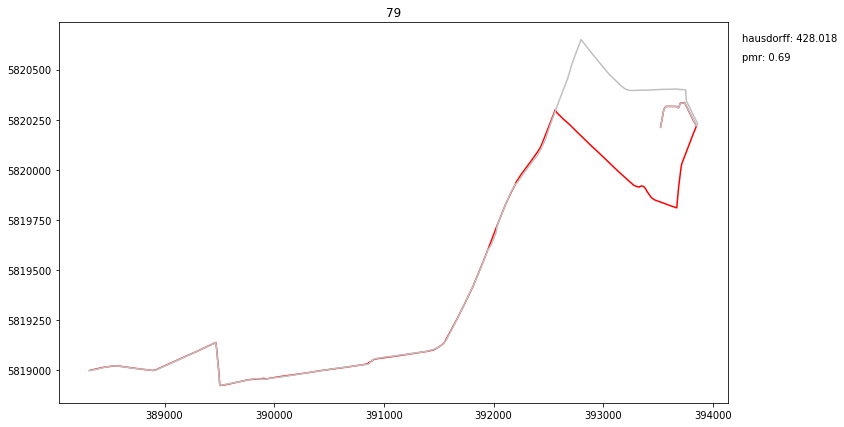

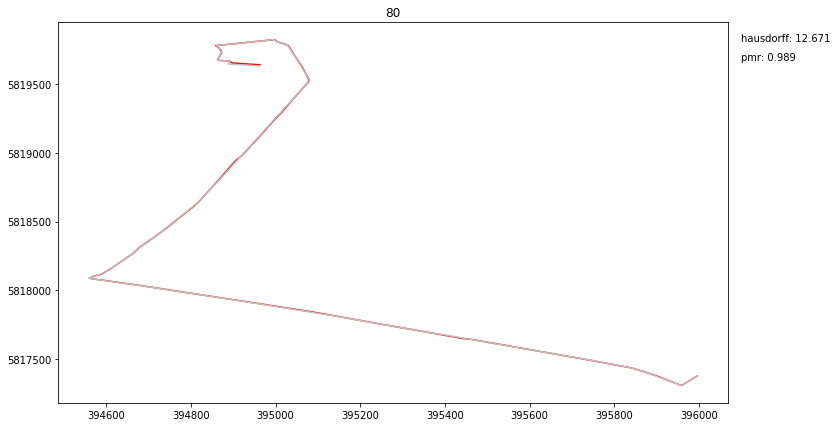

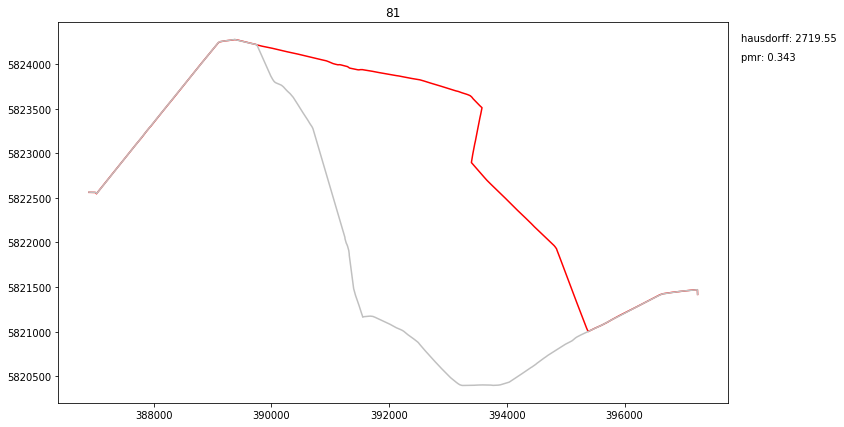

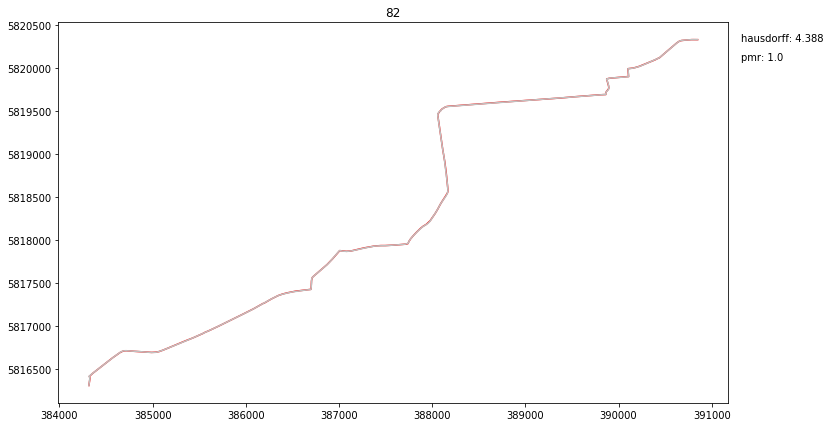

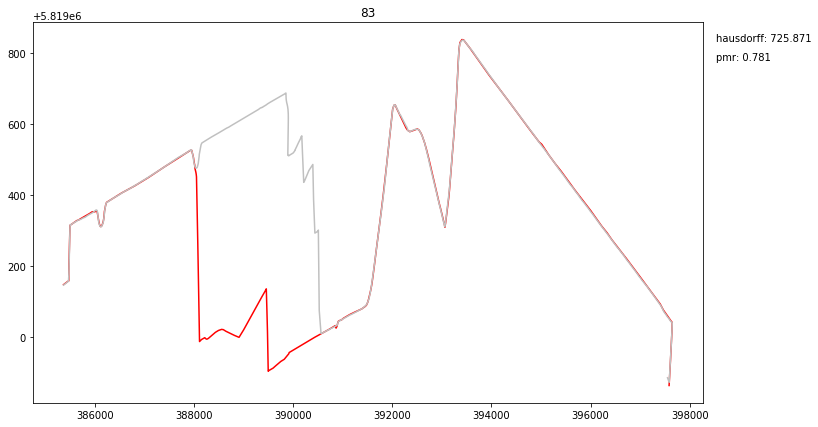

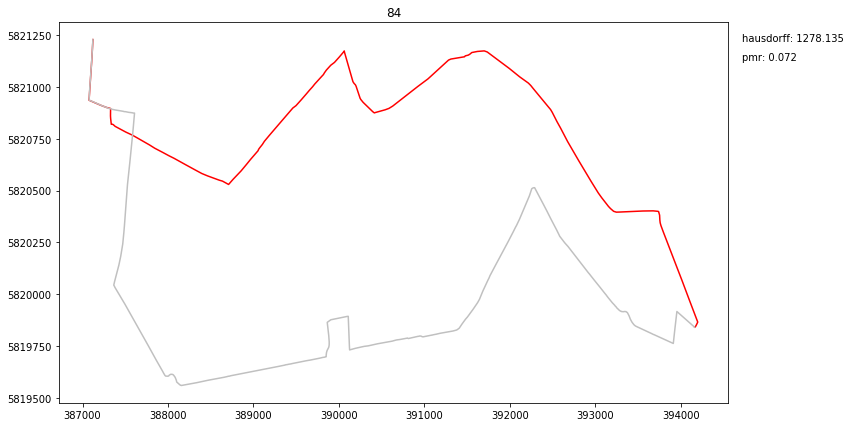

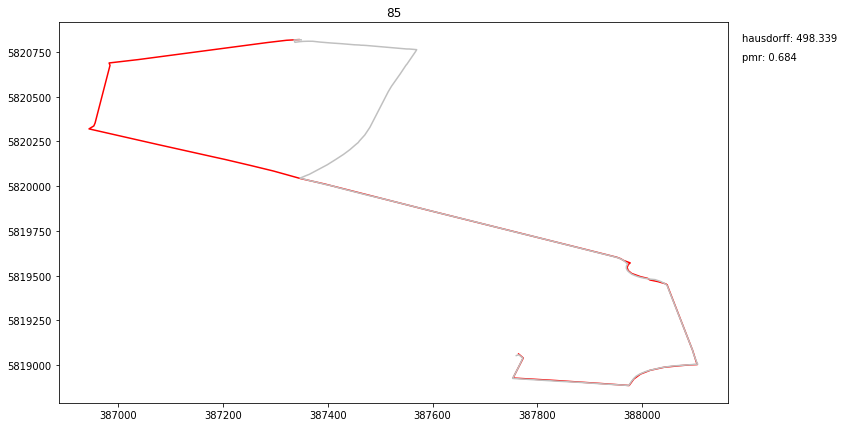

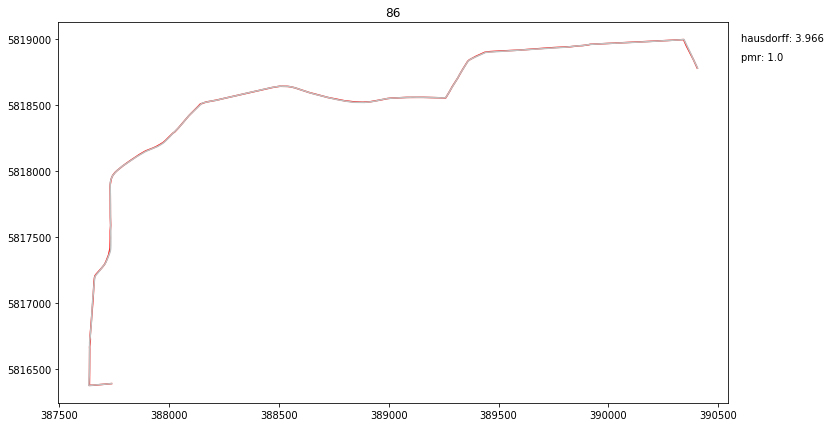

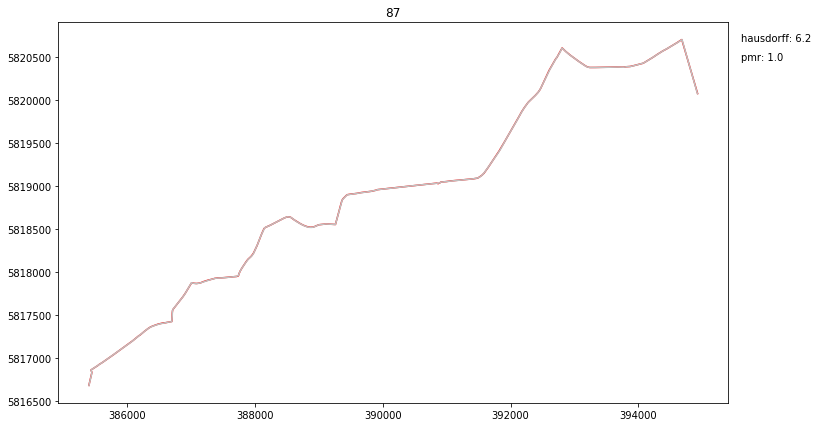

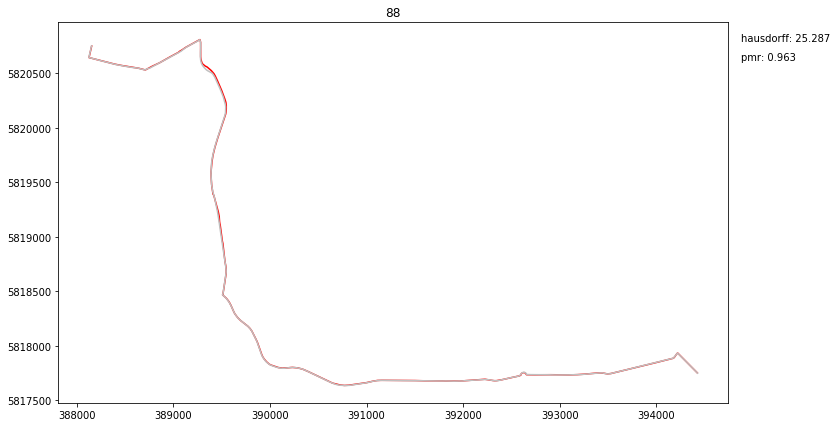

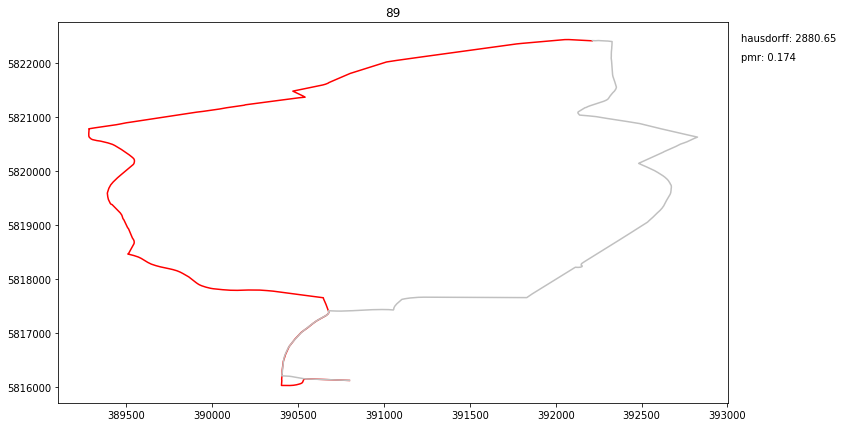

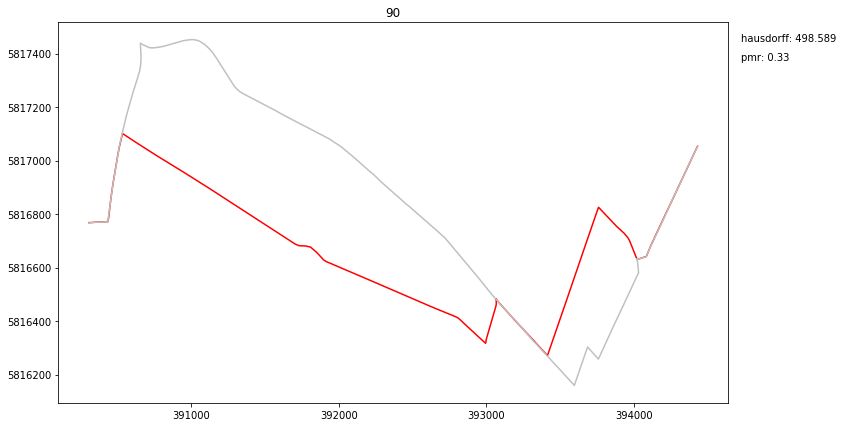

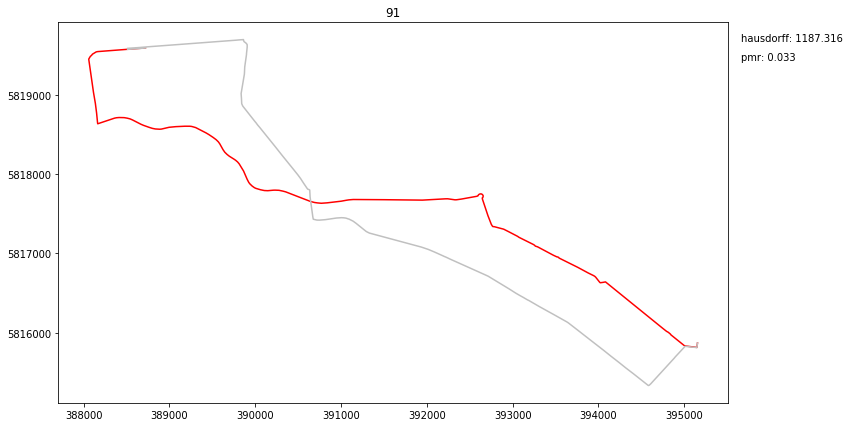

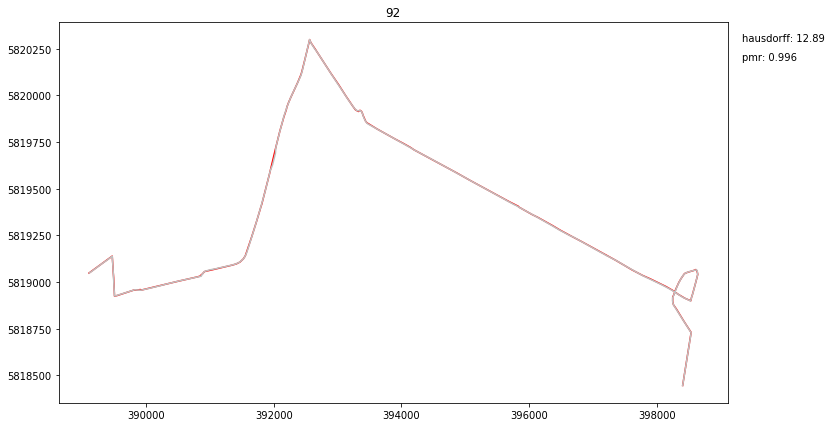

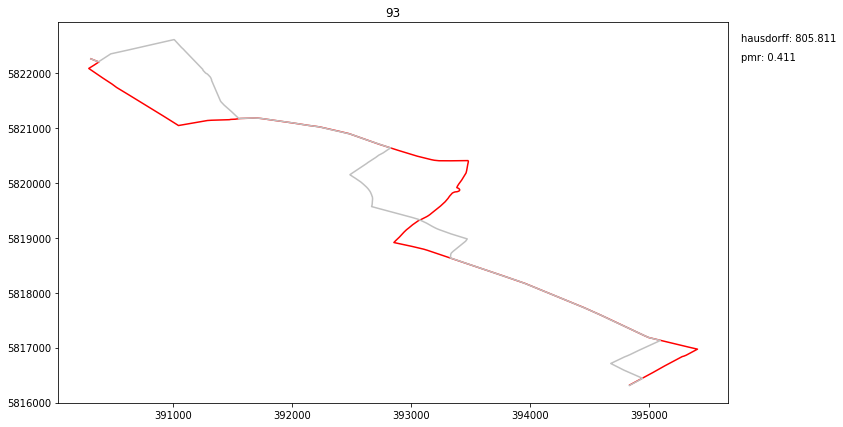

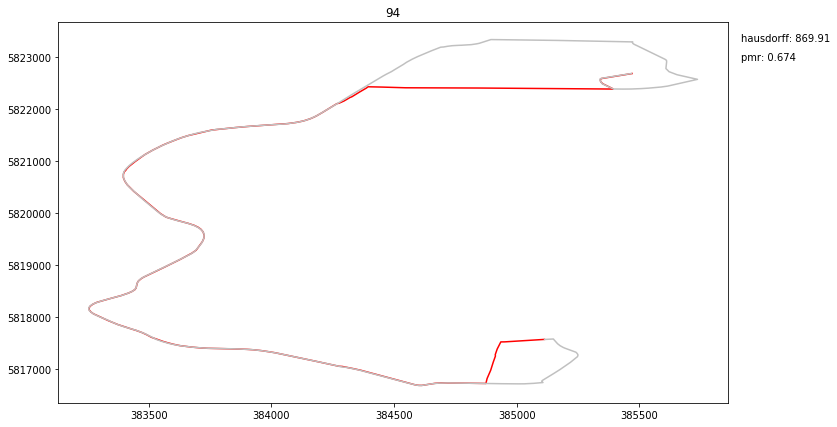

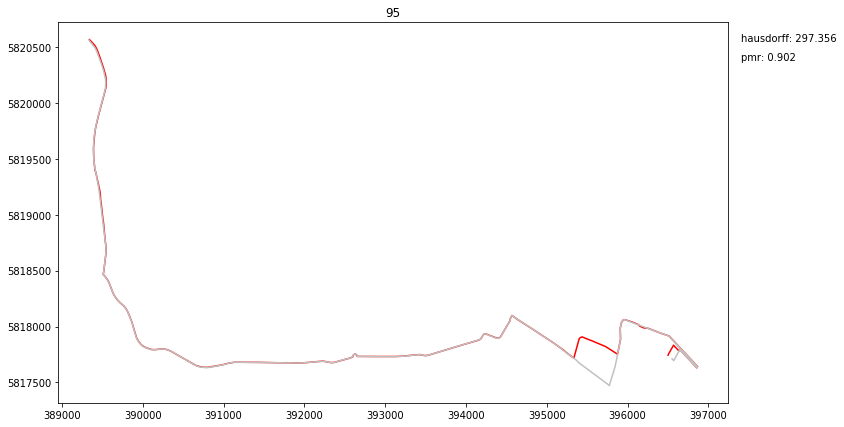

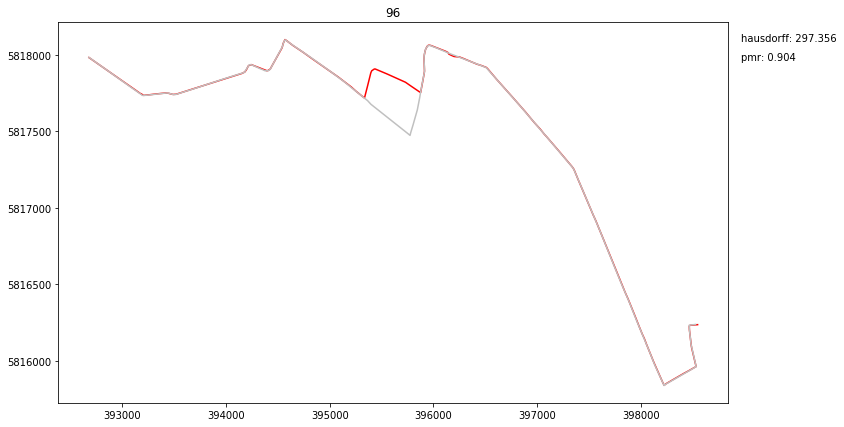

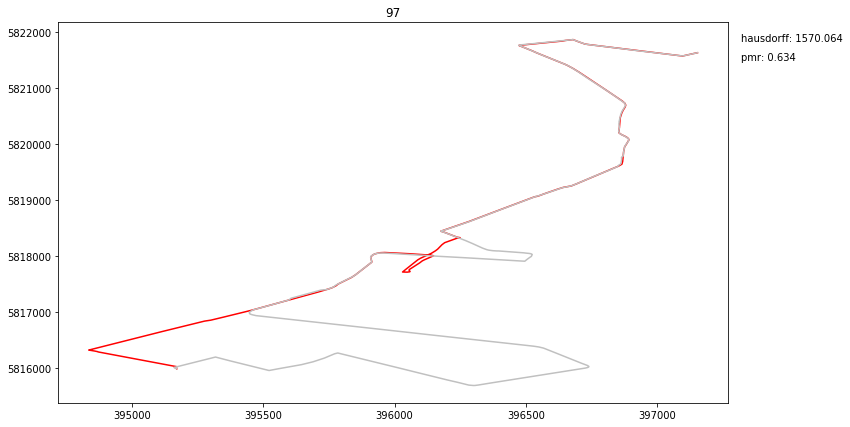

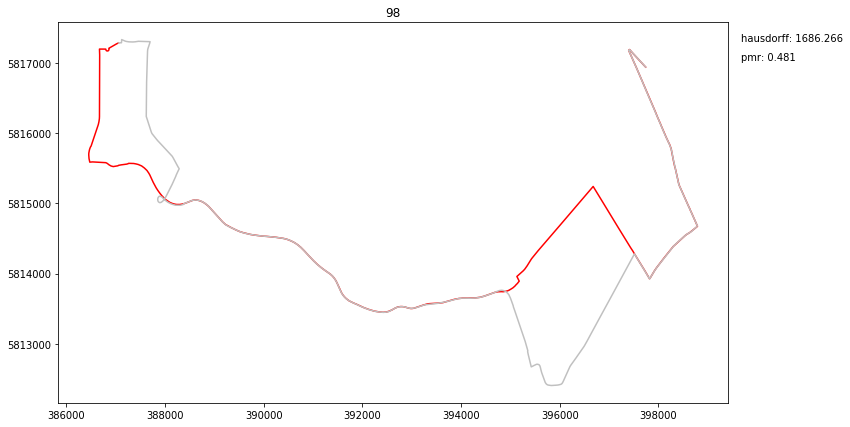

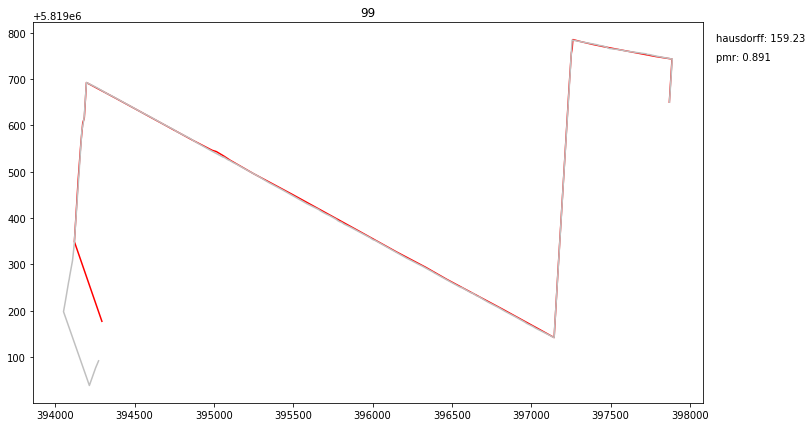

In [7]:
create_debug_artifacts(results_df)

## Conclusions

| algorithm | detour sensitivity | shifts | scaling | noise | sparsity | start/end mismatch | interpretability | perf |
|------|------|------|------|------|------|------|------|------|
|  hausdorff | +++ | - | +++ | - | +++ | --- | + | + 
|  PMR | -- | - | ++ | ++ | + | +++ | +++ | ++

* PMR most meaningful when comparing to others
    * Ratio is much more understandable    
    * Does not capture severity of differences
* Hausdorff best candidate for binary classifier:
    * Are both routes the same?
    * Determine match success

The following algorithms were eliminated for different reasons:
* Frechet, DTW (too slow)
* Centroids, AUC (too sensitive to scaling)
* AUC normalized, Levenshtein (too sensitive to shape representation)
* BOCS (too hard to interpret score)

# Code

Package: `route_quality.metrics.geometry`

Script: `geometry-comparison.py`

in https://gitlab.mobilityservices.io/am/roam/route-quality

# Preliminary tests

In [14]:
def analyze_results():
    results_df = pd.read_csv('results/routes_comparison.csv')
    scores = results_df[['score_compare_hausdorff', 'score_compare_pmr']]
    f, ax = plt.subplots(1, 2)
    plt.gcf().set_size_inches(12, 5)
    sns.distplot(scores['score_compare_hausdorff'], ax=ax[0], kde=False)
    sns.distplot(scores['score_compare_pmr'], ax=ax[1], kde=False)
    display(scores.describe())

score_compare_hausdorff  score_compare_pmr
count               100.000000         100.000000
mean               1113.395063           0.635188
std                1475.951500           0.351873
min                   3.966448           0.000000
25%                  84.252737           0.320258
50%                 498.463829           0.758917
75%                1443.409940           0.966200
max                5986.711128           1.000000

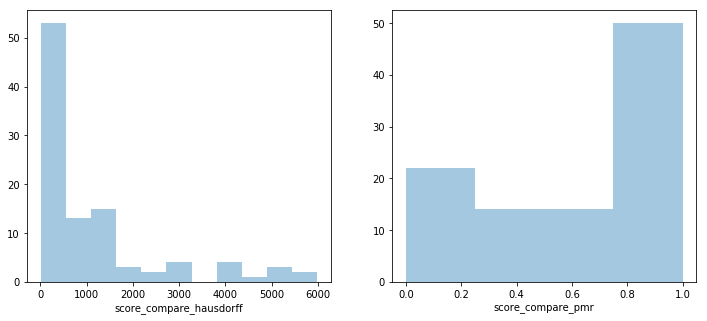

In [15]:
analyze_results()

# Next

* Find accuracy of prime metrics as match success classifiers
* Continue evaluating different metrics for different purposes

# Bonus: Route stats

In [393]:
import pandas as pd
import seaborn as sns

def melt(df, metrics):
    agg = pd.DataFrame()
    for metric in metrics:
        molten = pd.melt(df, id_vars=['route_id'], value_vars=[f'{metric}_{p}' for p in provider_names], var_name='provider', value_name=metric)
        molten['provider'] = molten['provider'].apply(lambda x: x.lstrip(f'{metric}_'))
        molten['provider'] = molten['provider'].apply(lambda x: 'google' if x == 'oogle' else x)
        molten['provider'] = molten['provider'].apply(lambda x: 'das-traffic' if x == 'as-traffic' else x)
        molten['provider'] = molten['provider'].apply(lambda x: 'das' if x == 'as' else x)
        molten = molten.set_index(['route_id', 'provider'])
        
        if agg.empty:
            agg = molten 
        else:
            agg = agg.join(molten)
    return agg

def compare_distributions(df, metric, label, palette='Blues'):
    f, ax = plt.subplots(1, 3)
    f.set_size_inches(15, 5)
    _ = sns.catplot(data=df, x='provider', y=metric, kind='box', palette=palette, ax=ax[0], showfliers=False)
    ax[0].set_xlabel('')
    ax[0].set_ylabel(label)
    ax[0].set_title('Boxplot (no outliers)')
    plt.close()
    _ = sns.catplot(data=df, x='provider', y=metric, kind='box', palette=palette, ax=ax[1])
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].set_title('Boxplot (with outliers)')
    plt.close()
    _ = sns.catplot(data=df, x='provider', y=metric, kind='swarm', palette=palette, ax=ax[2])
    ax[2].set_xlabel('')
    ax[2].set_ylabel('')
    ax[2].set_title('Swarmplot')
    plt.close()

provider_names = [p.name for p in providers]

df = pd.read_csv('results/routes.csv')
for provider in provider_names:
    df[f'speed_{provider}'] = (df[f'length_{provider}'] / 1000).div(df[f'eta_{provider}'] / 3600)
df.tail(5)

palette = {'google': '#EA4335', 'das': 'gray', 'das-traffic': 'silver'}

In [334]:
metrics = melt(df, ['length', 'eta', 'speed']).reset_index()
metrics['length'] = metrics['length'] / 1000
metrics['eta'] = metrics['eta'] / 60

## Length comparison

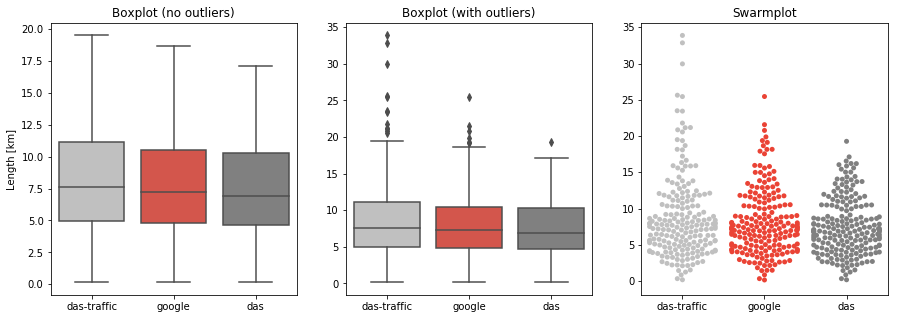

In [394]:
compare_distributions(metrics, 'length', 'Length [km]', palette=palette)

## ETA comparison

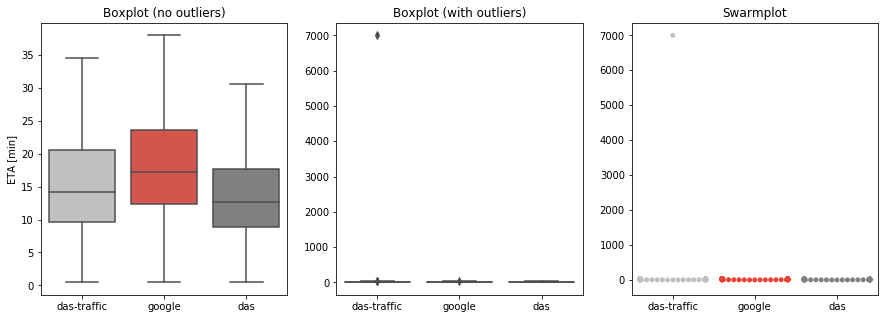

In [396]:
compare_distributions(metrics, 'eta', 'ETA [min]', palette=palette)

## Speed comparison

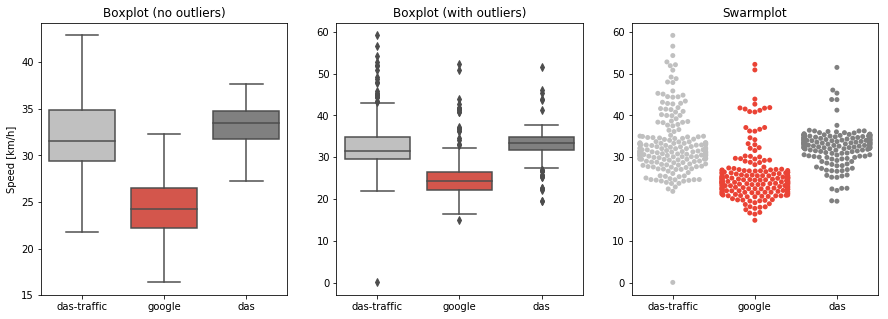

In [397]:
compare_distributions(metrics, 'speed', 'Speed [km/h]', palette=palette)

### Speed diffs vs Google

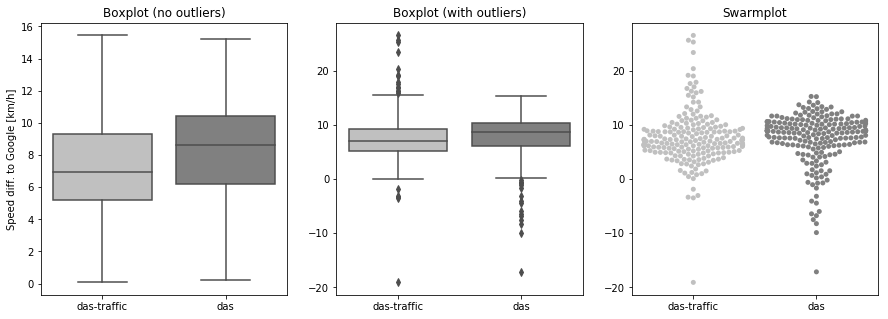

In [398]:
df['das-traffic'] = df['speed_das-traffic'] - df['speed_google']
df['das'] = df['speed_das'] - df['speed_google']
vs = pd.melt(df[['route_id', 'das-traffic', 'das']], id_vars=['route_id'], var_name='provider', value_vars=['das-traffic', 'das'], value_name='speed_diff')
compare_distributions(vs, 'speed_diff', 'Speed diff. to Google [km/h]', palette=palette)

## ETA vs Length

Text(31.5515,0.5,'ETA [min]')

<Figure size 432x288 with 0 Axes>

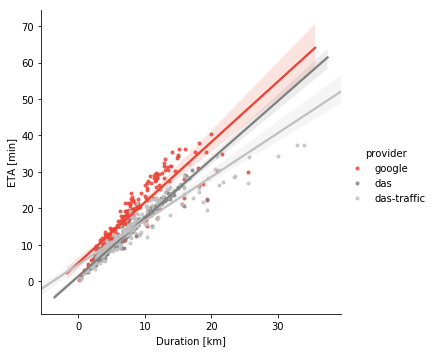

In [404]:
f = plt.figure()
sns.lmplot(data=metrics.drop(index=24).sort_values('speed', ascending=True), 
           x='length', y='eta', hue='provider', palette=palette, markers='.')
plt.xlabel('Duration [km]')
plt.ylabel('ETA [min]')